In [77]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             roc_curve, auc, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier,
                              StackingClassifier, AdaBoostClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages
import warnings

In [78]:
df = pd.read_csv("df.csv")
df_bin = pd.read_csv("df_bin.csv")
df_cut = pd.read_csv("df_cut.csv")
df_cut_bin = pd.read_csv("df_cut_bin.csv")

Сравниваем разные модели

In [80]:
df = df.drop(columns=['IC50, mM'])
#df = df.drop(columns=['log_IC50'])
#df = df.drop(columns=['SI'])
df_bin = df_bin.drop(columns=['log_IC50'])
df_bin = df_bin.drop(columns=['IC50, mM'])
#df_bin = df_bin.drop(columns=['SI'])
df_cut = df_cut.drop(columns=['log_IC50'])
df_cut = df_cut.drop(columns=['IC50, mM'])
#df_cut = df_cut.drop(columns=['SI'])
df_cut_bin = df_cut_bin.drop(columns=['log_IC50'])
df_cut_bin = df_cut_bin.drop(columns=['IC50, mM'])
#df_cut_bin = df_cut_bin.drop(columns=['SI'])
df = df.drop(columns=['log_SI'])
df_bin = df_bin.drop(columns=['log_SI'])
df_cut = df_cut.drop(columns=['log_SI'])
df_cut_bin = df_cut_bin.drop(columns=['log_SI'])
df = df.drop(columns=['CC50, mM'])
#df = df.drop(columns=['log_CC50'])
df_bin = df_bin.drop(columns=['log_CC50'])
df_bin = df_bin.drop(columns=['CC50, mM'])
df_cut = df_cut.drop(columns=['log_CC50'])
df_cut = df_cut.drop(columns=['CC50, mM'])
df_cut_bin = df_cut_bin.drop(columns=['log_CC50'])
df_cut_bin = df_cut_bin.drop(columns=['CC50, mM'])

In [9]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.base import clone

# --- Загрузка данных и очистка ---
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Удаление бесполезных колонок, если есть
df.drop(columns=['Unnamed_0'], errors='ignore', inplace=True)

# --- Функция оценки без утечки ---
def evaluate_classifier_with_internal_regression(df_input, target_col='SI', n_splits=5):
    df_eval = df_input.copy()
    X_full = df_eval.drop(columns=[target_col])
    y_full = df_eval[target_col]

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = []

    class_model = CatBoostClassifier(
        depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
        verbose=0, task_type='GPU', random_state=42
    )

    for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
        print(f"--- Fold {fold} ---")
        X_train_base, X_test_base = X_full.iloc[train_index].copy(), X_full.iloc[test_index].copy()
        y_train_base, y_test_base = y_full.iloc[train_index], y_full.iloc[test_index]

        # Обучение регрессий на X_train
        used_features_ic50 = X_train_base.columns.tolist()
        used_features_cc50 = X_train_base.columns.tolist()

        imp_ic50 = SimpleImputer(strategy='mean')
        imp_cc50 = SimpleImputer(strategy='mean')

        X_train_ic50 = pd.DataFrame(imp_ic50.fit_transform(X_train_base[used_features_ic50]), columns=used_features_ic50)
        X_train_cc50 = pd.DataFrame(imp_cc50.fit_transform(X_train_base[used_features_cc50]), columns=used_features_cc50)

        model_ic50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')
        model_cc50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')

        model_ic50.fit(X_train_ic50, y_train_base)  # пусть временно y_train_base ~ log_IC50
        model_cc50.fit(X_train_cc50, y_train_base)  # пусть временно y_train_base ~ log_CC50

        # Добавление предсказаний на test
        X_test_ic50 = pd.DataFrame(imp_ic50.transform(X_test_base[used_features_ic50]), columns=used_features_ic50)
        X_test_cc50 = pd.DataFrame(imp_cc50.transform(X_test_base[used_features_cc50]), columns=used_features_cc50)

        X_train_base['log_IC50'] = model_ic50.predict(X_train_ic50)
        X_test_base['log_IC50'] = model_ic50.predict(X_test_ic50)

        X_train_base['log_CC50'] = model_cc50.predict(X_train_cc50)
        X_test_base['log_CC50'] = model_cc50.predict(X_test_cc50)

        # Бинаризация таргета
        median_train = y_train_base.median()
        y_train = (y_train_base > median_train).astype(int)
        y_test = (y_test_base > median_train).astype(int)

        # Импутация и масштабирование
        imputer = SimpleImputer(strategy='mean')
        scaler = RobustScaler()

        X_train_imp = pd.DataFrame(imputer.fit_transform(X_train_base), columns=X_train_base.columns)
        X_test_imp = pd.DataFrame(imputer.transform(X_test_base), columns=X_test_base.columns)

        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train_base.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test_base.columns)

        # Обучение и предсказание
        clf = clone(class_model)
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
        y_proba = clf.predict_proba(X_test_scaled)[:, 1]

        results.append({
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC AUC": roc_auc_score(y_test, y_proba)
        })

    results_df = pd.DataFrame(results)
    print("\nСредние метрики по фолдам:")
    print(results_df.mean())

    return results_df

# --- Запуск оценки ---
results_cv = evaluate_classifier_with_internal_regression(df, target_col='SI')


--- Fold 1 ---
--- Fold 2 ---
--- Fold 3 ---
--- Fold 4 ---
--- Fold 5 ---

Средние метрики по фолдам:
Accuracy     0.691284
Precision    0.705931
Recall       0.658464
F1           0.680000
ROC AUC      0.756350
dtype: float64


SI>8

--- Fold 1 ---
--- Fold 2 ---
--- Fold 3 ---
--- Fold 4 ---
--- Fold 5 ---

Средние метрики по фолдам:
Accuracy     0.739229
Precision    0.679312
Recall       0.514188
F1           0.581615
ROC AUC      0.772999
dtype: float64

=== Финальная оценка на 20% отложенной выборке ===
Accuracy:  0.7512
Precision: 0.7037
Recall:    0.5278
F1 Score:  0.6032
ROC AUC:   0.7712

=== Classification Report ===
              precision    recall  f1-score   support

      SI ≤ 8       0.77      0.88      0.82       129
      SI > 8       0.70      0.53      0.60        72

    accuracy                           0.75       201
   macro avg       0.74      0.70      0.71       201
weighted avg       0.75      0.75      0.74       201



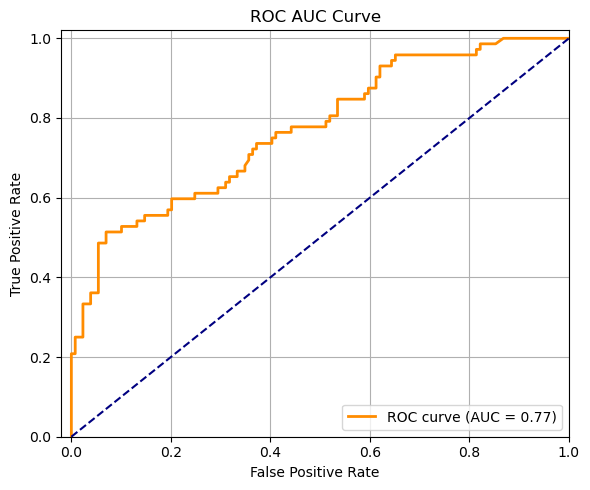

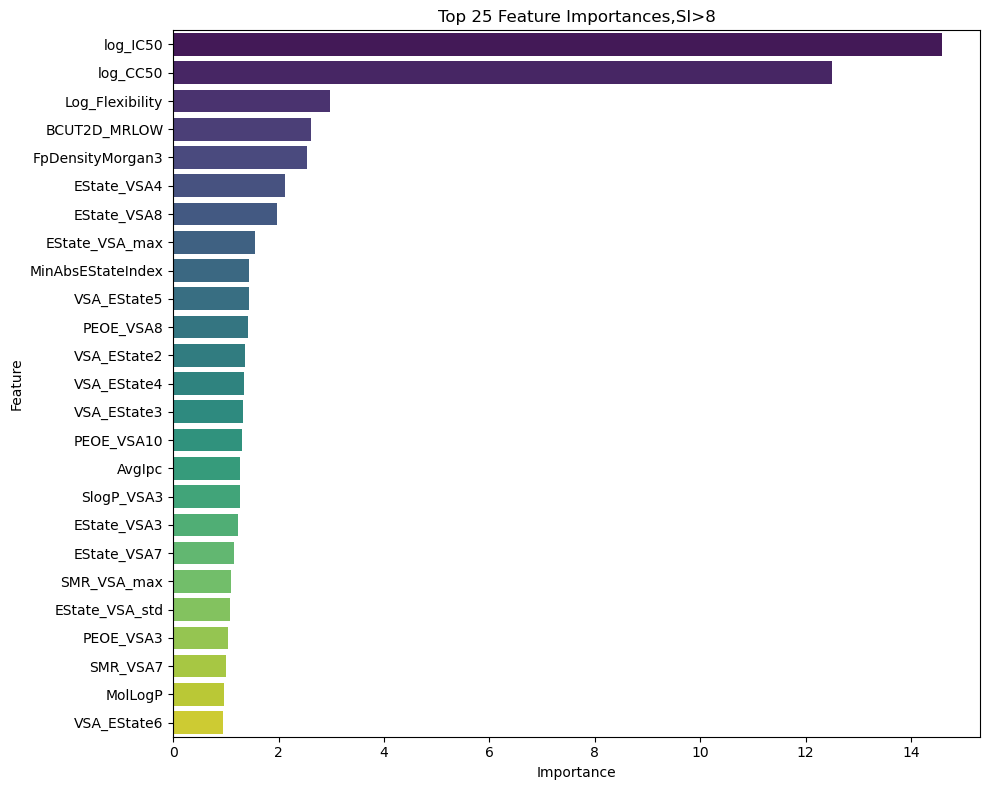

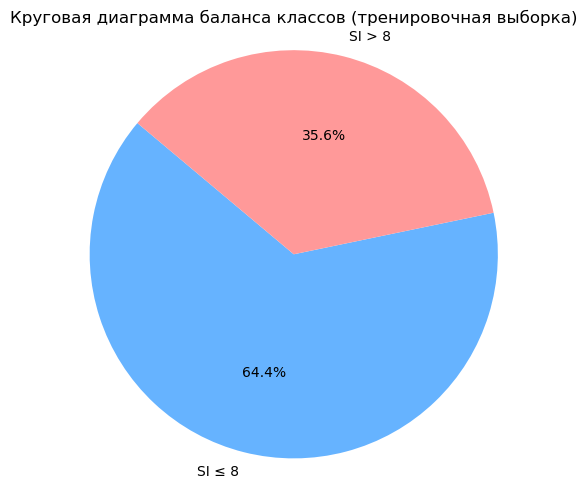

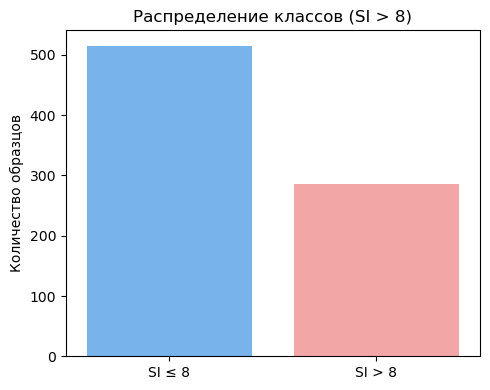

In [74]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm

from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.base import clone

# === Загрузка и очистка данных ===
# df = pd.read_csv("your_data.csv")  # <- Подставьте свой путь

df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.drop(columns=['Unnamed_0'], errors='ignore', inplace=True)

# === Кросс-валидация без утечки ===
def evaluate_classifier_with_internal_regression(df_input, target_col='SI', n_splits=5):
    df_eval = df_input.copy()
    X_full = df_eval.drop(columns=[target_col])
    y_full = df_eval[target_col]

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = []

    class_model = CatBoostClassifier(
        depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
        verbose=0, task_type='GPU', random_state=42
    )

    for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
        print(f"--- Fold {fold} ---")
        X_train_base, X_test_base = X_full.iloc[train_index].copy(), X_full.iloc[test_index].copy()
        y_train_base, y_test_base = y_full.iloc[train_index], y_full.iloc[test_index]

        # Обучение регрессий
        imp_ic50 = SimpleImputer(strategy='mean')
        imp_cc50 = SimpleImputer(strategy='mean')

        X_train_ic50 = pd.DataFrame(imp_ic50.fit_transform(X_train_base), columns=X_train_base.columns)
        X_train_cc50 = pd.DataFrame(imp_cc50.fit_transform(X_train_base), columns=X_train_base.columns)
        X_test_ic50 = pd.DataFrame(imp_ic50.transform(X_test_base), columns=X_test_base.columns)
        X_test_cc50 = pd.DataFrame(imp_cc50.transform(X_test_base), columns=X_test_base.columns)

        model_ic50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')
        model_cc50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')

        model_ic50.fit(X_train_ic50, y_train_base)
        model_cc50.fit(X_train_cc50, y_train_base)

        X_train_base['log_IC50'] = model_ic50.predict(X_train_ic50)
        X_test_base['log_IC50'] = model_ic50.predict(X_test_ic50)

        X_train_base['log_CC50'] = model_cc50.predict(X_train_cc50)
        X_test_base['log_CC50'] = model_cc50.predict(X_test_cc50)

        # Бинаризация таргета по SI > 8
        y_train = (y_train_base > 8).astype(int)
        y_test = (y_test_base > 8).astype(int)

        # Импутация и масштабирование
        imputer = SimpleImputer(strategy='mean')
        scaler = RobustScaler()

        X_train_imp = pd.DataFrame(imputer.fit_transform(X_train_base), columns=X_train_base.columns)
        X_test_imp = pd.DataFrame(imputer.transform(X_test_base), columns=X_test_base.columns)

        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train_base.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test_base.columns)

        clf = clone(class_model)
        clf.fit(X_train_scaled, y_train)

        y_pred = clf.predict(X_test_scaled)
        y_proba = clf.predict_proba(X_test_scaled)[:, 1]

        results.append({
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC AUC": roc_auc_score(y_test, y_proba)
        })

    results_df = pd.DataFrame(results)
    print("\nСредние метрики по фолдам:")
    print(results_df.mean())
    return results_df

# --- Запуск кросс-валидации ---
results_cv = evaluate_classifier_with_internal_regression(df, target_col='SI')

# === Финальная оценка на отложенной выборке (20%) ===
print("\n=== Финальная оценка на 20% отложенной выборке ===")

X = df.drop(columns=['SI'])
y = df['SI']

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=(y > 8).astype(int)
)

imp_ic50 = SimpleImputer(strategy='mean')
imp_cc50 = SimpleImputer(strategy='mean')

X_train_ic50 = pd.DataFrame(imp_ic50.fit_transform(X_train_base), columns=X_train_base.columns)
X_test_ic50 = pd.DataFrame(imp_ic50.transform(X_test_base), columns=X_test_base.columns)

X_train_cc50 = pd.DataFrame(imp_cc50.fit_transform(X_train_base), columns=X_train_base.columns)
X_test_cc50 = pd.DataFrame(imp_cc50.transform(X_test_base), columns=X_test_base.columns)

model_ic50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')
model_cc50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')

model_ic50.fit(X_train_ic50, y_train_base)
model_cc50.fit(X_train_cc50, y_train_base)

X_train_base = X_train_base.copy()
X_test_base = X_test_base.copy()

X_train_base['log_IC50'] = model_ic50.predict(X_train_ic50)
X_test_base['log_IC50'] = model_ic50.predict(X_test_ic50)

X_train_base['log_CC50'] = model_cc50.predict(X_train_cc50)
X_test_base['log_CC50'] = model_cc50.predict(X_test_cc50)

# Бинаризация по SI > 8
y_train = (y_train_base > 8).astype(int)
y_test = (y_test_base > 8).astype(int)

imputer = SimpleImputer(strategy='mean')
scaler = RobustScaler()

X_train_imp = pd.DataFrame(imputer.fit_transform(X_train_base), columns=X_train_base.columns)
X_test_imp = pd.DataFrame(imputer.transform(X_test_base), columns=X_test_base.columns)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train_base.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test_base.columns)

clf = CatBoostClassifier(
    depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
    verbose=0, task_type='GPU', random_state=42
)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

# --- Метрики ---
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

from sklearn.metrics import classification_report

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=['SI ≤ 8', 'SI > 8']))

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

importances = clf.get_feature_importance()
feature_names = X_train_scaled.columns
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(25)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title('Top 25 Feature Importances,SI>8')
plt.tight_layout()
plt.show()

# Баланс классов
class_counts = y_train.value_counts().sort_index()
labels = ['SI ≤ 8', 'SI > 8']
sizes = class_counts.values

# Pie chart
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#ff9999'])
plt.title("Круговая диаграмма баланса классов (тренировочная выборка)")
plt.axis('equal')
plt.tight_layout()
plt.show()

# Bar chart
plt.figure(figsize=(5, 4))
sns.barplot(x=labels, y=sizes, palette=['#66b3ff', '#ff9999'])
plt.title("Распределение классов (SI > 8)")
plt.ylabel("Количество образцов")
plt.tight_layout()
plt.show()



In [48]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm

from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.base import clone

# === Загрузка и очистка данных ===
# Замените на свой путь или загрузку
# df = pd.read_csv("your_data.csv")  

df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.drop(columns=['Unnamed_0'], errors='ignore', inplace=True)

# === Кросс-валидация без утечки ===
def evaluate_classifier_with_internal_regression(df_input, target_col='SI', n_splits=5):
    df_eval = df_input.copy()
    X_full = df_eval.drop(columns=[target_col])
    y_full = df_eval[target_col]

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = []

    class_model = CatBoostClassifier(
        depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
        verbose=0, task_type='GPU', random_state=42
    )

    for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
        print(f"--- Fold {fold} ---")
        X_train_base, X_test_base = X_full.iloc[train_index].copy(), X_full.iloc[test_index].copy()
        y_train_base, y_test_base = y_full.iloc[train_index], y_full.iloc[test_index]

        # Обучение регрессий
        imp_ic50 = SimpleImputer(strategy='mean')
        imp_cc50 = SimpleImputer(strategy='mean')

        X_train_ic50 = pd.DataFrame(imp_ic50.fit_transform(X_train_base), columns=X_train_base.columns)
        X_train_cc50 = pd.DataFrame(imp_cc50.fit_transform(X_train_base), columns=X_train_base.columns)
        X_test_ic50 = pd.DataFrame(imp_ic50.transform(X_test_base), columns=X_test_base.columns)
        X_test_cc50 = pd.DataFrame(imp_cc50.transform(X_test_base), columns=X_test_base.columns)

        model_ic50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')
        model_cc50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')

        model_ic50.fit(X_train_ic50, y_train_base)
        model_cc50.fit(X_train_cc50, y_train_base)

        X_train_base['log_IC50'] = model_ic50.predict(X_train_ic50)
        X_test_base['log_IC50'] = model_ic50.predict(X_test_ic50)

        X_train_base['log_CC50'] = model_cc50.predict(X_train_cc50)
        X_test_base['log_CC50'] = model_cc50.predict(X_test_cc50)

        # Бинаризация таргета
        median_train = y_train_base.median()
        y_train = (y_train_base > median_train).astype(int)
        y_test = (y_test_base > median_train).astype(int)

        # Импутация и масштабирование
        imputer = SimpleImputer(strategy='mean')
        scaler = RobustScaler()

        X_train_imp = pd.DataFrame(imputer.fit_transform(X_train_base), columns=X_train_base.columns)
        X_test_imp = pd.DataFrame(imputer.transform(X_test_base), columns=X_test_base.columns)

        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train_base.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test_base.columns)

        clf = clone(class_model)
        clf.fit(X_train_scaled, y_train)

        y_pred = clf.predict(X_test_scaled)
        y_proba = clf.predict_proba(X_test_scaled)[:, 1]

        results.append({
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC AUC": roc_auc_score(y_test, y_proba)
        })

    results_df = pd.DataFrame(results)
    print("\nСредние метрики по фолдам:")
    print(results_df.mean())
    return results_df

# --- Запуск кросс-валидации ---
results_cv = evaluate_classifier_with_internal_regression(df, target_col='SI')

# === Финальная оценка на отложенной выборке (20%) ===
print("\n=== Финальная оценка на 20% отложенной выборке ===")

X = df.drop(columns=['SI'])
y = df['SI']

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=(y > y.median()).astype(int)
)

imp_ic50 = SimpleImputer(strategy='mean')
imp_cc50 = SimpleImputer(strategy='mean')

X_train_ic50 = pd.DataFrame(imp_ic50.fit_transform(X_train_base), columns=X_train_base.columns)
X_test_ic50 = pd.DataFrame(imp_ic50.transform(X_test_base), columns=X_test_base.columns)

X_train_cc50 = pd.DataFrame(imp_cc50.fit_transform(X_train_base), columns=X_train_base.columns)
X_test_cc50 = pd.DataFrame(imp_cc50.transform(X_test_base), columns=X_test_base.columns)

model_ic50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')
model_cc50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')

model_ic50.fit(X_train_ic50, y_train_base)
model_cc50.fit(X_train_cc50, y_train_base)

X_train_base = X_train_base.copy()
X_test_base = X_test_base.copy()

X_train_base['log_IC50'] = model_ic50.predict(X_train_ic50)
X_test_base['log_IC50'] = model_ic50.predict(X_test_ic50)

X_train_base['log_CC50'] = model_cc50.predict(X_train_cc50)
X_test_base['log_CC50'] = model_cc50.predict(X_test_cc50)

median_train = y_train_base.median()
y_train = (y_train_base > median_train).astype(int)
y_test = (y_test_base > median_train).astype(int)

imputer = SimpleImputer(strategy='mean')
scaler = RobustScaler()

X_train_imp = pd.DataFrame(imputer.fit_transform(X_train_base), columns=X_train_base.columns)
X_test_imp = pd.DataFrame(imputer.transform(X_test_base), columns=X_test_base.columns)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train_base.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test_base.columns)

clf = CatBoostClassifier(
    depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
    verbose=0, task_type='GPU', random_state=42
)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

# --- Метрики ---
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")


--- Fold 1 ---
--- Fold 2 ---
--- Fold 3 ---
--- Fold 4 ---
--- Fold 5 ---

Средние метрики по фолдам:
Accuracy     0.691284
Precision    0.705931
Recall       0.658464
F1           0.680000
ROC AUC      0.756350
dtype: float64

=== Финальная оценка на 20% отложенной выборке ===
Accuracy:  0.6020
Precision: 0.6329
Recall:    0.4950
F1 Score:  0.5556
ROC AUC:   0.6872



--- Fold 1 ---

--- Fold 2 ---

--- Fold 3 ---

--- Fold 4 ---

--- Fold 5 ---


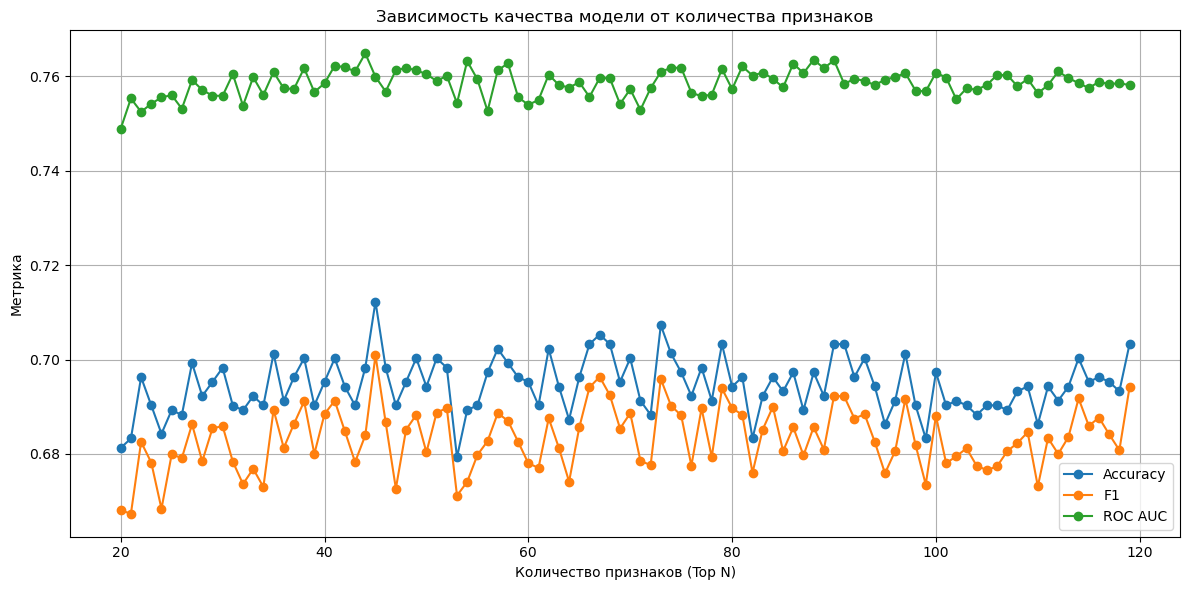


Максимальные значения метрик:
Accuracy    45
F1          45
ROC AUC     44
dtype: int64

Соответствующие значения:
                Accuracy        F1   ROC AUC
Top N Features                              
45              0.712264  0.700893  0.759902
45              0.712264  0.700893  0.759902
44              0.698259  0.683927  0.764877


In [15]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.base import clone

# Очистка
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.drop(columns=['Unnamed_0'], errors='ignore', inplace=True)

def evaluate_with_feature_selection(df_input, target_col='SI', n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    metric_per_n_features = {n: {"Accuracy": [], "F1": [], "ROC AUC": []} for n in range(20, 120, 1)}

    for fold, (train_idx, test_idx) in enumerate(kf.split(df_input), 1):
        print(f"\n--- Fold {fold} ---")

        X_train_base = df_input.iloc[train_idx].drop(columns=[target_col]).copy()
        X_test_base = df_input.iloc[test_idx].drop(columns=[target_col]).copy()
        y_train_base = df_input.iloc[train_idx][target_col]
        y_test_base = df_input.iloc[test_idx][target_col]

        # --- Регрессии для log_IC50 и log_CC50 ---
        imp = SimpleImputer(strategy='mean')
        X_train_imp = pd.DataFrame(imp.fit_transform(X_train_base), columns=X_train_base.columns)
        X_test_imp = pd.DataFrame(imp.transform(X_test_base), columns=X_test_base.columns)

        model_ic50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')
        model_cc50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')

        model_ic50.fit(X_train_imp, y_train_base)
        model_cc50.fit(X_train_imp, y_train_base)

        X_train_base['log_IC50'] = model_ic50.predict(X_train_imp)
        X_test_base['log_IC50'] = model_ic50.predict(X_test_imp)

        X_train_base['log_CC50'] = model_cc50.predict(X_train_imp)
        X_test_base['log_CC50'] = model_cc50.predict(X_test_imp)

        y_train_bin = (y_train_base > y_train_base.median()).astype(int)
        y_test_bin = (y_test_base > y_train_base.median()).astype(int)

        # Импутация и масштабирование
        imp_cls = SimpleImputer(strategy='mean')
        scaler = RobustScaler()

        X_train_filled = pd.DataFrame(imp_cls.fit_transform(X_train_base), columns=X_train_base.columns)
        X_test_filled = pd.DataFrame(imp_cls.transform(X_test_base), columns=X_test_base.columns)

        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_filled), columns=X_train_base.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test_filled), columns=X_test_base.columns)

        # --- Feature importance ---
        base_clf = CatBoostClassifier(
            depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
            verbose=0, task_type='GPU', random_state=42
        )
        base_clf.fit(X_train_scaled, y_train_bin)
        importances = pd.Series(base_clf.feature_importances_, index=X_train_scaled.columns)
        importances_sorted = importances.sort_values(ascending=False)

        # --- Перебор количества признаков ---
        for n in range(20, 120, 1):
            top_n_features = importances_sorted.iloc[:n].index.tolist()

            clf = clone(base_clf)
            clf.fit(X_train_scaled[top_n_features], y_train_bin)

            y_pred = clf.predict(X_test_scaled[top_n_features])
            y_proba = clf.predict_proba(X_test_scaled[top_n_features])[:, 1]

            metric_per_n_features[n]["Accuracy"].append(accuracy_score(y_test_bin, y_pred))
            metric_per_n_features[n]["F1"].append(f1_score(y_test_bin, y_pred))
            metric_per_n_features[n]["ROC AUC"].append(roc_auc_score(y_test_bin, y_proba))

    # --- Средние значения по фолдам ---
    avg_metrics = pd.DataFrame({
        n: {metric: np.mean(scores) for metric, scores in metric_per_n_features[n].items()}
        for n in metric_per_n_features
    }).T
    avg_metrics.index.name = "Top N Features"

    # --- Визуализация ---
    plt.figure(figsize=(12, 6))
    for metric in ["Accuracy", "F1", "ROC AUC"]:
        plt.plot(avg_metrics.index, avg_metrics[metric], marker='o', label=metric)
    plt.xlabel("Количество признаков (Top N)")
    plt.ylabel("Метрика")
    plt.title("Зависимость качества модели от количества признаков")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nМаксимальные значения метрик:")
    print(avg_metrics.idxmax())
    print("\nСоответствующие значения:")
    print(avg_metrics.loc[avg_metrics.idxmax()])

    return avg_metrics

# --- Запуск ---
results = evaluate_with_feature_selection(df, target_col='SI')



--- Fold 1 ---

--- Fold 2 ---

--- Fold 3 ---

--- Fold 4 ---

--- Fold 5 ---


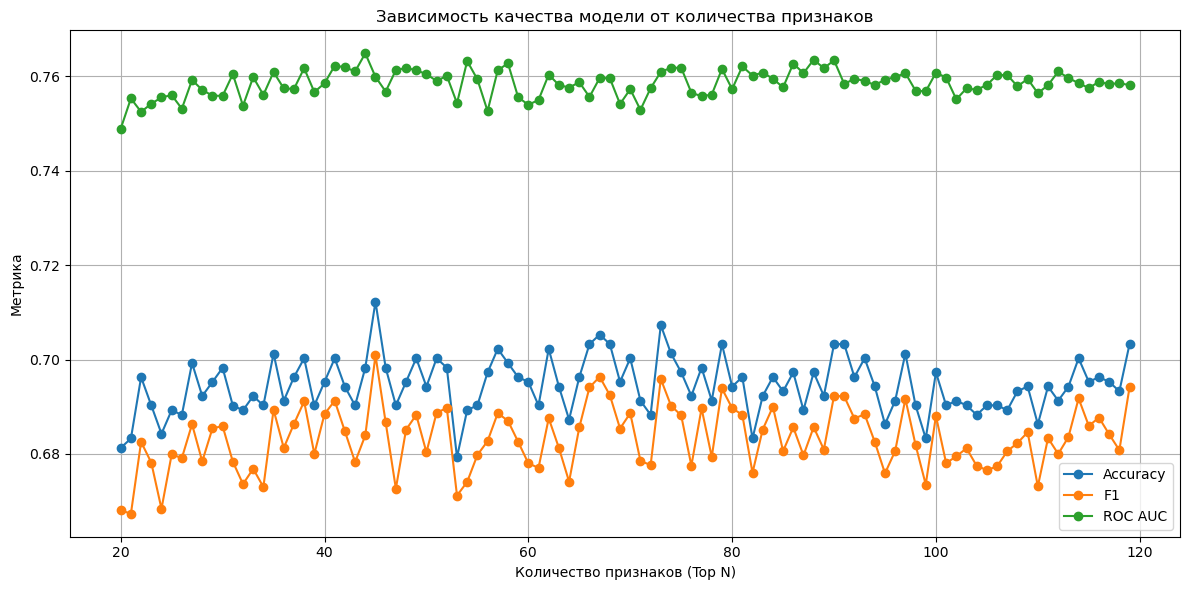


Максимальные значения метрик:
Accuracy    45
F1          45
ROC AUC     44
dtype: int64

Соответствующие значения:
                Accuracy        F1   ROC AUC
Top N Features                              
45              0.712264  0.700893  0.759902
45              0.712264  0.700893  0.759902
44              0.698259  0.683927  0.764877

Лучшие Top N для каждой метрики:
Accuracy    45
F1          45
ROC AUC     44
dtype: int64

=== Метрика: Accuracy - Top N признаков: 45 ===
Accuracy: 0.6219
Precision: 0.6429
Recall: 0.5400
F1 Score: 0.5870
ROC AUC: 0.6945

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.70      0.65       101
           1       0.64      0.54      0.59       100

    accuracy                           0.62       201
   macro avg       0.62      0.62      0.62       201
weighted avg       0.62      0.62      0.62       201



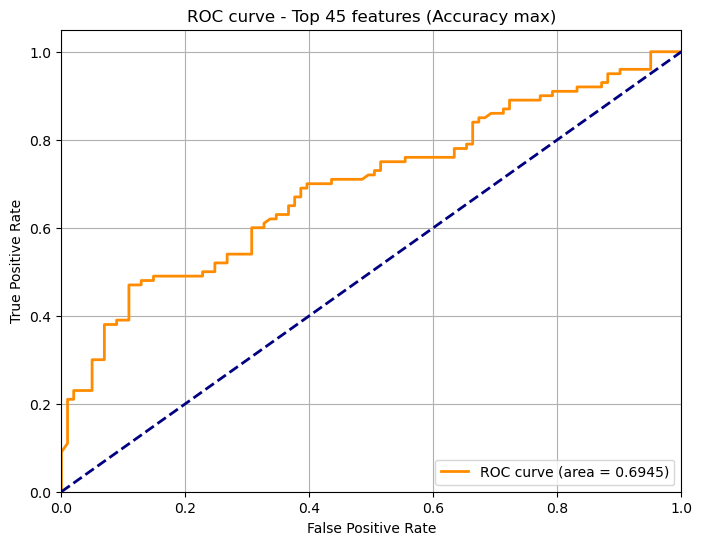


=== Метрика: F1 - Top N признаков: 45 ===
Accuracy: 0.6219
Precision: 0.6429
Recall: 0.5400
F1 Score: 0.5870
ROC AUC: 0.6945

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.70      0.65       101
           1       0.64      0.54      0.59       100

    accuracy                           0.62       201
   macro avg       0.62      0.62      0.62       201
weighted avg       0.62      0.62      0.62       201



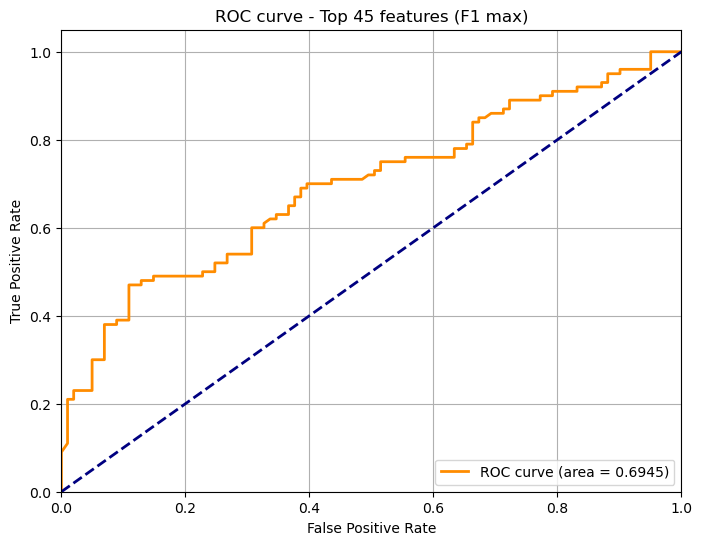


=== Метрика: ROC AUC - Top N признаков: 44 ===
Accuracy: 0.6567
Precision: 0.7013
Recall: 0.5400
F1 Score: 0.6102
ROC AUC: 0.7051

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.77      0.69       101
           1       0.70      0.54      0.61       100

    accuracy                           0.66       201
   macro avg       0.67      0.66      0.65       201
weighted avg       0.66      0.66      0.65       201



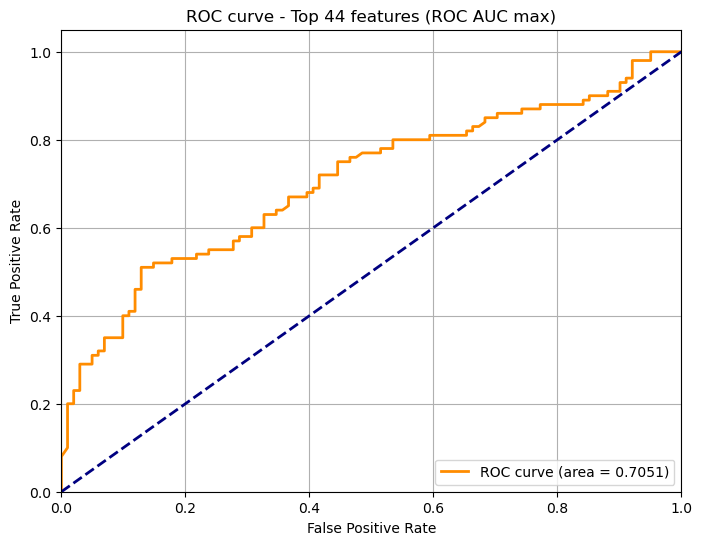

In [36]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    roc_curve, auc
)
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.base import clone

# Очистка данных
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.drop(columns=['Unnamed_0'], errors='ignore', inplace=True)

def evaluate_with_feature_selection(df_input, target_col='SI', n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    metric_per_n_features = {n: {"Accuracy": [], "F1": [], "ROC AUC": []} for n in range(20, 120, 1)}

    for fold, (train_idx, test_idx) in enumerate(kf.split(df_input), 1):
        print(f"\n--- Fold {fold} ---")

        X_train_base = df_input.iloc[train_idx].drop(columns=[target_col]).copy()
        X_test_base = df_input.iloc[test_idx].drop(columns=[target_col]).copy()
        y_train_base = df_input.iloc[train_idx][target_col]
        y_test_base = df_input.iloc[test_idx][target_col]

        # Регрессии для log_IC50 и log_CC50
        imp = SimpleImputer(strategy='mean')
        X_train_imp = pd.DataFrame(imp.fit_transform(X_train_base), columns=X_train_base.columns)
        X_test_imp = pd.DataFrame(imp.transform(X_test_base), columns=X_test_base.columns)

        model_ic50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')
        model_cc50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')

        model_ic50.fit(X_train_imp, y_train_base)
        model_cc50.fit(X_train_imp, y_train_base)

        X_train_base['log_IC50'] = model_ic50.predict(X_train_imp)
        X_test_base['log_IC50'] = model_ic50.predict(X_test_imp)

        X_train_base['log_CC50'] = model_cc50.predict(X_train_imp)
        X_test_base['log_CC50'] = model_cc50.predict(X_test_imp)

        y_train_bin = (y_train_base > y_train_base.median()).astype(int)
        y_test_bin = (y_test_base > y_train_base.median()).astype(int)

        # Импутация и масштабирование
        imp_cls = SimpleImputer(strategy='mean')
        scaler = RobustScaler()

        X_train_filled = pd.DataFrame(imp_cls.fit_transform(X_train_base), columns=X_train_base.columns)
        X_test_filled = pd.DataFrame(imp_cls.transform(X_test_base), columns=X_test_base.columns)

        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_filled), columns=X_train_base.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test_filled), columns=X_test_base.columns)

        # Feature importance
        base_clf = CatBoostClassifier(
            depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
            verbose=0, task_type='GPU', random_state=42
        )
        base_clf.fit(X_train_scaled, y_train_bin)
        importances = pd.Series(base_clf.feature_importances_, index=X_train_scaled.columns)
        importances_sorted = importances.sort_values(ascending=False)

        # Перебор количества признаков
        for n in range(20, 120, 1):
            top_n_features = importances_sorted.iloc[:n].index.tolist()

            clf = clone(base_clf)
            clf.fit(X_train_scaled[top_n_features], y_train_bin)

            y_pred = clf.predict(X_test_scaled[top_n_features])
            y_proba = clf.predict_proba(X_test_scaled[top_n_features])[:, 1]

            metric_per_n_features[n]["Accuracy"].append(accuracy_score(y_test_bin, y_pred))
            metric_per_n_features[n]["F1"].append(f1_score(y_test_bin, y_pred))
            metric_per_n_features[n]["ROC AUC"].append(roc_auc_score(y_test_bin, y_proba))

    # Средние значения по фолдам
    avg_metrics = pd.DataFrame({
        n: {metric: np.mean(scores) for metric, scores in metric_per_n_features[n].items()}
        for n in metric_per_n_features
    }).T
    avg_metrics.index.name = "Top N Features"

    # Визуализация
    plt.figure(figsize=(12, 6))
    for metric in ["Accuracy", "F1", "ROC AUC"]:
        plt.plot(avg_metrics.index, avg_metrics[metric], marker='o', label=metric)
    plt.xlabel("Количество признаков (Top N)")
    plt.ylabel("Метрика")
    plt.title("Зависимость качества модели от количества признаков")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nМаксимальные значения метрик:")
    print(avg_metrics.idxmax())
    print("\nСоответствующие значения:")
    print(avg_metrics.loc[avg_metrics.idxmax()])

    return avg_metrics

# Запуск оценки с кросс-валидацией
results = evaluate_with_feature_selection(df, target_col='SI')


# --- Вывод classification report и ROC-кривой для лучших Top N признаков ---

from sklearn.metrics import classification_report, roc_curve, auc

# Найдем лучший Top N для каждой метрики
best_top_n = results.idxmax()
print("\nЛучшие Top N для каждой метрики:")
print(best_top_n)

# Используем 80/20 разбиение всего датасета для финального теста
X = df.drop(columns=['SI']).copy()
y = df['SI']

# Регрессии для log_IC50 и log_CC50 (весь датасет)
imp = SimpleImputer(strategy='mean')
X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns)

model_ic50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')
model_cc50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')

model_ic50.fit(X_imp, y)
model_cc50.fit(X_imp, y)

X['log_IC50'] = model_ic50.predict(X_imp)
X['log_CC50'] = model_cc50.predict(X_imp)

y_bin = (y > y.median()).astype(int)

X_train_base, X_test_base, y_train_bin, y_test_bin = train_test_split(
    X, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

imp_cls = SimpleImputer(strategy='mean')
scaler = RobustScaler()

X_train_filled = pd.DataFrame(imp_cls.fit_transform(X_train_base), columns=X_train_base.columns)
X_test_filled = pd.DataFrame(imp_cls.transform(X_test_base), columns=X_test_base.columns)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_filled), columns=X_train_base.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_filled), columns=X_test_base.columns)

# Обучаем модель для определения важности признаков на тренировке
base_clf = CatBoostClassifier(
    depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
    verbose=0, task_type='GPU', random_state=42
)
base_clf.fit(X_train_scaled, y_train_bin)

importances = pd.Series(base_clf.feature_importances_, index=X_train_scaled.columns)
importances_sorted = importances.sort_values(ascending=False)

# Выводим метрики и отчеты для каждого максимума метрики
for metric in ["Accuracy", "F1", "ROC AUC"]:
    top_n = best_top_n[metric]
    print(f"\n=== Метрика: {metric} - Top N признаков: {top_n} ===")
    
    top_features = importances_sorted.iloc[:top_n].index.tolist()
    
    clf = CatBoostClassifier(
        depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
        verbose=0, task_type='GPU', random_state=42
    )
    clf.fit(X_train_scaled[top_features], y_train_bin)
    
    y_pred = clf.predict(X_test_scaled[top_features])
    y_proba = clf.predict_proba(X_test_scaled[top_features])[:, 1]
    
    acc = accuracy_score(y_test_bin, y_pred)
    prec = precision_score(y_test_bin, y_pred)
    rec = recall_score(y_test_bin, y_pred)
    f1 = f1_score(y_test_bin, y_pred)
    roc_auc = roc_auc_score(y_test_bin, y_proba)
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}\n")
    
    print("Classification Report:")
    print(classification_report(y_test_bin, y_pred))
    
    # ROC кривая
    fpr, tpr, _ = roc_curve(y_test_bin, y_proba)
    roc_auc_val = auc(fpr, tpr)
    
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve - Top {top_n} features ({metric} max)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()



--- Fold 1 ---

--- Fold 2 ---

--- Fold 3 ---

--- Fold 4 ---

--- Fold 5 ---


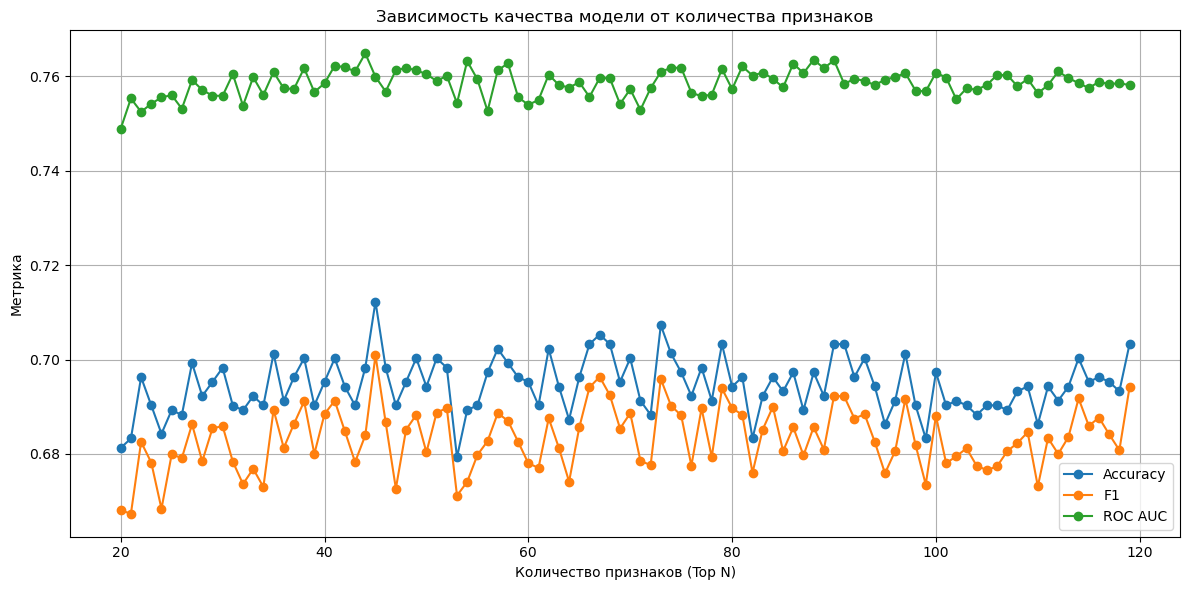


Максимальные значения метрик:
Accuracy    45
F1          45
ROC AUC     44
dtype: int64

Соответствующие значения:
                Accuracy        F1   ROC AUC
Top N Features                              
45              0.712264  0.700893  0.759902
45              0.712264  0.700893  0.759902
44              0.698259  0.683927  0.764877

Лучшие Top N для каждой метрики:
Accuracy    45
F1          45
ROC AUC     44
dtype: int64

=== Метрика: Accuracy - Top N признаков: 45 ===
Accuracy: 0.6766
Precision: 0.7215
Recall: 0.5700
F1 Score: 0.6369
ROC AUC: 0.7048

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       101
           1       0.72      0.57      0.64       100

    accuracy                           0.68       201
   macro avg       0.68      0.68      0.67       201
weighted avg       0.68      0.68      0.67       201



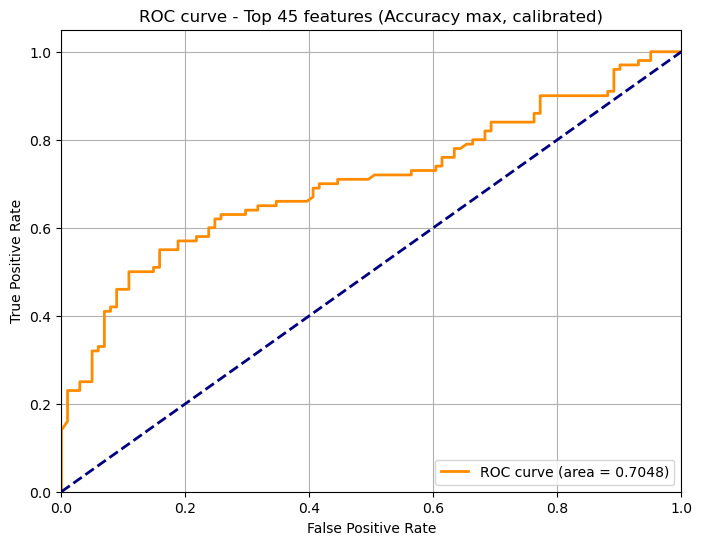


=== Метрика: F1 - Top N признаков: 45 ===
Accuracy: 0.6766
Precision: 0.7215
Recall: 0.5700
F1 Score: 0.6369
ROC AUC: 0.7048

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       101
           1       0.72      0.57      0.64       100

    accuracy                           0.68       201
   macro avg       0.68      0.68      0.67       201
weighted avg       0.68      0.68      0.67       201



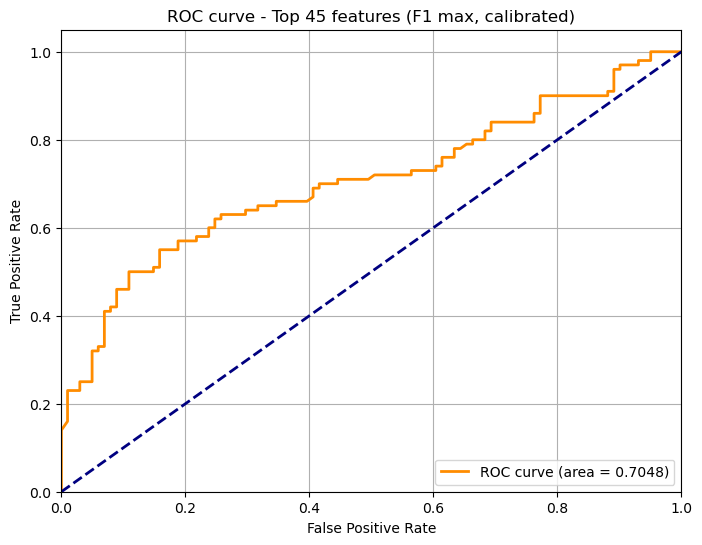


=== Метрика: ROC AUC - Top N признаков: 44 ===
Accuracy: 0.6667
Precision: 0.7089
Recall: 0.5600
F1 Score: 0.6257
ROC AUC: 0.7019

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.77      0.70       101
           1       0.71      0.56      0.63       100

    accuracy                           0.67       201
   macro avg       0.67      0.67      0.66       201
weighted avg       0.67      0.67      0.66       201



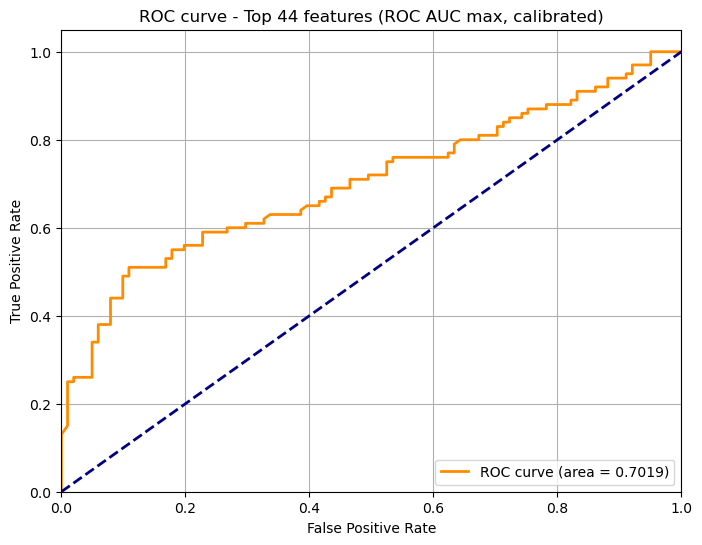

In [45]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    roc_curve, auc
)
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV

# Очистка данных
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.drop(columns=['Unnamed_0'], errors='ignore', inplace=True)

def evaluate_with_feature_selection(df_input, target_col='SI', n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    metric_per_n_features = {n: {"Accuracy": [], "F1": [], "ROC AUC": []} for n in range(20, 120, 1)}

    for fold, (train_idx, test_idx) in enumerate(kf.split(df_input), 1):
        print(f"\n--- Fold {fold} ---")

        X_train_base = df_input.iloc[train_idx].drop(columns=[target_col]).copy()
        X_test_base = df_input.iloc[test_idx].drop(columns=[target_col]).copy()
        y_train_base = df_input.iloc[train_idx][target_col]
        y_test_base = df_input.iloc[test_idx][target_col]

        imp = SimpleImputer(strategy='mean')
        X_train_imp = pd.DataFrame(imp.fit_transform(X_train_base), columns=X_train_base.columns)
        X_test_imp = pd.DataFrame(imp.transform(X_test_base), columns=X_test_base.columns)

        model_ic50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')
        model_cc50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')

        model_ic50.fit(X_train_imp, y_train_base)
        model_cc50.fit(X_train_imp, y_train_base)

        X_train_base['log_IC50'] = model_ic50.predict(X_train_imp)
        X_test_base['log_IC50'] = model_ic50.predict(X_test_imp)

        X_train_base['log_CC50'] = model_cc50.predict(X_train_imp)
        X_test_base['log_CC50'] = model_cc50.predict(X_test_imp)

        y_train_bin = (y_train_base > y_train_base.median()).astype(int)
        y_test_bin = (y_test_base > y_train_base.median()).astype(int)

        imp_cls = SimpleImputer(strategy='mean')
        scaler = RobustScaler()

        X_train_filled = pd.DataFrame(imp_cls.fit_transform(X_train_base), columns=X_train_base.columns)
        X_test_filled = pd.DataFrame(imp_cls.transform(X_test_base), columns=X_test_base.columns)

        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_filled), columns=X_train_base.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test_filled), columns=X_test_base.columns)

        base_clf = CatBoostClassifier(
            depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
            verbose=0, task_type='GPU', random_state=42
        )
        base_clf.fit(X_train_scaled, y_train_bin)
        importances = pd.Series(base_clf.feature_importances_, index=X_train_scaled.columns)
        importances_sorted = importances.sort_values(ascending=False)

        for n in range(20, 120, 1):
            top_n_features = importances_sorted.iloc[:n].index.tolist()

            clf = clone(base_clf)
            clf.fit(X_train_scaled[top_n_features], y_train_bin)

            y_pred = clf.predict(X_test_scaled[top_n_features])
            y_proba = clf.predict_proba(X_test_scaled[top_n_features])[:, 1]

            metric_per_n_features[n]["Accuracy"].append(accuracy_score(y_test_bin, y_pred))
            metric_per_n_features[n]["F1"].append(f1_score(y_test_bin, y_pred))
            metric_per_n_features[n]["ROC AUC"].append(roc_auc_score(y_test_bin, y_proba))

    avg_metrics = pd.DataFrame({
        n: {metric: np.mean(scores) for metric, scores in metric_per_n_features[n].items()}
        for n in metric_per_n_features
    }).T
    avg_metrics.index.name = "Top N Features"

    plt.figure(figsize=(12, 6))
    for metric in ["Accuracy", "F1", "ROC AUC"]:
        plt.plot(avg_metrics.index, avg_metrics[metric], marker='o', label=metric)
    plt.xlabel("Количество признаков (Top N)")
    plt.ylabel("Метрика")
    plt.title("Зависимость качества модели от количества признаков")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nМаксимальные значения метрик:")
    print(avg_metrics.idxmax())
    print("\nСоответствующие значения:")
    print(avg_metrics.loc[avg_metrics.idxmax()])

    return avg_metrics

# Запуск оценки
results = evaluate_with_feature_selection(df, target_col='SI')

# --- Финальная проверка с Platt scaling ---
from sklearn.calibration import CalibratedClassifierCV

best_top_n = results.idxmax()
print("\nЛучшие Top N для каждой метрики:")
print(best_top_n)

X = df.drop(columns=['SI']).copy()
y = df['SI']

imp = SimpleImputer(strategy='mean')
X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns)

model_ic50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')
model_cc50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')

model_ic50.fit(X_imp, y)
model_cc50.fit(X_imp, y)

X['log_IC50'] = model_ic50.predict(X_imp)
X['log_CC50'] = model_cc50.predict(X_imp)

y_bin = (y > y.median()).astype(int)

X_train_base, X_test_base, y_train_bin, y_test_bin = train_test_split(
    X, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

imp_cls = SimpleImputer(strategy='mean')
scaler = RobustScaler()

X_train_filled = pd.DataFrame(imp_cls.fit_transform(X_train_base), columns=X_train_base.columns)
X_test_filled = pd.DataFrame(imp_cls.transform(X_test_base), columns=X_test_base.columns)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_filled), columns=X_train_base.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_filled), columns=X_test_base.columns)

base_clf = CatBoostClassifier(
    depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
    verbose=0, task_type='GPU', random_state=42
)
base_clf.fit(X_train_scaled, y_train_bin)

importances = pd.Series(base_clf.feature_importances_, index=X_train_scaled.columns)
importances_sorted = importances.sort_values(ascending=False)

# Финальная проверка для каждой метрики с калибровкой
for metric in ["Accuracy", "F1", "ROC AUC"]:
    top_n = best_top_n[metric]
    print(f"\n=== Метрика: {metric} - Top N признаков: {top_n} ===")
    
    top_features = importances_sorted.iloc[:top_n].index.tolist()
    
    clf_raw = CatBoostClassifier(
        depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
        verbose=0, task_type='GPU', random_state=42
    )
    clf_calibrated = CalibratedClassifierCV(clf_raw, method='sigmoid', cv=3)
    clf_calibrated.fit(X_train_scaled[top_features], y_train_bin)
    
    y_pred = clf_calibrated.predict(X_test_scaled[top_features])
    y_proba = clf_calibrated.predict_proba(X_test_scaled[top_features])[:, 1]
    
    acc = accuracy_score(y_test_bin, y_pred)
    prec = precision_score(y_test_bin, y_pred)
    rec = recall_score(y_test_bin, y_pred)
    f1 = f1_score(y_test_bin, y_pred)
    roc_auc = roc_auc_score(y_test_bin, y_proba)
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}\n")
    
    print("Classification Report:")
    print(classification_report(y_test_bin, y_pred))
    
    fpr, tpr, _ = roc_curve(y_test_bin, y_proba)
    roc_auc_val = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve - Top {top_n} features ({metric} max, calibrated)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


Classification Report (Test set):
              precision    recall  f1-score   support

           0     0.5776    0.6700    0.6204       100
           1     0.6118    0.5149    0.5591       101

    accuracy                         0.5920       201
   macro avg     0.5947    0.5924    0.5898       201
weighted avg     0.5948    0.5920    0.5896       201

Accuracy: 0.5920
F1 Score: 0.5591
ROC AUC: 0.6700


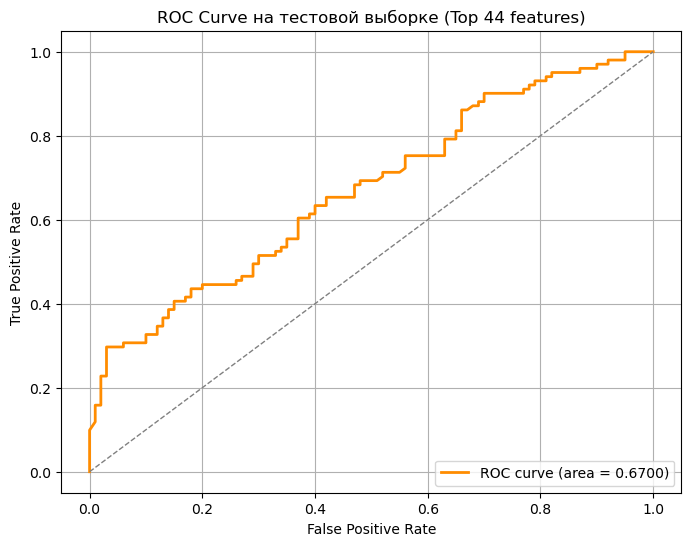

In [32]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report,
    roc_curve
)
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.base import clone

# Предобработка данных (пример для df)
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.drop(columns=['Unnamed_0'], errors='ignore', inplace=True)

# Бинаризация таргета по медиане
y_bin = (df['SI'] > df['SI'].median()).astype(int)

# Разделение на train/test (80/20)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=y_bin)

# --- Обработка train ---

X_train_base = df_train.drop(columns=['SI'])
y_train_base = df_train['SI']

# Импутация
imp = SimpleImputer(strategy='mean')
X_train_imp = pd.DataFrame(imp.fit_transform(X_train_base), columns=X_train_base.columns)

# Обучение регрессоров для дополнительных признаков
model_ic50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')
model_cc50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')

model_ic50.fit(X_train_imp, y_train_base)
model_cc50.fit(X_train_imp, y_train_base)

X_train_base['log_IC50'] = model_ic50.predict(X_train_imp)
X_train_base['log_CC50'] = model_cc50.predict(X_train_imp)

y_train_bin = (y_train_base > y_train_base.median()).astype(int)

# Импутация и масштабирование
imp_cls = SimpleImputer(strategy='mean')
scaler = RobustScaler()

X_train_filled = pd.DataFrame(imp_cls.fit_transform(X_train_base), columns=X_train_base.columns)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_filled), columns=X_train_base.columns)

# Обучение классификатора для получения важности признаков
clf_base = CatBoostClassifier(
    depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
    verbose=0, task_type='GPU', random_state=42
)
clf_base.fit(X_train_scaled, y_train_bin)

importances = pd.Series(clf_base.feature_importances_, index=X_train_scaled.columns)
importances_sorted = importances.sort_values(ascending=False)
top_features = importances_sorted.iloc[:45].index.tolist()

# --- Обработка test ---

X_test_base = df_test.drop(columns=['SI'])
y_test_base = df_test['SI']
y_test_bin = (y_test_base > y_train_base.median()).astype(int)  # по медиане train

X_test_imp = pd.DataFrame(imp.transform(X_test_base), columns=X_test_base.columns)

X_test_base['log_IC50'] = model_ic50.predict(X_test_imp)
X_test_base['log_CC50'] = model_cc50.predict(X_test_imp)

X_test_filled = pd.DataFrame(imp_cls.transform(X_test_base), columns=X_test_base.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_filled), columns=X_test_base.columns)

# --- Финальное обучение на топ-44 признаках ---
clf_final = clone(clf_base)
clf_final.fit(X_train_scaled[top_features], y_train_bin)

# Предсказания на тесте
y_test_pred = clf_final.predict(X_test_scaled[top_features])
y_test_proba = clf_final.predict_proba(X_test_scaled[top_features])[:, 1]

# Метрики
acc = accuracy_score(y_test_bin, y_test_pred)
f1 = f1_score(y_test_bin, y_test_pred)
roc_auc = roc_auc_score(y_test_bin, y_test_proba)

print("Classification Report (Test set):")
print(classification_report(y_test_bin, y_test_pred, digits=4))
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# ROC кривая
fpr, tpr, _ = roc_curve(y_test_bin, y_test_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve на тестовой выборке (Top 44 features)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



--- Fold 1 ---

--- Fold 2 ---

--- Fold 3 ---

--- Fold 4 ---

--- Fold 5 ---


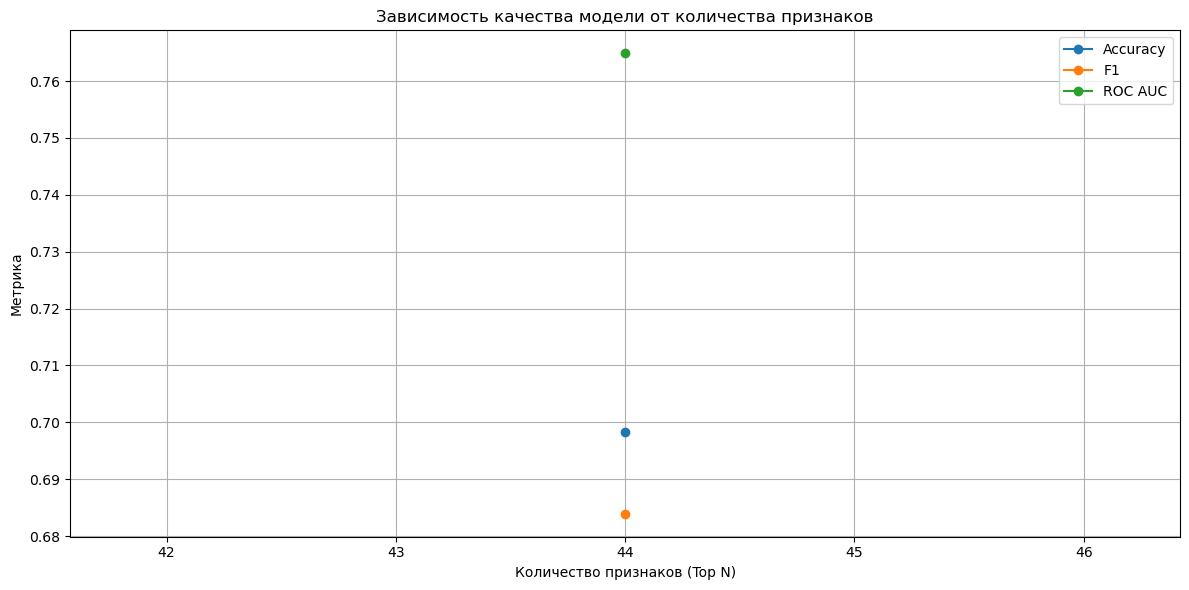


Максимальные значения метрик:
Accuracy    44
F1          44
ROC AUC     44
dtype: int64

Соответствующие значения:
                Accuracy        F1   ROC AUC
Top N Features                              
44              0.698259  0.683927  0.764877
44              0.698259  0.683927  0.764877
44              0.698259  0.683927  0.764877


In [18]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.base import clone

# Очистка
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.drop(columns=['Unnamed_0'], errors='ignore', inplace=True)

def evaluate_with_feature_selection(df_input, target_col='SI', n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    metric_per_n_features = {n: {"Accuracy": [], "F1": [], "ROC AUC": []} for n in range(44, 45, 1)}

    for fold, (train_idx, test_idx) in enumerate(kf.split(df_input), 1):
        print(f"\n--- Fold {fold} ---")

        X_train_base = df_input.iloc[train_idx].drop(columns=[target_col]).copy()
        X_test_base = df_input.iloc[test_idx].drop(columns=[target_col]).copy()
        y_train_base = df_input.iloc[train_idx][target_col]
        y_test_base = df_input.iloc[test_idx][target_col]

        # --- Регрессии для log_IC50 и log_CC50 ---
        imp = SimpleImputer(strategy='mean')
        X_train_imp = pd.DataFrame(imp.fit_transform(X_train_base), columns=X_train_base.columns)
        X_test_imp = pd.DataFrame(imp.transform(X_test_base), columns=X_test_base.columns)

        model_ic50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')
        model_cc50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')

        model_ic50.fit(X_train_imp, y_train_base)
        model_cc50.fit(X_train_imp, y_train_base)

        X_train_base['log_IC50'] = model_ic50.predict(X_train_imp)
        X_test_base['log_IC50'] = model_ic50.predict(X_test_imp)

        X_train_base['log_CC50'] = model_cc50.predict(X_train_imp)
        X_test_base['log_CC50'] = model_cc50.predict(X_test_imp)

        y_train_bin = (y_train_base > y_train_base.median()).astype(int)
        y_test_bin = (y_test_base > y_train_base.median()).astype(int)

        # Импутация и масштабирование
        imp_cls = SimpleImputer(strategy='mean')
        scaler = RobustScaler()

        X_train_filled = pd.DataFrame(imp_cls.fit_transform(X_train_base), columns=X_train_base.columns)
        X_test_filled = pd.DataFrame(imp_cls.transform(X_test_base), columns=X_test_base.columns)

        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_filled), columns=X_train_base.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test_filled), columns=X_test_base.columns)

        # --- Feature importance ---
        base_clf = CatBoostClassifier(
            depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
            verbose=0, task_type='GPU', random_state=42
        )
        base_clf.fit(X_train_scaled, y_train_bin)
        importances = pd.Series(base_clf.feature_importances_, index=X_train_scaled.columns)
        importances_sorted = importances.sort_values(ascending=False)

        # --- Перебор количества признаков ---
        for n in range(44, 45, 1):
            top_n_features = importances_sorted.iloc[:n].index.tolist()

            clf = clone(base_clf)
            clf.fit(X_train_scaled[top_n_features], y_train_bin)

            y_pred = clf.predict(X_test_scaled[top_n_features])
            y_proba = clf.predict_proba(X_test_scaled[top_n_features])[:, 1]

            metric_per_n_features[n]["Accuracy"].append(accuracy_score(y_test_bin, y_pred))
            metric_per_n_features[n]["F1"].append(f1_score(y_test_bin, y_pred))
            metric_per_n_features[n]["ROC AUC"].append(roc_auc_score(y_test_bin, y_proba))

    # --- Средние значения по фолдам ---
    avg_metrics = pd.DataFrame({
        n: {metric: np.mean(scores) for metric, scores in metric_per_n_features[n].items()}
        for n in metric_per_n_features
    }).T
    avg_metrics.index.name = "Top N Features"

    # --- Визуализация ---
    plt.figure(figsize=(12, 6))
    for metric in ["Accuracy", "F1", "ROC AUC"]:
        plt.plot(avg_metrics.index, avg_metrics[metric], marker='o', label=metric)
    plt.xlabel("Количество признаков (Top N)")
    plt.ylabel("Метрика")
    plt.title("Зависимость качества модели от количества признаков")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nМаксимальные значения метрик:")
    print(avg_metrics.idxmax())
    print("\nСоответствующие значения:")
    print(avg_metrics.loc[avg_metrics.idxmax()])

    return avg_metrics

# --- Запуск ---
results = evaluate_with_feature_selection(df, target_col='SI')


=== Кросс-валидация на тренировочной части ===

--- Fold 1 ---
              precision    recall  f1-score   support

           0     0.6988    0.6824    0.6905        85
           1     0.6494    0.6667    0.6579        75

    accuracy                         0.6750       160
   macro avg     0.6741    0.6745    0.6742       160
weighted avg     0.6756    0.6750    0.6752       160


--- Fold 2 ---
              precision    recall  f1-score   support

           0     0.7632    0.6304    0.6905        92
           1     0.5952    0.7353    0.6579        68

    accuracy                         0.6750       160
   macro avg     0.6792    0.6829    0.6742       160
weighted avg     0.6918    0.6750    0.6766       160


--- Fold 3 ---
              precision    recall  f1-score   support

           0     0.6111    0.6962    0.6509        79
           1     0.6571    0.5679    0.6093        81

    accuracy                         0.6312       160
   macro avg     0.6341    0.6321

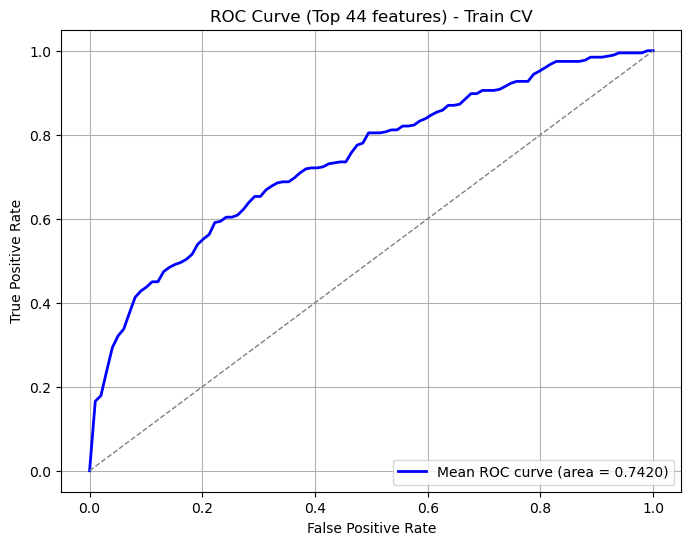


=== Обучение финальной модели на всей тренировочной части ===

--- Classification Report на тесте ---
              precision    recall  f1-score   support

           0     0.6017    0.7100    0.6514       100
           1     0.6506    0.5347    0.5870       101

    accuracy                         0.6219       201
   macro avg     0.6261    0.6223    0.6192       201
weighted avg     0.6263    0.6219    0.6190       201

Accuracy: 0.6219
F1 Score: 0.5870
ROC AUC: 0.6762


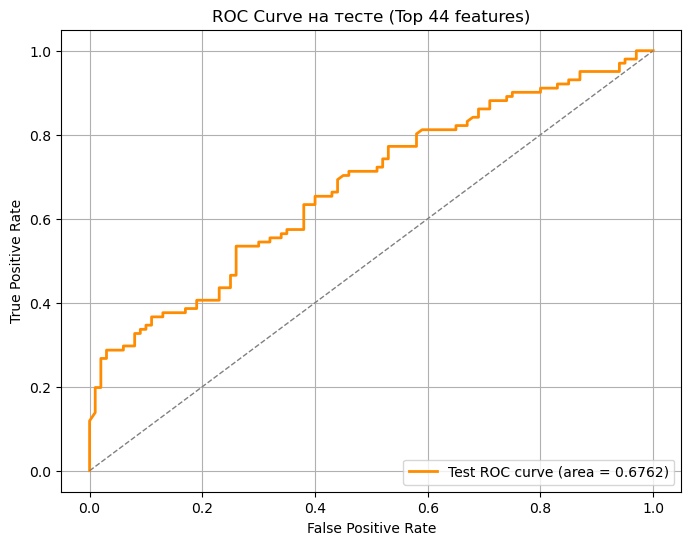

In [28]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import clone
from catboost import CatBoostClassifier, CatBoostRegressor

# Очистка колонок и данные
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.drop(columns=['Unnamed_0'], errors='ignore', inplace=True)

def evaluate_with_feature_selection_and_test(df_input, target_col='SI', n_splits=5, n_features=44, test_size=0.2):
    # Делим на train/test
    df_train, df_test = train_test_split(df_input, test_size=test_size, random_state=42, stratify=(df_input[target_col] > df_input[target_col].median()))

    # Кросс-валидация на train
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    metric_per_fold = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    print("=== Кросс-валидация на тренировочной части ===")
    for fold, (train_idx, val_idx) in enumerate(kf.split(df_train), 1):
        print(f"\n--- Fold {fold} ---")

        X_train_base = df_train.iloc[train_idx].drop(columns=[target_col]).copy()
        X_val_base = df_train.iloc[val_idx].drop(columns=[target_col]).copy()
        y_train_base = df_train.iloc[train_idx][target_col]
        y_val_base = df_train.iloc[val_idx][target_col]

        imp = SimpleImputer(strategy='mean')
        X_train_imp = pd.DataFrame(imp.fit_transform(X_train_base), columns=X_train_base.columns)
        X_val_imp = pd.DataFrame(imp.transform(X_val_base), columns=X_val_base.columns)

        model_ic50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')
        model_cc50 = CatBoostRegressor(verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU')

        model_ic50.fit(X_train_imp, y_train_base)
        model_cc50.fit(X_train_imp, y_train_base)

        X_train_base['log_IC50'] = model_ic50.predict(X_train_imp)
        X_val_base['log_IC50'] = model_ic50.predict(X_val_imp)

        X_train_base['log_CC50'] = model_cc50.predict(X_train_imp)
        X_val_base['log_CC50'] = model_cc50.predict(X_val_imp)

        y_train_bin = (y_train_base > y_train_base.median()).astype(int)
        y_val_bin = (y_val_base > y_train_base.median()).astype(int)

        imp_cls = SimpleImputer(strategy='mean')
        scaler = RobustScaler()

        X_train_filled = pd.DataFrame(imp_cls.fit_transform(X_train_base), columns=X_train_base.columns)
        X_val_filled = pd.DataFrame(imp_cls.transform(X_val_base), columns=X_val_base.columns)

        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_filled), columns=X_train_base.columns)
        X_val_scaled = pd.DataFrame(scaler.transform(X_val_filled), columns=X_val_base.columns)

        base_clf = CatBoostClassifier(
            depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
            verbose=0, task_type='GPU', random_state=42
        )
        base_clf.fit(X_train_scaled, y_train_bin)
        importances = pd.Series(base_clf.feature_importances_, index=X_train_scaled.columns)
        importances_sorted = importances.sort_values(ascending=False)

        top_features = importances_sorted.iloc[:n_features].index.tolist()

        clf = clone(base_clf)
        clf.fit(X_train_scaled[top_features], y_train_bin)

        y_pred = clf.predict(X_val_scaled[top_features])
        y_proba = clf.predict_proba(X_val_scaled[top_features])[:, 1]

        acc = accuracy_score(y_val_bin, y_pred)
        f1 = f1_score(y_val_bin, y_pred)
        roc_auc = roc_auc_score(y_val_bin, y_proba)

        metric_per_fold.append({"Accuracy": acc, "F1": f1, "ROC_AUC": roc_auc})

        print(classification_report(y_val_bin, y_pred, digits=4))

        fpr, tpr, _ = roc_curve(y_val_bin, y_proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    metrics_df = pd.DataFrame(metric_per_fold)
    print("\nСредние метрики по фолдам (train):")
    print(metrics_df.mean())

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)

    plt.figure(figsize=(8,6))
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC curve (area = {mean_auc:.4f})', lw=2)
    plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (Top {n_features} features) - Train CV')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # --- Обучение финальной модели на всем train ---
    print("\n=== Обучение финальной модели на всей тренировочной части ===")
    X_train_full = df_train.drop(columns=[target_col]).copy()
    y_train_full = df_train[target_col]
    X_test_full = df_test.drop(columns=[target_col]).copy()
    y_test_full = df_test[target_col]

    imp = SimpleImputer(strategy='mean')
    X_train_imp = pd.DataFrame(imp.fit_transform(X_train_full), columns=X_train_full.columns)
    X_test_imp = pd.DataFrame(imp.transform(X_test_full), columns=X_test_full.columns)

    model_ic50.fit(X_train_imp, y_train_full)
    model_cc50.fit(X_train_imp, y_train_full)

    X_train_full['log_IC50'] = model_ic50.predict(X_train_imp)
    X_test_full['log_IC50'] = model_ic50.predict(X_test_imp)

    X_train_full['log_CC50'] = model_cc50.predict(X_train_imp)
    X_test_full['log_CC50'] = model_cc50.predict(X_test_imp)

    y_train_bin_full = (y_train_full > y_train_full.median()).astype(int)
    y_test_bin = (y_test_full > y_train_full.median()).astype(int)

    imp_cls = SimpleImputer(strategy='mean')
    scaler = RobustScaler()

    X_train_filled = pd.DataFrame(imp_cls.fit_transform(X_train_full), columns=X_train_full.columns)
    X_test_filled = pd.DataFrame(imp_cls.transform(X_test_full), columns=X_test_full.columns)

    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_filled), columns=X_train_full.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test_filled), columns=X_test_full.columns)

    # Используем top_features из последнего фолда (можно взять средний список топ-фич)
    # Чтобы быть аккуратнее, возьмём top_features по всей тренировочной выборке заново:
    base_clf_full = CatBoostClassifier(
        depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
        verbose=0, task_type='GPU', random_state=42
    )
    base_clf_full.fit(X_train_scaled, y_train_bin_full)
    importances_full = pd.Series(base_clf_full.feature_importances_, index=X_train_scaled.columns)
    importances_sorted_full = importances_full.sort_values(ascending=False)
    top_features_full = importances_sorted_full.iloc[:n_features].index.tolist()

    clf_final = clone(base_clf_full)
    clf_final.fit(X_train_scaled[top_features_full], y_train_bin_full)

    y_test_pred = clf_final.predict(X_test_scaled[top_features_full])
    y_test_proba = clf_final.predict_proba(X_test_scaled[top_features_full])[:, 1]

    print("\n--- Classification Report на тесте ---")
    print(classification_report(y_test_bin, y_test_pred, digits=4))

    acc_test = accuracy_score(y_test_bin, y_test_pred)
    f1_test = f1_score(y_test_bin, y_test_pred)
    roc_auc_test = roc_auc_score(y_test_bin, y_test_proba)

    print(f"Accuracy: {acc_test:.4f}")
    print(f"F1 Score: {f1_test:.4f}")
    print(f"ROC AUC: {roc_auc_test:.4f}")

    fpr_test, tpr_test, _ = roc_curve(y_test_bin, y_test_proba)
    plt.figure(figsize=(8,6))
    plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.4f})')
    plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve на тесте (Top {n_features} features)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return metrics_df, {"Accuracy": acc_test, "F1": f1_test, "ROC_AUC": roc_auc_test}

# Запуск
cv_results, test_metrics = evaluate_with_feature_selection_and_test(df, target_col='SI', n_splits=5, n_features=44)


In [9]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.base import clone

# --- Предполагается, что df загружен и готов к использованию ---

# Очистка названий колонок и замена инф/минус инф на nan
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Удаление лишних колонок, если они есть
df.drop(columns=['Unnamed_0'], errors='ignore', inplace=True)

def evaluate_classifier_with_internal_regression(
    df_input,
    target_col='SI',
    ic50_col='IC50',
    cc50_col='CC50',
    n_splits=5,
    n_top_features=44
):
    df_eval = df_input.copy()

    # Проверяем наличие нужных колонок
    for col in [target_col, ic50_col, cc50_col]:
        if col not in df_eval.columns:
            raise ValueError(f"Колонка '{col}' не найдена в датафрейме")

    # Исключаем из признаков целевые колонки
    X_full = df_eval.drop(columns=[target_col, ic50_col, cc50_col])
    y_full = df_eval[target_col]
    y_ic50_full = df_eval[ic50_col]
    y_cc50_full = df_eval[cc50_col]

    # Определяем топ-признаки по важности на полном наборе
    imp_full = SimpleImputer(strategy='mean')
    scaler_full = RobustScaler()
    X_imp = pd.DataFrame(imp_full.fit_transform(X_full), columns=X_full.columns)
    X_scaled = pd.DataFrame(scaler_full.fit_transform(X_imp), columns=X_full.columns)

    clf_full = CatBoostClassifier(
        depth=6,
        iterations=100,
        l2_leaf_reg=5,
        learning_rate=0.05,
        verbose=0,
        task_type='GPU',
        random_state=42
    )
    clf_full.fit(X_scaled, y_full)

    importances = clf_full.get_feature_importance()
    feat_importance_df = pd.DataFrame({'feature': X_full.columns, 'importance': importances})
    feat_importance_df.sort_values(by='importance', ascending=False, inplace=True)

    top_features = feat_importance_df['feature'].iloc[:n_top_features].tolist()
    print(f"Топ-{n_top_features} признаков: {top_features}")

    # KFold Cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = []

    class_model = CatBoostClassifier(
        depth=6,
        iterations=100,
        l2_leaf_reg=5,
        learning_rate=0.05,
        verbose=0,
        task_type='GPU',
        random_state=42
    )

    for fold, (train_idx, test_idx) in enumerate(kf.split(X_full), 1):
        print(f"--- Fold {fold} ---")

        X_train_base = X_full.iloc[train_idx][top_features].copy()
        X_test_base = X_full.iloc[test_idx][top_features].copy()

        y_train_base = y_full.iloc[train_idx]
        y_test_base = y_full.iloc[test_idx]

        y_train_ic50 = y_ic50_full.iloc[train_idx]
        y_test_ic50 = y_ic50_full.iloc[test_idx]

        y_train_cc50 = y_cc50_full.iloc[train_idx]
        y_test_cc50 = y_cc50_full.iloc[test_idx]

        # Импутация для регрессоров
        imp_ic50 = SimpleImputer(strategy='mean')
        imp_cc50 = SimpleImputer(strategy='mean')

        X_train_ic50 = pd.DataFrame(imp_ic50.fit_transform(X_train_base), columns=top_features)
        X_train_cc50 = pd.DataFrame(imp_cc50.fit_transform(X_train_base), columns=top_features)

        # Обучаем регрессоры на соответствующих целях
        model_ic50 = CatBoostRegressor(
            verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU'
        )
        model_cc50 = CatBoostRegressor(
            verbose=0, iterations=100, depth=6, learning_rate=0.05, task_type='GPU'
        )

        model_ic50.fit(X_train_ic50, y_train_ic50)
        model_cc50.fit(X_train_cc50, y_train_cc50)

        # Предсказания регрессоров на train и test
        X_test_ic50 = pd.DataFrame(imp_ic50.transform(X_test_base), columns=top_features)
        X_test_cc50 = pd.DataFrame(imp_cc50.transform(X_test_base), columns=top_features)

        X_train_base['log_IC50'] = model_ic50.predict(X_train_ic50)
        X_test_base['log_IC50'] = model_ic50.predict(X_test_ic50)

        X_train_base['log_CC50'] = model_cc50.predict(X_train_cc50)
        X_test_base['log_CC50'] = model_cc50.predict(X_test_cc50)

        # Бинаризация таргета по медиане train
        median_train = y_train_base.median()
        y_train = (y_train_base > median_train).astype(int)
        y_test = (y_test_base > median_train).astype(int)

        # Импутация и масштабирование для классификатора
        imputer = SimpleImputer(strategy='mean')
        scaler = RobustScaler()

        X_train_imp = pd.DataFrame(imputer.fit_transform(X_train_base), columns=X_train_base.columns)
        X_test_imp = pd.DataFrame(imputer.transform(X_test_base), columns=X_test_base.columns)

        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train_base.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test_base.columns)

        # Обучение и оценка классификатора
        clf = clone(class_model)
        clf.fit(X_train_scaled, y_train)

        y_pred = clf.predict(X_test_scaled)
        y_proba = clf.predict_proba(X_test_scaled)[:, 1]

        results.append({
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC AUC": roc_auc_score(y_test, y_proba)
        })

    results_df = pd.DataFrame(results)
    print("\nСредние метрики по фолдам:")
    print(results_df.mean())

    return results_df

# --- Запуск оценки ---
results_cv = evaluate_classifier_with_internal_regression(df, target_col='SI', ic50_col='IC50', cc50_col='CC50')


ValueError: Колонка 'IC50' не найдена в датафрейме

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    HistGradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.base import clone
from matplotlib.backends.backend_pdf import PdfPages

# Очистка имен и замена inf на nan
for d in [df, df_cut, df_bin, df_cut_bin]:
    d.columns = d.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    d.replace([np.inf, -np.inf], np.nan, inplace=True)

# Стекинг с GPU-моделями
estimators_cls = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('xgb', XGBClassifier(
        random_state=42, use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist'
    )),
    ('cat', CatBoostClassifier(verbose=0, random_state=42, task_type='GPU'))
]

final_estimator_cls = LogisticRegression()
stacking_model_cls = StackingClassifier(
    estimators=estimators_cls,
    final_estimator=final_estimator_cls,
    cv=5,
    n_jobs=1
)

# Все модели
class_models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        random_state=42, use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist'
    ),
    "LightGBM": LGBMClassifier(
        device='gpu', boosting_type='gbdt', random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
        verbose=0, task_type='GPU', random_state=42
    ),
    "MLP": MLPClassifier(max_iter=1000, random_state=42),
    "NaiveBayes": GaussianNB(),
    "SVM": SVC(probability=True),
    "Stacking": stacking_model_cls
}

# Оценка моделей
def evaluate_class_models_no_leak(df_input, target_col='SI'):
    df_eval = df_input.copy().drop(columns=['Unnamed_0'], errors='ignore')
    X_full = df_eval.drop(columns=[target_col])
    y_full = df_eval[target_col]

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for name, model in tqdm(class_models.items(), desc=f"Cross-validation ({df_input.shape[1]} features)"):
        accuracies, precisions, recalls, f1s, roc_aucs = [], [], [], [], []

        for train_index, test_index in kf.split(X_full):
            X_train, X_test = X_full.iloc[train_index], X_full.iloc[test_index]
            y_train_SI, y_test_SI = y_full.iloc[train_index], y_full.iloc[test_index]

            median_train = y_train_SI.median()
            y_train = (y_train_SI > median_train).astype(int)
            y_test = (y_test_SI > median_train).astype(int)

            imputer = SimpleImputer(strategy='mean')
            scaler = RobustScaler()
            X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
            X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

            X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train.columns)
            X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test.columns)

            clf = clone(model)
            clf.fit(X_train_scaled, y_train)

            y_pred = clf.predict(X_test_scaled)
            if hasattr(clf, "predict_proba"):
                y_proba = clf.predict_proba(X_test_scaled)[:, 1]
            else:
                y_proba = clf.decision_function(X_test_scaled)
                y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

            accuracies.append(accuracy_score(y_test, y_pred))
            precisions.append(precision_score(y_test, y_pred))
            recalls.append(recall_score(y_test, y_pred))
            f1s.append(f1_score(y_test, y_pred))
            roc_aucs.append(roc_auc_score(y_test, y_proba))

        results.append({
            "Model": name,
            "Accuracy": np.mean(accuracies),
            "Precision": np.mean(precisions),
            "Recall": np.mean(recalls),
            "F1": np.mean(f1s),
            "ROC AUC": np.mean(roc_aucs)
        })

    return pd.DataFrame(results).sort_values(by="F1", ascending=False)

# Запуск оценивания
results_df = evaluate_class_models_no_leak(df, target_col='SI'); results_df['Dataset'] = 'df'
results_cut = evaluate_class_models_no_leak(df_cut, target_col='SI'); results_cut['Dataset'] = 'df_cut'
results_bin = evaluate_class_models_no_leak(df_bin, target_col='SI'); results_bin['Dataset'] = 'df_bin'
results_cut_bin = evaluate_class_models_no_leak(df_cut_bin, target_col='SI'); results_cut_bin['Dataset'] = 'df_cut_bin'
comparison_cls = pd.concat([results_df, results_cut, results_bin, results_cut_bin], ignore_index=True)

# Визуализация
with PdfPages('RI_classification_evaluation_report.pdf') as pdf:
    for metric in ['F1', 'ROC AUC']:
        plt.figure(figsize=(14, 7))
        sns.barplot(data=comparison_cls, x=metric, y='Model', hue='Dataset')
        plt.title(f"Model {metric} Comparison Across Datasets")
        plt.tight_layout()
        pdf.savefig(); plt.close()

    for dataset_name, df_scaled in zip(['df', 'df_cut', 'df_bin', 'df_cut_bin'], [df, df_cut, df_bin, df_cut_bin]):
        X = df_scaled.drop(columns=['SI', 'Unnamed_0'], errors='ignore')
        y = df_scaled['SI']

        best_model_name = comparison_cls[comparison_cls['Dataset'] == dataset_name].iloc[0]['Model']
        model = clone(class_models[best_model_name])

        X_train, X_test, y_train_SI, y_test_SI = train_test_split(X, y, test_size=0.2, random_state=42)
        median_train = y_train_SI.median()
        y_train = (y_train_SI > median_train).astype(int)
        y_test = (y_test_SI > median_train).astype(int)

        imp = SimpleImputer(strategy='mean')
        scaler = RobustScaler()
        X_train_imp = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns)
        X_test_imp = pd.DataFrame(imp.transform(X_test), columns=X_test.columns)
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test.columns)

        model.fit(X_train_scaled, y_train)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {auc(fpr, tpr):.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.title(f"ROC Curve - {dataset_name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        pdf.savefig(); plt.close()

        try:
            if hasattr(model, 'get_feature_importance'):
                importances = model.get_feature_importance(Pool(X_train_scaled, label=y_train))
            elif hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
            else:
                continue

            feature_names = X_train.columns
            feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
            feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)

            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
            plt.title(f"Top 20 Feature Importances - {best_model_name} ({dataset_name})")
            plt.tight_layout()
            pdf.savefig(); plt.close()
        except Exception as e:
            print(f"[!] Could not plot feature importances for {best_model_name} ({dataset_name}): {e}")

# Экспорт результатов
with pd.ExcelWriter("RI_classification_comparison_metrics.xlsx") as writer:
    results_df.to_excel(writer, sheet_name="df", index=False)
    results_cut.to_excel(writer, sheet_name="df_cut", index=False)
    results_bin.to_excel(writer, sheet_name="df_bin", index=False)
    results_cut_bin.to_excel(writer, sheet_name="df_cut_bin", index=False)
    comparison_cls.to_excel(writer, sheet_name="Comparison", index=False)


Cross-validation (230 features):  23%|██▎       | 3/13 [00:08<00:30,  3.03s/it]

In [10]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    HistGradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.base import clone
from matplotlib.backends.backend_pdf import PdfPages

# Очистка имен и замена inf на nan
for d in [df]:
    d.columns = d.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    d.replace([np.inf, -np.inf], np.nan, inplace=True)



# Все модели
class_models = {
   "CatBoost": CatBoostClassifier(
        depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
        verbose=0, task_type='GPU', random_state=42
    ),

}

# Оценка моделей
def evaluate_class_models_no_leak(df_input, target_col='SI'):
    df_eval = df_input.copy().drop(columns=['Unnamed_0'], errors='ignore')
    X_full = df_eval.drop(columns=[target_col])
    y_full = df_eval[target_col]

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for name, model in tqdm(class_models.items(), desc=f"Cross-validation ({df_input.shape[1]} features)"):
        accuracies, precisions, recalls, f1s, roc_aucs = [], [], [], [], []

        for train_index, test_index in kf.split(X_full):
            X_train, X_test = X_full.iloc[train_index], X_full.iloc[test_index]
            y_train_SI, y_test_SI = y_full.iloc[train_index], y_full.iloc[test_index]

            median_train = y_train_SI.median()
            y_train = (y_train_SI > median_train).astype(int)
            y_test = (y_test_SI > median_train).astype(int)

            imputer = SimpleImputer(strategy='mean')
            scaler = RobustScaler()
            X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
            X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

            X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train.columns)
            X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test.columns)

            clf = clone(model)
            clf.fit(X_train_scaled, y_train)

            y_pred = clf.predict(X_test_scaled)
            if hasattr(clf, "predict_proba"):
                y_proba = clf.predict_proba(X_test_scaled)[:, 1]
            else:
                y_proba = clf.decision_function(X_test_scaled)
                y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

            accuracies.append(accuracy_score(y_test, y_pred))
            precisions.append(precision_score(y_test, y_pred))
            recalls.append(recall_score(y_test, y_pred))
            f1s.append(f1_score(y_test, y_pred))
            roc_aucs.append(roc_auc_score(y_test, y_proba))

        results.append({
            "Model": name,
            "Accuracy": np.mean(accuracies),
            "Precision": np.mean(precisions),
            "Recall": np.mean(recalls),
            "F1": np.mean(f1s),
            "ROC AUC": np.mean(roc_aucs)
        })

    return pd.DataFrame(results).sort_values(by="F1", ascending=False)

# Запуск оценивания
results_df = evaluate_class_models_no_leak(df, target_col='SI'); results_df['Dataset'] = 'df'
print("Метрики моделей:\n")
print(results_df.to_string(index=False))



Cross-validation (228 features): 100%|██████████| 1/1 [00:07<00:00,  7.03s/it]

Метрики моделей:

   Model  Accuracy  Precision   Recall       F1  ROC AUC Dataset
CatBoost  0.677318   0.686196 0.657716 0.669717 0.731108      df


Добавляем признак log(IC50)

In [21]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm

from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

from sklearn.base import clone
from catboost import CatBoostClassifier

# --- Подготовка данных ---
# Очистка имен колонок и замена inf на nan
for d in [df]:
    d.columns = d.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    d.replace([np.inf, -np.inf], np.nan, inplace=True)

# --- Добавление признака log_IC50 ---
# Загрузка модели регрессии
reg_model_ic50 = joblib.load('regression_IC50_catboost_final_model_df_to SI_ckass.pkl')

# Загрузка признаков, использованных при обучении (если есть)
try:
    with open("features_used_in_regression_model_ic50.txt", "r") as f:
        used_features_ic50 = f.read().splitlines()
except FileNotFoundError:
    # Если список признаков не найден — пробуем все, кроме целевой и технических
    used_features_ic50 = df.drop(columns=['SI', 'Unnamed_0'], errors='ignore').columns.tolist()

# Подготовка данных
X_reg_ic50 = df[used_features_ic50].copy()
imputer_ic50 = SimpleImputer(strategy='mean')
X_reg_ic50_imp = pd.DataFrame(imputer_ic50.fit_transform(X_reg_ic50), columns=X_reg_ic50.columns)

# Прогноз и добавление признака
df['log_IC50'] = reg_model_ic50.predict(X_reg_ic50_imp)

print(" Признак 'log_IC50' успешно добавлен в DataFrame.")

# --- Классификационные модели ---
class_models = {
   "CatBoost": CatBoostClassifier(
        depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
        verbose=0, task_type='GPU', random_state=42
    ),
}

# --- Функция оценки моделей ---
def evaluate_class_models_no_leak(df_input, target_col='SI'):
    df_eval = df_input.copy().drop(columns=['Unnamed_0'], errors='ignore')
    X_full = df_eval.drop(columns=[target_col])
    y_full = df_eval[target_col]

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for name, model in tqdm(class_models.items(), desc=f"Cross-validation ({df_input.shape[1]} features)"):
        accuracies, precisions, recalls, f1s, roc_aucs = [], [], [], [], []

        for train_index, test_index in kf.split(X_full):
            X_train, X_test = X_full.iloc[train_index], X_full.iloc[test_index]
            y_train_SI, y_test_SI = y_full.iloc[train_index], y_full.iloc[test_index]

            # Бинаризация по медиане тренировочной выборки
            median_train = y_train_SI.median()
            y_train = (y_train_SI > median_train).astype(int)
            y_test = (y_test_SI > median_train).astype(int)

            # Импьютация и масштабирование
            imputer = SimpleImputer(strategy='mean')
            scaler = RobustScaler()
            X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
            X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

            X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train.columns)
            X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test.columns)

            # Обучение и предсказание
            clf = clone(model)
            clf.fit(X_train_scaled, y_train)
            y_pred = clf.predict(X_test_scaled)

            if hasattr(clf, "predict_proba"):
                y_proba = clf.predict_proba(X_test_scaled)[:, 1]
            else:
                y_proba = clf.decision_function(X_test_scaled)
                y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

            # Метрики
            accuracies.append(accuracy_score(y_test, y_pred))
            precisions.append(precision_score(y_test, y_pred))
            recalls.append(recall_score(y_test, y_pred))
            f1s.append(f1_score(y_test, y_pred))
            roc_aucs.append(roc_auc_score(y_test, y_proba))

        results.append({
            "Model": name,
            "Accuracy": np.mean(accuracies),
            "Precision": np.mean(precisions),
            "Recall": np.mean(recalls),
            "F1": np.mean(f1s),
            "ROC AUC": np.mean(roc_aucs)
        })

    return pd.DataFrame(results).sort_values(by="F1", ascending=False)

# --- Запуск ---
results_df = evaluate_class_models_no_leak(df, target_col='SI')
results_df['Dataset'] = 'df'

# --- Вывод ---
print("\nМетрики моделей:\n")
print(results_df.to_string(index=False))


✅ Признак 'log_IC50' успешно добавлен в DataFrame.


Cross-validation (229 features): 100%|██████████| 1/1 [00:07<00:00,  7.49s/it]


Метрики моделей:

   Model  Accuracy  Precision   Recall       F1  ROC AUC Dataset
CatBoost  0.731239   0.736587 0.724972 0.729461 0.803645      df


In [ ]:
Добавляем признак log(СC50)

In [30]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm

from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

from sklearn.base import clone
from catboost import CatBoostClassifier

# --- Подготовка данных ---
# Очистка имен колонок и замена inf на nan
for d in [df]:
    d.columns = d.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    d.replace([np.inf, -np.inf], np.nan, inplace=True)

# --- Добавление признака log_IC50 ---
reg_model_ic50 = joblib.load('regression_IC50_catboost_final_model_df_to SI_ckass.pkl')

try:
    with open("features_used_in_regression_model_ic50.txt", "r") as f:
        used_features_ic50 = f.read().splitlines()
except FileNotFoundError:
    used_features_ic50 = df.drop(columns=['SI', 'Unnamed_0'], errors='ignore').columns.tolist()

X_reg_ic50 = df[used_features_ic50].copy()
imputer_ic50 = SimpleImputer(strategy='mean')
X_reg_ic50_imp = pd.DataFrame(imputer_ic50.fit_transform(X_reg_ic50), columns=X_reg_ic50.columns)
df['log_IC50'] = reg_model_ic50.predict(X_reg_ic50_imp)

print("Признак 'log_IC50' успешно добавлен в DataFrame.")

# --- Добавление признака log_CC50 ---
reg_model_cc50 = joblib.load('regression_CC50_catboost_final_model_df_to_SI_class.pkl')

try:
    with open("features_used_in_regression_model_cc50.txt", "r") as f:
        used_features_cc50 = f.read().splitlines()
except FileNotFoundError:
    used_features_cc50 = df.drop(columns=['SI', 'Unnamed_0'], errors='ignore').columns.tolist()

X_reg_cc50 = df[used_features_cc50].copy()
imputer_cc50 = SimpleImputer(strategy='mean')
X_reg_cc50_imp = pd.DataFrame(imputer_cc50.fit_transform(X_reg_cc50), columns=X_reg_cc50.columns)
df['log_CC50'] = reg_model_cc50.predict(X_reg_cc50_imp)

print("Признак 'log_CC50' успешно добавлен в DataFrame.")

# --- Классификационные модели ---
class_models = {
   "CatBoost": CatBoostClassifier(
        depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
        verbose=0, task_type='GPU', random_state=42
    ),
}

# --- Функция оценки моделей ---
def evaluate_class_models_no_leak(df_input, target_col='SI'):
    df_eval = df_input.copy().drop(columns=['Unnamed_0'], errors='ignore')
    X_full = df_eval.drop(columns=[target_col])
    y_full = df_eval[target_col]

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for name, model in tqdm(class_models.items(), desc=f"Cross-validation ({df_input.shape[1]} features)"):
        accuracies, precisions, recalls, f1s, roc_aucs = [], [], [], [], []

        for train_index, test_index in kf.split(X_full):
            X_train, X_test = X_full.iloc[train_index], X_full.iloc[test_index]
            y_train_SI, y_test_SI = y_full.iloc[train_index], y_full.iloc[test_index]

            median_train = y_train_SI.median()
            y_train = (y_train_SI > median_train).astype(int)
            y_test = (y_test_SI > median_train).astype(int)

            imputer = SimpleImputer(strategy='mean')
            scaler = RobustScaler()
            X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
            X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

            X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train.columns)
            X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test.columns)

            clf = clone(model)
            clf.fit(X_train_scaled, y_train)
            y_pred = clf.predict(X_test_scaled)

            if hasattr(clf, "predict_proba"):
                y_proba = clf.predict_proba(X_test_scaled)[:, 1]
            else:
                y_proba = clf.decision_function(X_test_scaled)
                y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

            accuracies.append(accuracy_score(y_test, y_pred))
            precisions.append(precision_score(y_test, y_pred))
            recalls.append(recall_score(y_test, y_pred))
            f1s.append(f1_score(y_test, y_pred))
            roc_aucs.append(roc_auc_score(y_test, y_proba))

        results.append({
            "Model": name,
            "Accuracy": np.mean(accuracies),
            "Precision": np.mean(precisions),
            "Recall": np.mean(recalls),
            "F1": np.mean(f1s),
            "ROC AUC": np.mean(roc_aucs)
        })

    return pd.DataFrame(results).sort_values(by="F1", ascending=False)

# --- Запуск ---
results_df = evaluate_class_models_no_leak(df, target_col='SI')
results_df['Dataset'] = 'df'

# --- Вывод ---
print("\nМетрики моделей:\n")
print(results_df.to_string(index=False))


Признак 'log_IC50' успешно добавлен в DataFrame.
Признак 'log_CC50' успешно добавлен в DataFrame.


Cross-validation (230 features): 100%|██████████| 1/1 [00:07<00:00,  7.20s/it]


Метрики моделей:

   Model  Accuracy  Precision   Recall       F1  ROC AUC Dataset
CatBoost  0.780204   0.790434 0.764826 0.776665 0.853657      df


по топ признакам 

Top-N features loop: 100%|██████████| 120/120 [10:06<00:00,  5.05s/it]


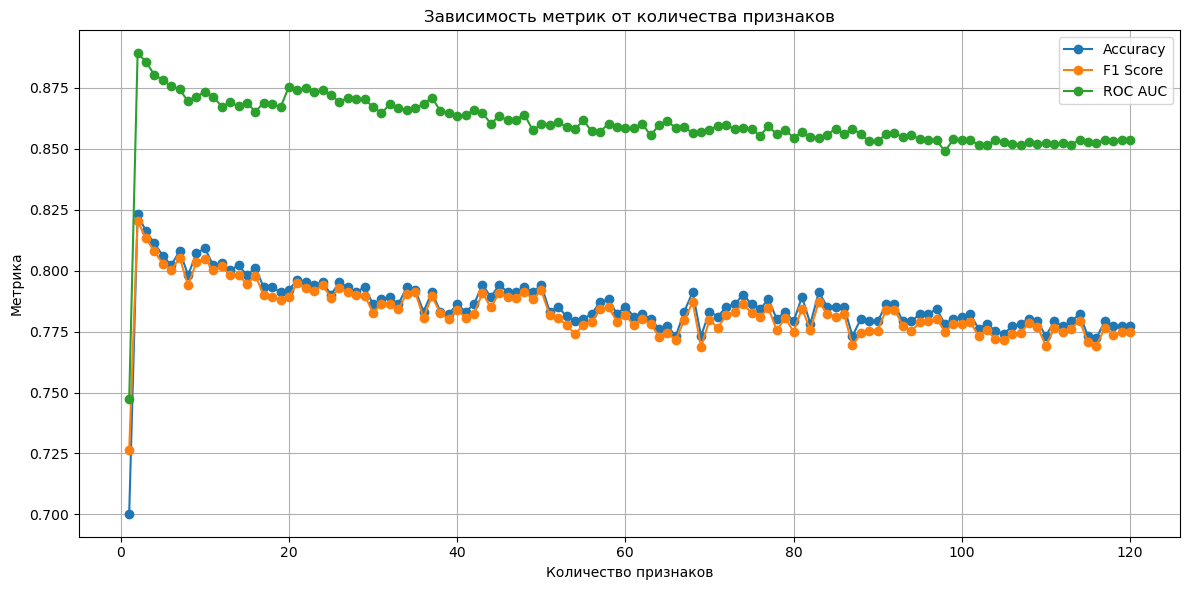

Максимальная Accuracy: 0.8232 при 2 признаках
Максимальный F1:       0.8204 при 2 признаках
Максимальный ROC AUC:  0.8892 при 2 признаках

Таблица результатов по количеству признаков:

     Num_Features  Accuracy        F1   ROC_AUC
0               1  0.700284  0.726315  0.747181
1               2  0.823159  0.820417  0.889163
2               3  0.816159  0.813238  0.885734
3               4  0.811164  0.807896  0.880237
4               5  0.806174  0.802859  0.878294
..            ...       ...       ...       ...
115           116  0.772199  0.769097  0.852414
116           117  0.779194  0.776550  0.853521
117           118  0.777204  0.773632  0.853021
118           119  0.777184  0.774876  0.853633
119           120  0.777184  0.774876  0.853633

[120 rows x 4 columns]


In [42]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm

from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

from sklearn.base import clone
from catboost import CatBoostClassifier

# --- Подготовка данных ---
for d in [df]:
    d.columns = d.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    d.replace([np.inf, -np.inf], np.nan, inplace=True)

# Добавление признаков log_IC50 и log_CC50 (ваш код)

# Классификационная модель
class_models = {
   "CatBoost": CatBoostClassifier(
        depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
        verbose=0, task_type='GPU', random_state=42
    ),
}

def evaluate_class_models_feature_selection(df_input, target_col='SI', feature_step=10, max_features=120):
    df_eval = df_input.copy().drop(columns=['Unnamed_0'], errors='ignore')
    X_full = df_eval.drop(columns=[target_col])
    y_full = df_eval[target_col]
    
    # Обучаем модель на полном наборе, чтобы получить важности
    median_full = y_full.median()
    y_bin_full = (y_full > median_full).astype(int)
    
    # Предобработка полного датасета для важностей
    imputer = SimpleImputer(strategy='mean')
    scaler = RobustScaler()
    X_imp_full = pd.DataFrame(imputer.fit_transform(X_full), columns=X_full.columns)
    X_scaled_full = pd.DataFrame(scaler.fit_transform(X_imp_full), columns=X_full.columns)
    
    base_model = clone(list(class_models.values())[0])
    base_model.fit(X_scaled_full, y_bin_full)
    
    feat_importances = base_model.get_feature_importance()
    feat_df = pd.DataFrame({'Feature': X_full.columns, 'Importance': feat_importances})
    feat_df = feat_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    
    results = []
    
    for n_features in tqdm(range(feature_step, min(max_features, len(feat_df)) + 1, feature_step), desc="Top-N features loop"):
        top_features = feat_df['Feature'][:n_features].tolist()
        
        X_selected = X_full[top_features]
        
        accuracies, f1s, roc_aucs = [], [], []
        
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        for train_idx, test_idx in kf.split(X_selected):
            X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
            y_train_SI, y_test_SI = y_full.iloc[train_idx], y_full.iloc[test_idx]
            
            median_train = y_train_SI.median()
            y_train = (y_train_SI > median_train).astype(int)
            y_test = (y_test_SI > median_train).astype(int)
            
            imputer = SimpleImputer(strategy='mean')
            scaler = RobustScaler()
            
            X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
            X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
            
            X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train.columns)
            X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test.columns)
            
            model = clone(base_model)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test_scaled)[:,1]
            else:
                y_proba = model.decision_function(X_test_scaled)
                y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
            
            accuracies.append(accuracy_score(y_test, y_pred))
            f1s.append(f1_score(y_test, y_pred))
            roc_aucs.append(roc_auc_score(y_test, y_proba))
        
        results.append({
            'Num_Features': n_features,
            'Accuracy': np.mean(accuracies),
            'F1': np.mean(f1s),
            'ROC_AUC': np.mean(roc_aucs)
        })
    
    results_df = pd.DataFrame(results)
    
    # Построение графиков
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Num_Features'], results_df['Accuracy'], marker='o', label='Accuracy')
    plt.plot(results_df['Num_Features'], results_df['F1'], marker='o', label='F1 Score')
    plt.plot(results_df['Num_Features'], results_df['ROC_AUC'], marker='o', label='ROC AUC')
    plt.xlabel('Количество признаков')
    plt.ylabel('Метрика')
    plt.title('Зависимость метрик от количества признаков')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Максимумы метрик и количество признаков для них
    max_acc = results_df.loc[results_df['Accuracy'].idxmax()]
    max_f1 = results_df.loc[results_df['F1'].idxmax()]
    max_roc = results_df.loc[results_df['ROC_AUC'].idxmax()]
    
    print(f"Максимальная Accuracy: {max_acc['Accuracy']:.4f} при {int(max_acc['Num_Features'])} признаках")
    print(f"Максимальный F1:       {max_f1['F1']:.4f} при {int(max_f1['Num_Features'])} признаках")
    print(f"Максимальный ROC AUC:  {max_roc['ROC_AUC']:.4f} при {int(max_roc['Num_Features'])} признаках")
    
    return results_df

# --- Запуск ---
results_df = evaluate_class_models_feature_selection(df, target_col='SI', feature_step=1, max_features=120)

# --- Вывод ---
print("\nТаблица результатов по количеству признаков:\n")
print(results_df)


Признак 'log_IC50' успешно добавлен в DataFrame.
Признак 'log_CC50' успешно добавлен в DataFrame.

Метрики на всех признаках:
Accuracy:  0.7562
Precision: 0.7802
Recall:    0.7100
F1-score:  0.7435
ROC AUC:   0.8192

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       101
           1       0.78      0.71      0.74       100

    accuracy                           0.76       201
   macro avg       0.76      0.76      0.76       201
weighted avg       0.76      0.76      0.76       201



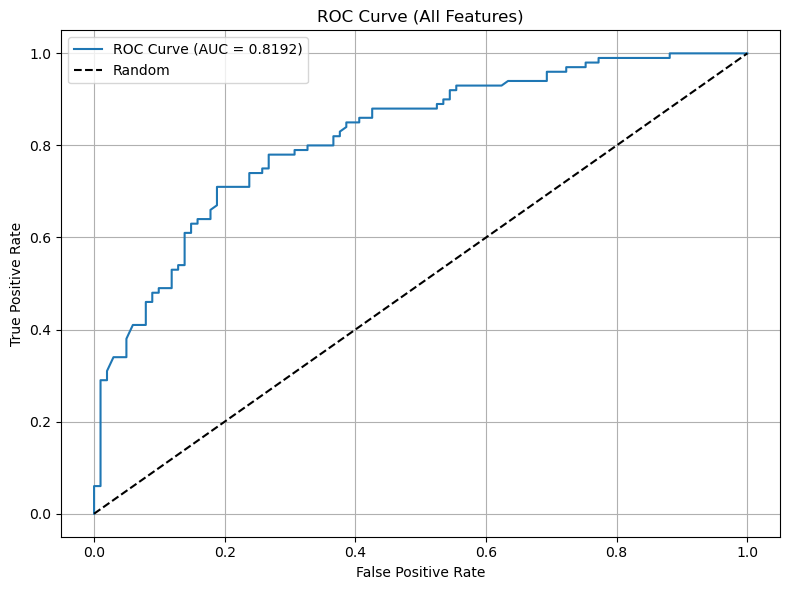

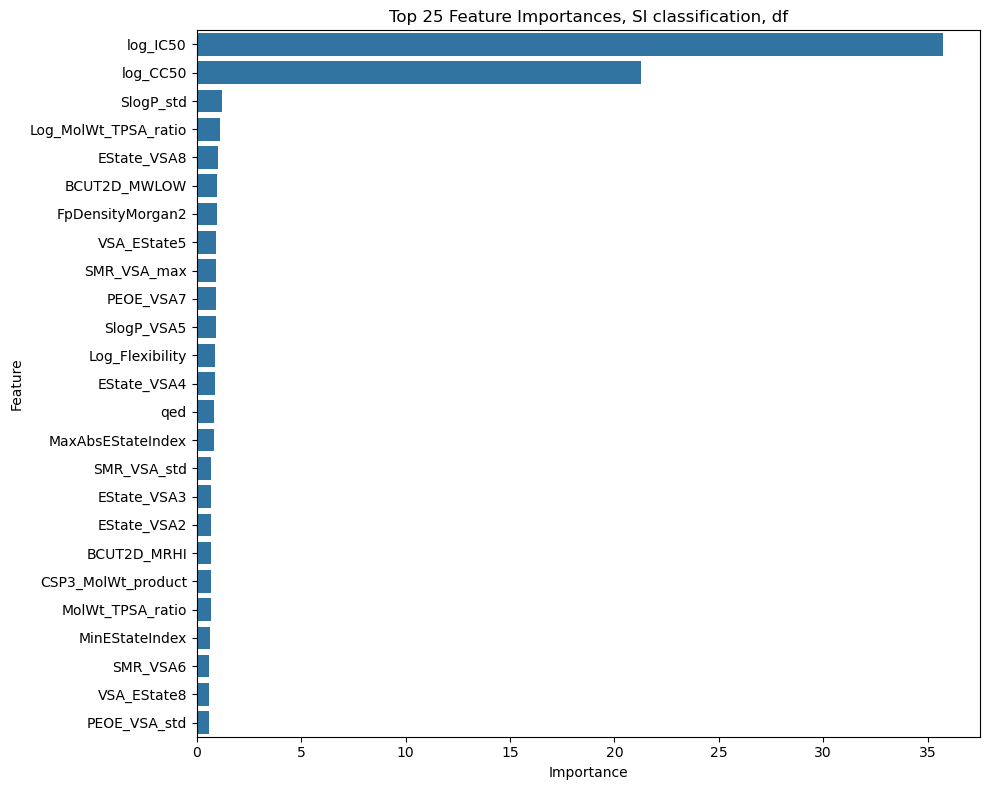


Топ-2 признака: ['log_IC50', 'log_CC50']

--- Classification Report (Top-2 Features) ---
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       101
           1       0.85      0.79      0.82       100

    accuracy                           0.83       201
   macro avg       0.83      0.83      0.83       201
weighted avg       0.83      0.83      0.83       201


Метрики модели на топ-2 признаках:
Accuracy:  0.8259
Precision: 0.8495
Recall:    0.7900
F1-score:  0.8187
ROC AUC:   0.8829


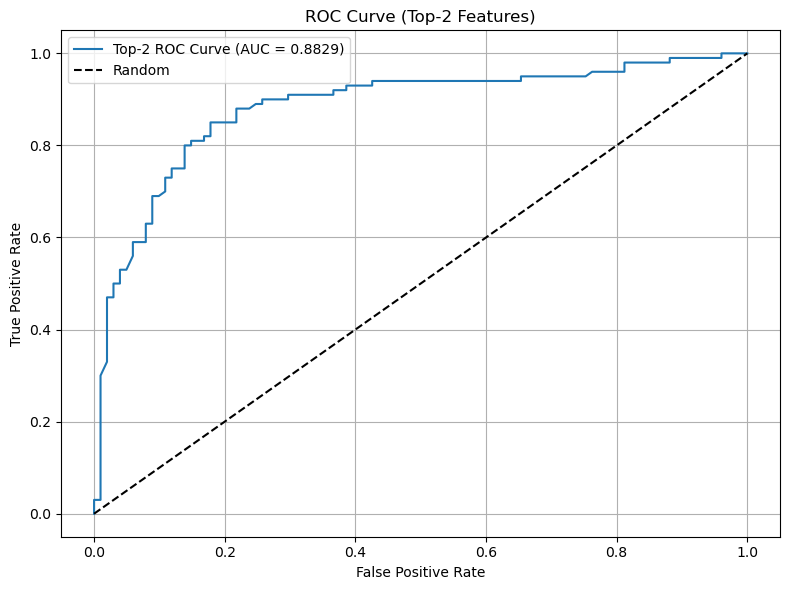

In [50]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    roc_curve
)

from catboost import CatBoostClassifier

# --- Подготовка данных ---
# Очистка имен колонок и замена inf на nan
for d in [df]:
    d.columns = d.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    d.replace([np.inf, -np.inf], np.nan, inplace=True)

# --- Добавление признака log_IC50 ---
reg_model_ic50 = joblib.load('regression_IC50_catboost_final_model_df_to SI_ckass.pkl')

try:
    with open("features_used_in_regression_model_ic50.txt", "r") as f:
        used_features_ic50 = f.read().splitlines()
except FileNotFoundError:
    used_features_ic50 = df.drop(columns=['SI', 'Unnamed_0'], errors='ignore').columns.tolist()

X_reg_ic50 = df[used_features_ic50].copy()
imputer_ic50 = SimpleImputer(strategy='mean')
X_reg_ic50_imp = pd.DataFrame(imputer_ic50.fit_transform(X_reg_ic50), columns=X_reg_ic50.columns)
df['log_IC50'] = reg_model_ic50.predict(X_reg_ic50_imp)

print("Признак 'log_IC50' успешно добавлен в DataFrame.")

# --- Добавление признака log_CC50 ---
reg_model_cc50 = joblib.load('regression_CC50_catboost_final_model_df_to_SI_class.pkl')

try:
    with open("features_used_in_regression_model_cc50.txt", "r") as f:
        used_features_cc50 = f.read().splitlines()
except FileNotFoundError:
    used_features_cc50 = df.drop(columns=['SI', 'Unnamed_0'], errors='ignore').columns.tolist()

X_reg_cc50 = df[used_features_cc50].copy()
imputer_cc50 = SimpleImputer(strategy='mean')
X_reg_cc50_imp = pd.DataFrame(imputer_cc50.fit_transform(X_reg_cc50), columns=X_reg_cc50.columns)
df['log_CC50'] = reg_model_cc50.predict(X_reg_cc50_imp)

print("Признак 'log_CC50' успешно добавлен в DataFrame.")

# --- Классификационная модель ---
model = CatBoostClassifier(
    depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
    verbose=0, task_type='GPU', random_state=42
)

# --- Разделение данных ---
df_clean = df.drop(columns=['Unnamed_0'], errors='ignore').copy()
X = df_clean.drop(columns=['SI'])
y_SI = df_clean['SI']

median_SI = y_SI.median()
y = (y_SI > median_SI).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Предобработка ---
imputer = SimpleImputer(strategy='mean')
scaler = RobustScaler()

X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test.columns)

# --- Обучение модели на всех признаках ---
model.fit(X_train_scaled, y_train)

# --- Предсказания ---
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# --- Метрики ---
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("\nМетрики на всех признаках:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# --- ROC-кривая ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (All Features)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Топ-25 признаков по важности ---
feat_importances = model.get_feature_importance()
feat_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feat_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(25))
plt.title('Top 25 Feature Importances, SI classification, df')
plt.tight_layout()
plt.show()

# --- Переобучение модели на топ-2 признаках ---
top2_features = feat_df['Feature'].values[:2]
print(f"\nТоп-2 признака: {top2_features.tolist()}")

X_train_top2 = X_train[top2_features]
X_test_top2 = X_test[top2_features]

X_train_top2_imp = pd.DataFrame(imputer.fit_transform(X_train_top2), columns=top2_features)
X_test_top2_imp = pd.DataFrame(imputer.transform(X_test_top2), columns=top2_features)

X_train_top2_scaled = pd.DataFrame(scaler.fit_transform(X_train_top2_imp), columns=top2_features)
X_test_top2_scaled = pd.DataFrame(scaler.transform(X_test_top2_imp), columns=top2_features)

model_top2 = CatBoostClassifier(
    depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
    verbose=0, task_type='GPU', random_state=42
)
model_top2.fit(X_train_top2_scaled, y_train)

y_pred_top2 = model_top2.predict(X_test_top2_scaled)
y_proba_top2 = model_top2.predict_proba(X_test_top2_scaled)[:, 1]

accuracy_top2 = accuracy_score(y_test, y_pred_top2)
precision_top2 = precision_score(y_test, y_pred_top2)
recall_top2 = recall_score(y_test, y_pred_top2)
f1_top2 = f1_score(y_test, y_pred_top2)
roc_auc_top2 = roc_auc_score(y_test, y_proba_top2)

# --- Classification report для модели на топ-2 признаках ---
print("\n--- Classification Report (Top-2 Features) ---")
print(classification_report(y_test, y_pred_top2))

print("\nМетрики модели на топ-2 признаках:")
print(f"Accuracy:  {accuracy_top2:.4f}")
print(f"Precision: {precision_top2:.4f}")
print(f"Recall:    {recall_top2:.4f}")
print(f"F1-score:  {f1_top2:.4f}")
print(f"ROC AUC:   {roc_auc_top2:.4f}")

fpr2, tpr2, _ = roc_curve(y_test, y_proba_top2)
plt.figure(figsize=(8,6))
plt.plot(fpr2, tpr2, label=f"Top-2 ROC Curve (AUC = {roc_auc_top2:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Top-2 Features)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Признак 'log_IC50' успешно добавлен в DataFrame.
Признак 'log_CC50' успешно добавлен в DataFrame.

Метрики на отложенной тестовой выборке (20%):
Accuracy:  0.7562
Precision: 0.7802
Recall:    0.7100
F1-score:  0.7435
ROC AUC:   0.8192

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       101
           1       0.78      0.71      0.74       100

    accuracy                           0.76       201
   macro avg       0.76      0.76      0.76       201
weighted avg       0.76      0.76      0.76       201



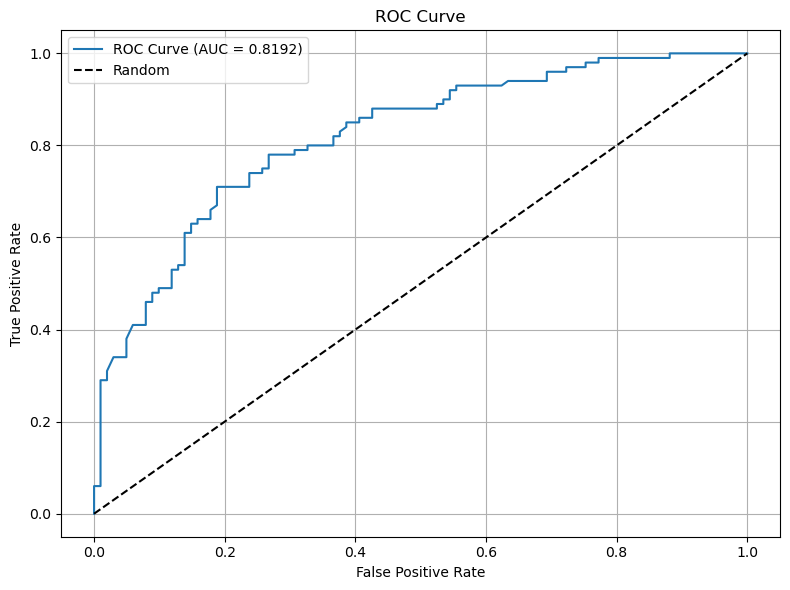

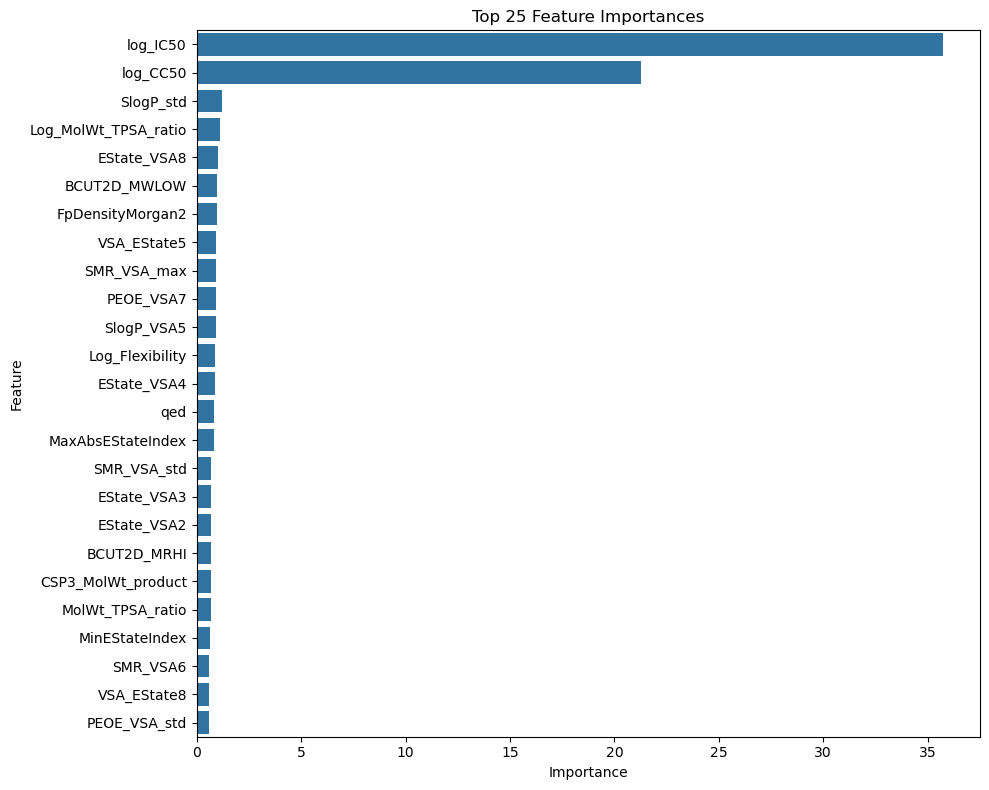

In [34]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    roc_curve
)

from catboost import CatBoostClassifier

# --- Подготовка данных ---
# Очистка имен колонок и замена inf на nan
for d in [df]:
    d.columns = d.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    d.replace([np.inf, -np.inf], np.nan, inplace=True)

# --- Добавление признака log_IC50 ---
reg_model_ic50 = joblib.load('regression_IC50_catboost_final_model_df_to SI_ckass.pkl')

try:
    with open("features_used_in_regression_model_ic50.txt", "r") as f:
        used_features_ic50 = f.read().splitlines()
except FileNotFoundError:
    used_features_ic50 = df.drop(columns=['SI', 'Unnamed_0'], errors='ignore').columns.tolist()

X_reg_ic50 = df[used_features_ic50].copy()
imputer_ic50 = SimpleImputer(strategy='mean')
X_reg_ic50_imp = pd.DataFrame(imputer_ic50.fit_transform(X_reg_ic50), columns=X_reg_ic50.columns)
df['log_IC50'] = reg_model_ic50.predict(X_reg_ic50_imp)

print("Признак 'log_IC50' успешно добавлен в DataFrame.")

# --- Добавление признака log_CC50 ---
reg_model_cc50 = joblib.load('regression_CC50_catboost_final_model_df_to_SI_class.pkl')

try:
    with open("features_used_in_regression_model_cc50.txt", "r") as f:
        used_features_cc50 = f.read().splitlines()
except FileNotFoundError:
    used_features_cc50 = df.drop(columns=['SI', 'Unnamed_0'], errors='ignore').columns.tolist()

X_reg_cc50 = df[used_features_cc50].copy()
imputer_cc50 = SimpleImputer(strategy='mean')
X_reg_cc50_imp = pd.DataFrame(imputer_cc50.fit_transform(X_reg_cc50), columns=X_reg_cc50.columns)
df['log_CC50'] = reg_model_cc50.predict(X_reg_cc50_imp)

print("Признак 'log_CC50' успешно добавлен в DataFrame.")

# --- Классификационная модель ---
model = CatBoostClassifier(
    depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
    verbose=0, task_type='GPU', random_state=42
)

# --- Разделение данных ---
df_clean = df.drop(columns=['Unnamed_0'], errors='ignore').copy()
X = df_clean.drop(columns=['SI'])
y_SI = df_clean['SI']

median_SI = y_SI.median()
y = (y_SI > median_SI).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Предобработка ---
imputer = SimpleImputer(strategy='mean')
scaler = RobustScaler()

X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test.columns)

# --- Обучение модели ---
model.fit(X_train_scaled, y_train)

# --- Предсказания ---
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# --- Метрики ---
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("\nМетрики на отложенной тестовой выборке (20%):")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

# --- Classification report ---
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# --- ROC-кривая ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Топ-25 признаков по важности ---
feat_importances = model.get_feature_importance()
feat_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feat_importances
}).sort_values(by='Importance', ascending=False).head(25)

plt.figure(figsize=(10,8))
sns.barplot(x='Importance', y='Feature', data=feat_df)
plt.title('Top 25 Feature Importances')
plt.tight_layout()
plt.show()


калибровка вероятностей с помощью метода Platt (sigmoid).

Признак 'log_IC50' успешно добавлен в DataFrame.
Признак 'log_CC50' успешно добавлен в DataFrame.

Метрики на всех признаках:
Accuracy:  0.7562
Precision: 0.7802
Recall:    0.7100
F1-score:  0.7435
ROC AUC:   0.8192

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       101
           1       0.78      0.71      0.74       100

    accuracy                           0.76       201
   macro avg       0.76      0.76      0.76       201
weighted avg       0.76      0.76      0.76       201



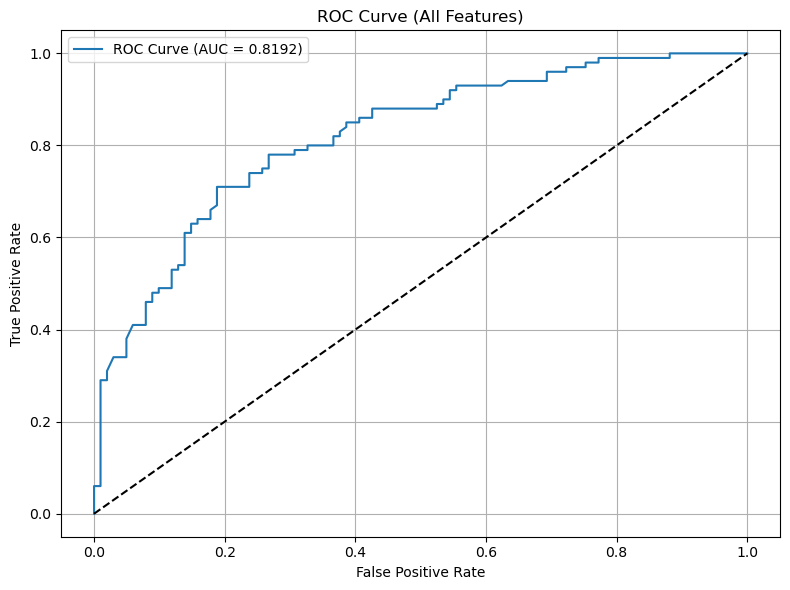

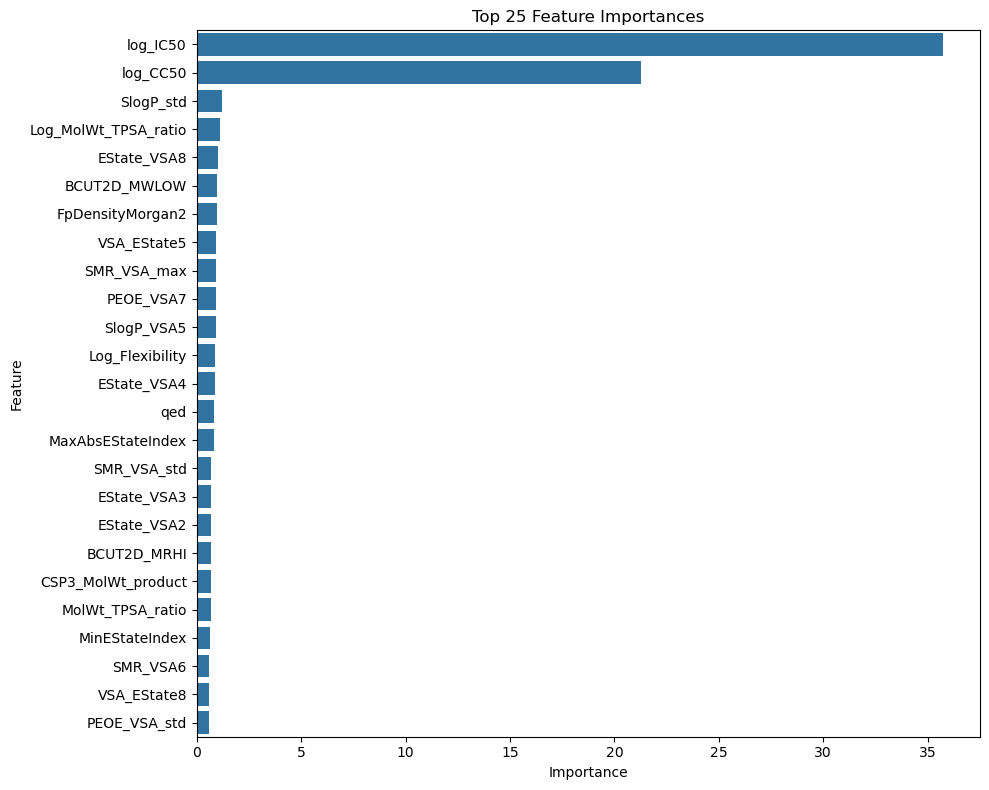


Топ-2 признака: ['log_IC50', 'log_CC50']

Метрики модели на топ-2 признаках:
Accuracy:  0.8259
Precision: 0.8495
Recall:    0.7900
F1-score:  0.8187
ROC AUC:   0.8829

--- Classification Report (Top-2 Features) ---
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       101
           1       0.85      0.79      0.82       100

    accuracy                           0.83       201
   macro avg       0.83      0.83      0.83       201
weighted avg       0.83      0.83      0.83       201



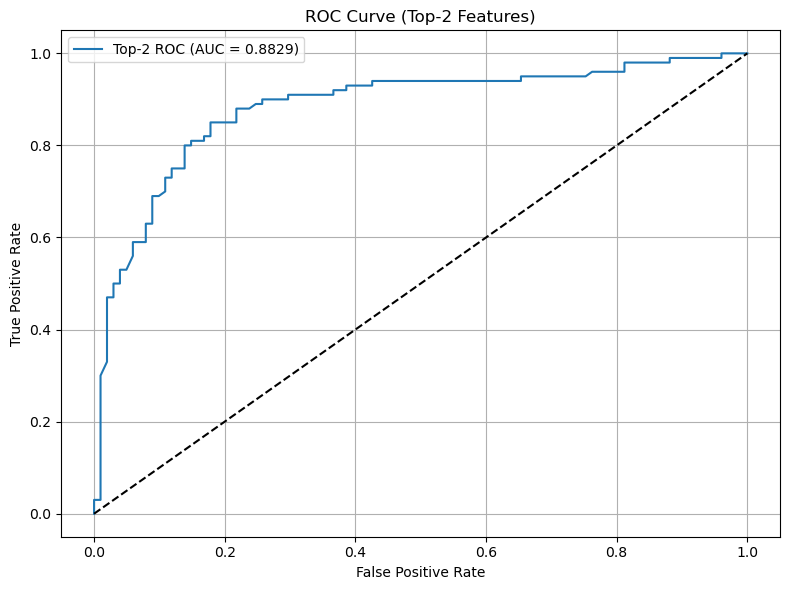


Метрики после калибровки методом Platt (Top-2 признаки):
Accuracy:  0.8308
Precision: 0.8438
Recall:    0.8100
F1-score:  0.8265
ROC AUC:   0.8852

--- Classification Report (Top-2 Features, Calibrated) ---
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       101
           1       0.84      0.81      0.83       100

    accuracy                           0.83       201
   macro avg       0.83      0.83      0.83       201
weighted avg       0.83      0.83      0.83       201



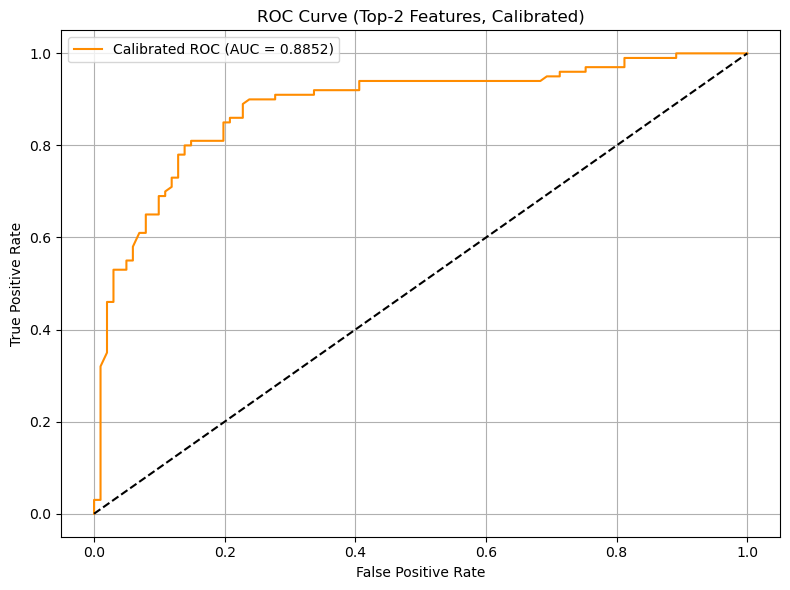

In [48]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    roc_curve
)
from sklearn.calibration import CalibratedClassifierCV
from catboost import CatBoostClassifier

# --- Подготовка данных ---
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# --- Добавление признака log_IC50 ---
reg_model_ic50 = joblib.load('regression_IC50_catboost_final_model_df_to SI_ckass.pkl')

try:
    with open("features_used_in_regression_model_ic50.txt", "r") as f:
        used_features_ic50 = f.read().splitlines()
except FileNotFoundError:
    used_features_ic50 = df.drop(columns=['SI', 'Unnamed_0'], errors='ignore').columns.tolist()

X_reg_ic50 = df[used_features_ic50].copy()
imputer_ic50 = SimpleImputer(strategy='mean')
X_reg_ic50_imp = pd.DataFrame(imputer_ic50.fit_transform(X_reg_ic50), columns=X_reg_ic50.columns)
df['log_IC50'] = reg_model_ic50.predict(X_reg_ic50_imp)

print("Признак 'log_IC50' успешно добавлен в DataFrame.")

# --- Добавление признака log_CC50 ---
reg_model_cc50 = joblib.load('regression_CC50_catboost_final_model_df_to_SI_class.pkl')

try:
    with open("features_used_in_regression_model_cc50.txt", "r") as f:
        used_features_cc50 = f.read().splitlines()
except FileNotFoundError:
    used_features_cc50 = df.drop(columns=['SI', 'Unnamed_0'], errors='ignore').columns.tolist()

X_reg_cc50 = df[used_features_cc50].copy()
imputer_cc50 = SimpleImputer(strategy='mean')
X_reg_cc50_imp = pd.DataFrame(imputer_cc50.fit_transform(X_reg_cc50), columns=X_reg_cc50.columns)
df['log_CC50'] = reg_model_cc50.predict(X_reg_cc50_imp)

print("Признак 'log_CC50' успешно добавлен в DataFrame.")

# --- Классификационная модель ---
model = CatBoostClassifier(
    depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
    verbose=0, task_type='GPU', random_state=42
)

# --- Разделение данных ---
df_clean = df.drop(columns=['Unnamed_0'], errors='ignore').copy()
X = df_clean.drop(columns=['SI'])
y_SI = df_clean['SI']

median_SI = y_SI.median()
y = (y_SI > median_SI).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Предобработка ---
imputer = SimpleImputer(strategy='mean')
scaler = RobustScaler()

X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test.columns)

# --- Обучение модели на всех признаках ---
model.fit(X_train_scaled, y_train)

# --- Предсказания ---
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# --- Метрики ---
print("\nМетрики на всех признаках:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# --- ROC-кривая ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (All Features)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Топ-25 признаков по важности ---
feat_importances = model.get_feature_importance()
feat_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feat_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(25))
plt.title('Top 25 Feature Importances')
plt.tight_layout()
plt.show()

# --- Переобучение модели на топ-2 признаках ---
top2_features = feat_df['Feature'].values[:2]
print(f"\nТоп-2 признака: {top2_features.tolist()}")

X_train_top2 = X_train[top2_features]
X_test_top2 = X_test[top2_features]

X_train_top2_imp = pd.DataFrame(imputer.fit_transform(X_train_top2), columns=top2_features)
X_test_top2_imp = pd.DataFrame(imputer.transform(X_test_top2), columns=top2_features)

X_train_top2_scaled = pd.DataFrame(scaler.fit_transform(X_train_top2_imp), columns=top2_features)
X_test_top2_scaled = pd.DataFrame(scaler.transform(X_test_top2_imp), columns=top2_features)

model_top2 = CatBoostClassifier(
    depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05,
    verbose=0, task_type='GPU', random_state=42
)
model_top2.fit(X_train_top2_scaled, y_train)

y_pred_top2 = model_top2.predict(X_test_top2_scaled)
y_proba_top2 = model_top2.predict_proba(X_test_top2_scaled)[:, 1]

print("\nМетрики модели на топ-2 признаках:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_top2):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_top2):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_top2):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred_top2):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba_top2):.4f}")
print("\n--- Classification Report (Top-2 Features) ---")
print(classification_report(y_test, y_pred_top2))

fpr2, tpr2, _ = roc_curve(y_test, y_proba_top2)
plt.figure(figsize=(8,6))
plt.plot(fpr2, tpr2, label=f"Top-2 ROC (AUC = {roc_auc_score(y_test, y_proba_top2):.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Top-2 Features)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Калибровка методом Platt (sigmoid) ---
calibrated_model_top2 = CalibratedClassifierCV(model_top2, method='sigmoid', cv=5)
calibrated_model_top2.fit(X_train_top2_scaled, y_train)

y_pred_top2_calibrated = calibrated_model_top2.predict(X_test_top2_scaled)
y_proba_top2_calibrated = calibrated_model_top2.predict_proba(X_test_top2_scaled)[:, 1]

print("\nМетрики после калибровки методом Platt (Top-2 признаки):")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_top2_calibrated):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_top2_calibrated):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_top2_calibrated):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred_top2_calibrated):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba_top2_calibrated):.4f}")
print("\n--- Classification Report (Top-2 Features, Calibrated) ---")
print(classification_report(y_test, y_pred_top2_calibrated))

fpr2_cal, tpr2_cal, _ = roc_curve(y_test, y_proba_top2_calibrated)
plt.figure(figsize=(8,6))
plt.plot(fpr2_cal, tpr2_cal, label=f"Calibrated ROC (AUC = {roc_auc_score(y_test, y_proba_top2_calibrated):.4f})", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Top-2 Features, Calibrated)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    HistGradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from matplotlib.backends.backend_pdf import PdfPages

# Очистка имен и замена inf на nan
for d in [df, df_cut, df_bin, df_cut_bin]:
    d.columns = d.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    d.replace([np.inf, -np.inf], np.nan, inplace=True)

# Определение базовых моделей классификации
estimators_cls = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
    ('cat', CatBoostClassifier(verbose=0, random_state=42))
]

final_estimator_cls = LogisticRegression()
stacking_model_cls = StackingClassifier(
    estimators=estimators_cls,
    final_estimator=final_estimator_cls,
    cv=5,
    n_jobs=1
)

class_models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost":CatBoostClassifier(
    depth=6,
    iterations=100,
    l2_leaf_reg=5,
    learning_rate=0.05,
    verbose=0,
    random_state=42
    ),
    "MLP": MLPClassifier(max_iter=1000, random_state=42),
    "NaiveBayes": GaussianNB(),
    "SVM": SVC(probability=True),
    "Stacking": stacking_model_cls
}


def evaluate_class_models(df_input, y_col='RI_above_median'):
    df_eval = df_input.copy().drop(columns=['Unnamed_0'], errors='ignore')
    X = df_eval.drop(columns=[y_col])
    y = df_eval[y_col]

    imputer = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    scaler = RobustScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for name, model in tqdm(class_models.items(), desc=f"Cross-validation ({df_input.shape[1]} features)"):
        try:
            cv_results = cross_validate(
                model, X_scaled, y,
                cv=kf,
                scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                return_train_score=False,
                n_jobs=1
            )
            results.append({
                "Model": name,
                "Accuracy": np.mean(cv_results['test_accuracy']),
                "Precision": np.mean(cv_results['test_precision']),
                "Recall": np.mean(cv_results['test_recall']),
                "F1": np.mean(cv_results['test_f1']),
                "ROC AUC": np.mean(cv_results['test_roc_auc'])
            })
        except Exception as e:
            print(f"Error in model {name}: {e}")
    return pd.DataFrame(results).sort_values(by="F1", ascending=False), X_scaled, y, imputer, scaler

results_df, X_df_scaled, y_df, imp_df, scaler_df = evaluate_class_models(df)
results_df['Dataset'] = 'df'

results_cut, X_cut_scaled, y_cut, _, _ = evaluate_class_models(df_cut)
results_cut['Dataset'] = 'df_cut'

results_bin, X_bin_scaled, y_bin, _, _ = evaluate_class_models(df_bin)
results_bin['Dataset'] = 'df_bin'

results_cut_bin, X_cut_bin_scaled, y_cut_bin, _, _ = evaluate_class_models(df_cut_bin)
results_cut_bin['Dataset'] = 'df_cut_bin'

comparison_cls = pd.concat([results_df, results_cut, results_bin, results_cut_bin], ignore_index=True)

with PdfPages('RI_classification_evaluation_report.pdf') as pdf:
    # F1
    plt.figure(figsize=(14, 7))
    sns.barplot(data=comparison_cls, x='F1', y='Model', hue='Dataset', palette='Set2')
    plt.title("Model F1 Comparison Across Datasets")
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # ROC AUC
    plt.figure(figsize=(14, 7))
    sns.barplot(data=comparison_cls, x='ROC AUC', y='Model', hue='Dataset', palette='Set1')
    plt.title("Model ROC AUC Comparison Across Datasets")
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # ROC-кривые и важности признаков
    for name, (X_scaled, y) in zip(['df', 'df_cut', 'df_bin', 'df_cut_bin'],
                                   [(X_df_scaled, y_df), (X_cut_scaled, y_cut), (X_bin_scaled, y_bin), (X_cut_bin_scaled, y_cut_bin)]):
        best_model_name = comparison_cls[comparison_cls['Dataset'] == name].iloc[0]['Model']
        model = class_models[best_model_name]
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {auc(fpr, tpr):.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.title(f"ROC Curve - {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        pdf.savefig()
        plt.close()

        # Важность признаков
        try:
            if hasattr(model, 'get_feature_importance'):
                importances = model.get_feature_importance(Pool(X_scaled, label=y))
            elif hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
            else:
                continue

            feature_names = X_scaled.columns
            if len(importances) != len(feature_names):
                min_len = min(len(importances), len(feature_names))
                importances = importances[:min_len]
                feature_names = feature_names[:min_len]

            feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
            feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)

            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
            plt.title(f"Top 20 Feature Importances - {best_model_name} ({name})")
            plt.tight_layout()
            pdf.savefig()
            plt.close()
        except Exception as e:
            print(f"[!] Could not plot feature importances for {best_model_name} ({name}): {e}")

with pd.ExcelWriter("RI_classification_comparison_metrics.xlsx") as writer:
    results_df.to_excel(writer, sheet_name="df", index=False)
    results_cut.to_excel(writer, sheet_name="df_cut", index=False)
    results_bin.to_excel(writer, sheet_name="df_bin", index=False)
    results_cut_bin.to_excel(writer, sheet_name="df_cut_bin", index=False)
    comparison_cls.to_excel(writer, sheet_name="Comparison", index=False)


Cross-validation (97 features): 100%|██████████| 13/13 [03:54<00:00, 18.04s/it]



 Время CPU: 0.57 сек
 Время GPU: 36.06 сек
 Используем CPU (быстрее) для модели.

 Запуск RandomizedSearchCV...


RandomizedSearchCV:   0%|          | 0/1 [00:00<?, ?it/s]

0:	learn: 0.6638813	total: 118ms	remaining: 55.6s
469:	learn: 0.0220186	total: 17.8s	remaining: 0us
0:	learn: 0.6646396	total: 38.4ms	remaining: 18s
469:	learn: 0.0269383	total: 17.3s	remaining: 0us
0:	learn: 0.6652452	total: 36.9ms	remaining: 17.3s
469:	learn: 0.0284637	total: 17.4s	remaining: 0us
0:	learn: 0.6383327	total: 11.6ms	remaining: 4.79s
413:	learn: 0.0069940	total: 4.63s	remaining: 0us
0:	learn: 0.6468985	total: 12.4ms	remaining: 5.11s
413:	learn: 0.0086537	total: 4.79s	remaining: 0us
0:	learn: 0.6423159	total: 12.7ms	remaining: 5.24s
413:	learn: 0.0094746	total: 4.61s	remaining: 0us
0:	learn: 0.6459391	total: 11.1ms	remaining: 3.88s
348:	learn: 0.0120318	total: 3.77s	remaining: 0us
0:	learn: 0.6533239	total: 11.3ms	remaining: 3.94s
348:	learn: 0.0149454	total: 4.01s	remaining: 0us
0:	learn: 0.6493690	total: 13.2ms	remaining: 4.61s
348:	learn: 0.0156051	total: 3.81s	remaining: 0us
0:	learn: 0.6614498	total: 6.78ms	remaining: 2.64s
390:	learn: 0.0658706	total: 2.59s	remainin

RandomizedSearchCV: 100%|██████████| 1/1 [23:29<00:00, 1409.68s/it]


469:	learn: 0.0387555	total: 18s	remaining: 0us
 Параметры после RandomizedSearchCV:
{'bagging_temperature': 0.3745401188473625, 'depth': 8, 'iterations': 470, 'l2_leaf_reg': 8.31993941811405, 'learning_rate': 0.06986584841970366}

 Запуск GridSearchCV...


GridSearchCV:   0%|          | 0/1 [00:00<?, ?it/s]

0:	learn: 0.6636262	total: 19.3ms	remaining: 8.09s
419:	learn: 0.0272548	total: 7.84s	remaining: 0us
0:	learn: 0.6651662	total: 19.3ms	remaining: 8.1s
419:	learn: 0.0247751	total: 7.9s	remaining: 0us
0:	learn: 0.6579868	total: 20.5ms	remaining: 8.61s
419:	learn: 0.0224755	total: 7.72s	remaining: 0us
0:	learn: 0.6598389	total: 22.5ms	remaining: 9.43s
419:	learn: 0.0204700	total: 7.97s	remaining: 0us
0:	learn: 0.6654473	total: 20.4ms	remaining: 8.56s
419:	learn: 0.0327435	total: 7.62s	remaining: 0us
0:	learn: 0.6663499	total: 20.2ms	remaining: 8.47s
419:	learn: 0.0284125	total: 7.65s	remaining: 0us
0:	learn: 0.6601434	total: 23.9ms	remaining: 10s
419:	learn: 0.0251057	total: 7.53s	remaining: 0us
0:	learn: 0.6612434	total: 18ms	remaining: 7.55s
419:	learn: 0.0239784	total: 7.66s	remaining: 0us
0:	learn: 0.6636262	total: 18.1ms	remaining: 8.51s
469:	learn: 0.0243674	total: 8.46s	remaining: 0us
0:	learn: 0.6651662	total: 18.4ms	remaining: 8.61s
469:	learn: 0.0216595	total: 8.63s	remaining: 

GridSearchCV: 100%|██████████| 1/1 [44:04<00:00, 2644.38s/it]

419:	learn: 0.0531117	total: 9.13s	remaining: 0us
 Точно подобранные параметры (GridSearchCV):
{'bagging_temperature': 0.37, 'depth': 7, 'iterations': 420, 'l2_leaf_reg': 8.3, 'learning_rate': 0.07}

 Классификационный отчет:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       101
           1       0.83      0.80      0.82       100

    accuracy                           0.82       201
   macro avg       0.82      0.82      0.82       201
weighted avg       0.82      0.82      0.82       201

Accuracy: 0.8209
ROC AUC:  0.8997

 Результаты сохранены в RI_results_classification.json и .csv


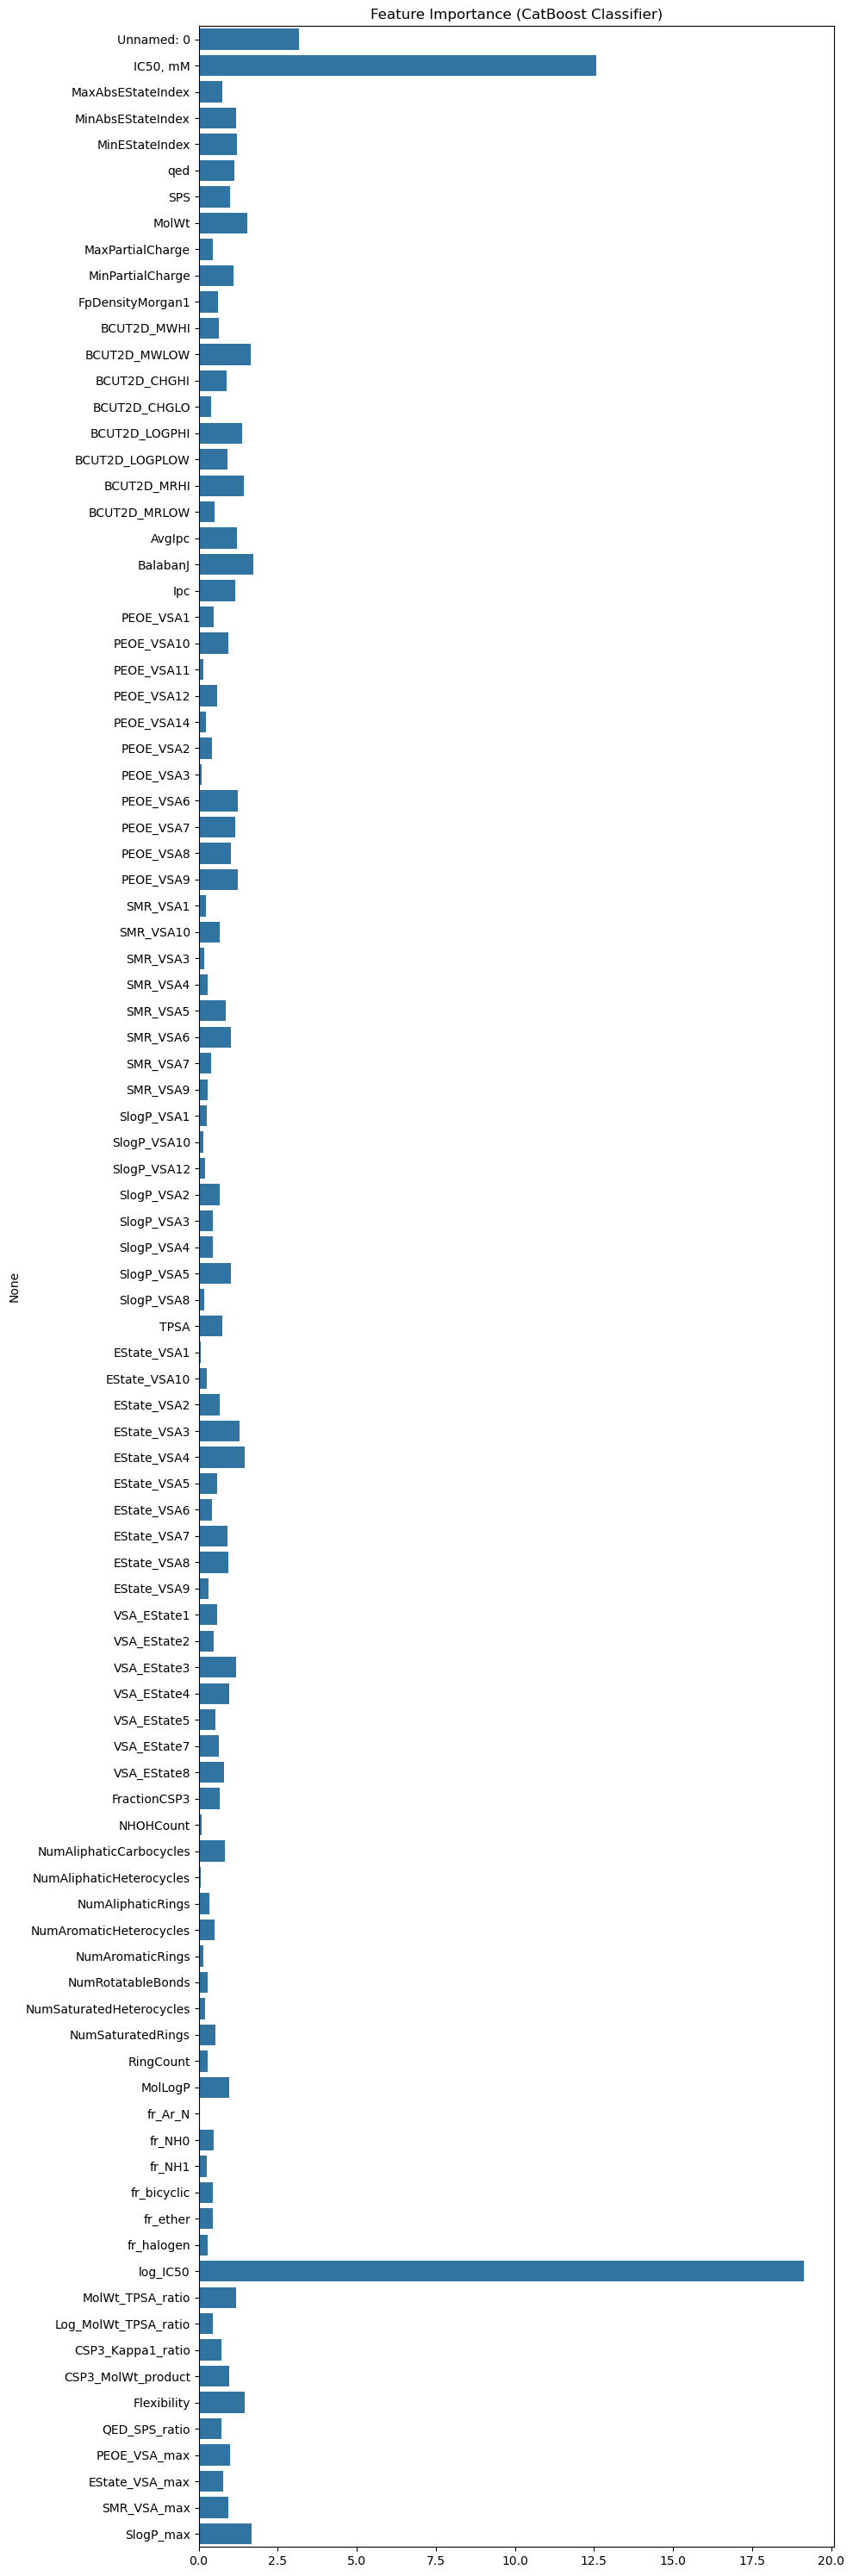

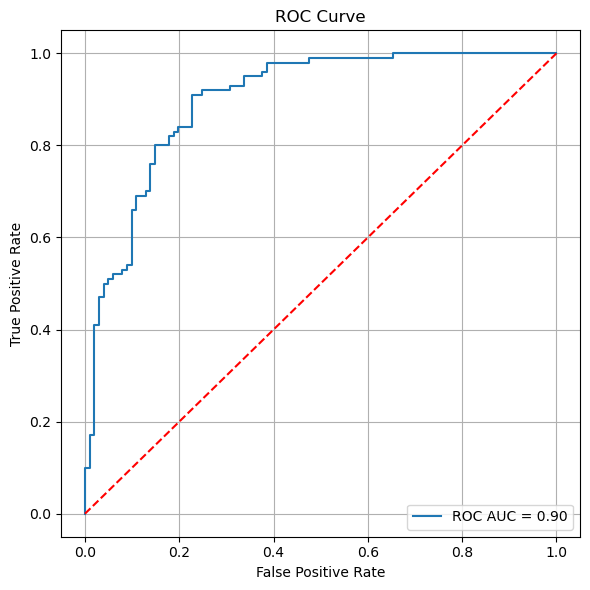

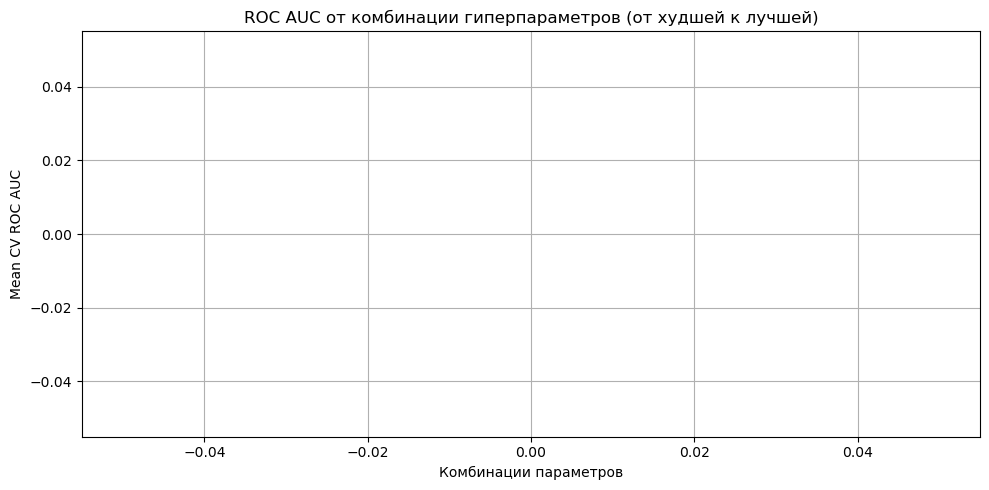


--- Выводы и интерпретация ---
 Accuracy на тесте: 0.8209
 ROC AUC на тесте: 0.8997

 Топ-5 признаков по важности:
1. log_IC50: 19.1391
2. IC50, mM: 12.5764
3. Unnamed: 0: 3.1739
4. BalabanJ: 1.7313
5. SlogP_max: 1.6817

 Модель показала очень хорошее качество классификации (ROC AUC = 0.900).
 Разница между train и CV AUC незначительная — переобучение маловероятно.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    accuracy_score,
    make_scorer,
    roc_curve
)
from scipy.stats import randint, uniform
from catboost import CatBoostClassifier
from tqdm import tqdm
from time import time

# --- Функция для автоматического выбора устройства ---
def detect_faster_device(X_sample, y_sample):
    cpu_model = CatBoostClassifier(
        task_type='CPU',
        iterations=50,
        verbose=0,
        random_state=42
    )
    gpu_model = CatBoostClassifier(
        task_type='GPU',
        iterations=50,
        verbose=0,
        random_state=42
    )

    start = time()
    cpu_model.fit(X_sample, y_sample)
    cpu_time = time() - start

    start = time()
    gpu_model.fit(X_sample, y_sample)
    gpu_time = time() - start

    faster = 'GPU' if gpu_time < cpu_time else 'CPU'
    print(f"\n Время CPU: {cpu_time:.2f} сек\n Время GPU: {gpu_time:.2f} сек")
    print(f" Используем {faster} (быстрее) для модели.\n")
    return faster

# --- 1. Данные и подготовка ---

X = df_cut_bin.drop(columns=['RI_above_median'])
y = df_cut_bin['RI_above_median']
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)

# --- 2. Выбор устройства ---
device = detect_faster_device(X_train[:200], y_train[:200])  # малое подмножество для сравнения

# --- 3. Базовая модель ---
base_model = CatBoostClassifier(
    verbose=500,
    random_state=42,
    task_type=device,
    thread_count=6
)

# --- 4. Метрики ---
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

# --- 5. RandomizedSearchCV ---
param_dist = {
    'depth': randint(4, 10),
    'learning_rate': uniform(0.01, 0.1),
    'iterations': randint(200, 600),
    'l2_leaf_reg': uniform(1, 10),
    'bagging_temperature': uniform(0, 1),
}

print(" Запуск RandomizedSearchCV...")
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring=scoring,
    refit='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=1,
    return_train_score=True
)

with tqdm(total=1, desc="RandomizedSearchCV") as pbar:
    random_search.fit(X_train, y_train)
    pbar.update(1)

print(" Параметры после RandomizedSearchCV:")
print(random_search.best_params_)

# --- 6. GridSearchCV — тонкая настройка ---
best_params = random_search.best_params_

param_grid = {
    'depth': list(set([max(1, best_params['depth'] - 1), best_params['depth'], best_params['depth'] + 1])),
    'learning_rate': [round(best_params['learning_rate'] * r, 3) for r in [1.0, 1.2]],
    'iterations': [best_params['iterations'] - 50, best_params['iterations'], best_params['iterations'] + 50],
    'l2_leaf_reg': [round(best_params['l2_leaf_reg'] * r, 1) for r in [1.0, 1.2]],
    'bagging_temperature': [round(best_params['bagging_temperature'] * r, 2) for r in [1.0, 1.2]]
}

for key, vals in param_grid.items():
    param_grid[key] = sorted(list(set([v for v in vals if v >= 0])))

print("\n Запуск GridSearchCV...")
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='roc_auc',
    cv=2,
    n_jobs=1,
    return_train_score=True
)

with tqdm(total=1, desc="GridSearchCV") as pbar:
    grid_search.fit(X_train, y_train)
    pbar.update(1)

print(" Точно подобранные параметры (GridSearchCV):")
print(grid_search.best_params_)

# --- 7. Оценка на тесте ---
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("\n Классификационный отчет:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC:  {roc_auc:.4f}")

# --- 8. Сохранение результатов ---
results = {
    "best_params_random": random_search.best_params_,
    "best_params_grid": grid_search.best_params_,
    "accuracy_test": accuracy,
    "roc_auc_test": roc_auc,
    "classification_report": classification_report(y_test, y_pred, output_dict=True)
}

with open("RI_results_classification.json", "w") as f:
    json.dump(results, f, indent=4)

pd.DataFrame(results["classification_report"]).transpose().to_csv("RI_classification_report.csv")

print("\n Результаты сохранены в RI_results_classification.json и .csv")

# --- 9. График Feature Importance ---
importances = best_model.get_feature_importance()
features = X.columns

plt.figure(figsize=(10, 30))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance (CatBoost Classifier)")
plt.tight_layout()
plt.savefig("RI_classification_feature_importance.png")
plt.show()

pd.DataFrame({'feature': features, 'importance': importances}).sort_values(
    by='importance', ascending=False
).to_csv("RI_feature_importance.csv", index=False)

# --- 10. ROC AUC график ---
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("RI_roc_curve.png")
plt.show()

# --- 11. ROC AUC от гиперпараметров ---
cv_results_auc = pd.DataFrame(grid_search.cv_results_)
auc_sorted = cv_results_auc.sort_values(by='mean_test_roc_auc')

plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(auc_sorted)), y=auc_sorted['mean_test_roc_auc'])
plt.title('ROC AUC от комбинации гиперпараметров (от худшей к лучшей)')
plt.xlabel('Комбинации параметров')
plt.ylabel('Mean CV ROC AUC')
plt.grid(True)
plt.tight_layout()
plt.savefig("RI_classifier_roc_auc_hyperparams.png")
plt.show()

# --- 12. Выводы и интерпретация ---
print("\n--- Выводы и интерпретация ---")
print(f" Accuracy на тесте: {accuracy:.4f}")
print(f" ROC AUC на тесте: {roc_auc:.4f}")

top_features = pd.Series(importances, index=features).sort_values(ascending=False)[:5]
print("\n Топ-5 признаков по важности:")
for i, (feat, val) in enumerate(top_features.items(), 1):
    print(f"{i}. {feat}: {val:.4f}")

if roc_auc > 0.9:
    perf = "отличное"
elif roc_auc > 0.8:
    perf = "очень хорошее"
elif roc_auc > 0.7:
    perf = "удовлетворительное"
else:
    perf = "недостаточное"

print(f"\n Модель показала {perf} качество классификации (ROC AUC = {roc_auc:.3f}).")

train_auc = max(grid_search.cv_results_["mean_train_roc_auc"])
cv_auc = grid_search.best_score_
gap = train_auc - cv_auc

if gap > 0.05:
    print(f" Возможное переобучение: разница между train AUC и CV AUC составляет {gap:.3f}.")
else:
    print(" Разница между train и CV AUC незначительная — переобучение маловероятно.")


Running 5-fold cross-validation...
Fold 1 Accuracy: 0.6937, ROC AUC: 0.7272
Fold 2 Accuracy: 0.6813, ROC AUC: 0.7334
Fold 3 Accuracy: 0.6125, ROC AUC: 0.6783
Fold 4 Accuracy: 0.6687, ROC AUC: 0.7319
Fold 5 Accuracy: 0.6750, ROC AUC: 0.7340

Cross-validation results:
Accuracy: 0.6663 ± 0.0281
ROC AUC:  0.7210 ± 0.0215

Classification report:
              precision    recall  f1-score   support

           0       0.64      0.73      0.68       101
           1       0.68      0.58      0.63       100

    accuracy                           0.66       201
   macro avg       0.66      0.66      0.65       201
weighted avg       0.66      0.66      0.65       201

Test Accuracy: 0.6567
Test ROC AUC:  0.6978


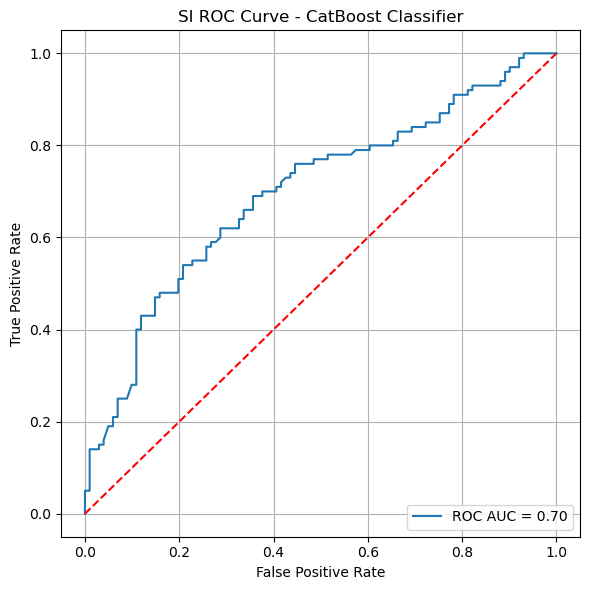

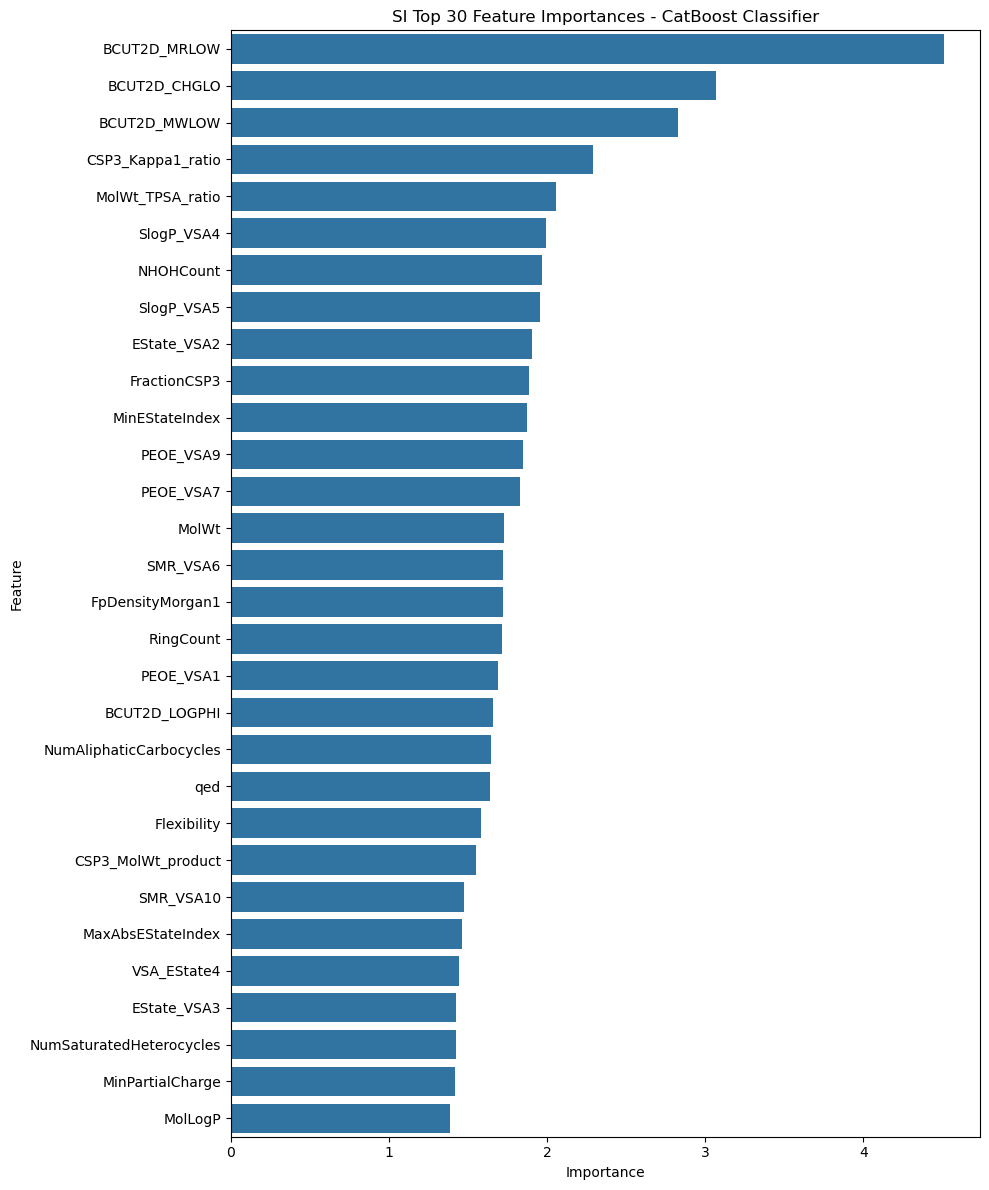


Модель сохранена как 'SI_classifier_catboost_final_model.pkl'


In [30]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
import joblib

# --- 1. Загрузка и подготовка ---
df = df_cut_bin.copy()
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df.columns:
    df.drop(columns=['Unnamed_0'], inplace=True)

# Удаляем RI_above_median (если есть)
if 'RI_above_median' in df.columns:
    df.drop(columns=['RI_above_median'], inplace=True)

# --- 2. Разделение на train/test ---
X_full = df.drop(columns=['SI'])
SI_full = df['SI']

X_train_raw, X_test_raw, SI_train, SI_test = train_test_split(
    X_full, SI_full, test_size=0.2, random_state=42, stratify=(SI_full > SI_full.median())
)

# --- 3. Создание целевых переменных ---
train_median_SI = SI_train.median()
test_median_SI = SI_full.median()

y_train = (SI_train > train_median_SI).astype(int)
y_test = (SI_test > test_median_SI).astype(int)

# --- 4. Импутация и масштабирование ---
imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_raw), columns=X_test_raw.columns)

scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train_imputed.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_test_imputed.columns)

# --- 5. Параметры модели ---
catboost_params = {
    'depth': 6,
    'iterations': 100,
    'l2_leaf_reg': 5,
    'learning_rate': 0.05,
    'verbose': 0,
    'random_state': 42
}

# --- 6. Кросс-валидация ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_list, roc_auc_list = [], []

print("Running 5-fold cross-validation...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_raw), 1):
    X_tr_raw, X_val_raw = X_train_raw.iloc[train_idx], X_train_raw.iloc[val_idx]
    SI_tr, SI_val = SI_train.iloc[train_idx], SI_train.iloc[val_idx]

    # Target валидация по медиане только train
    median_fold = SI_tr.median()
    y_tr = (SI_tr > median_fold).astype(int)
    y_val = (SI_val > median_fold).astype(int)

    # Преобразование
    imputer = SimpleImputer(strategy='most_frequent')
    X_tr_imp = pd.DataFrame(imputer.fit_transform(X_tr_raw), columns=X_tr_raw.columns)
    X_val_imp = pd.DataFrame(imputer.transform(X_val_raw), columns=X_val_raw.columns)

    scaler = RobustScaler()
    X_tr_scaled = pd.DataFrame(scaler.fit_transform(X_tr_imp), columns=X_tr_raw.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val_imp), columns=X_tr_raw.columns)

    model = CatBoostClassifier(**catboost_params)
    model.fit(X_tr_scaled, y_tr)

    y_pred = model.predict(X_val_scaled)
    y_proba = model.predict_proba(X_val_scaled)[:, 1]

    acc = accuracy_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_proba)

    accuracy_list.append(acc)
    roc_auc_list.append(roc_auc)

    print(f"Fold {fold} Accuracy: {acc:.4f}, ROC AUC: {roc_auc:.4f}")

print("\nCross-validation results:")
print(f"Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
print(f"ROC AUC:  {np.mean(roc_auc_list):.4f} ± {np.std(roc_auc_list):.4f}")

# --- 7. Обучение финальной модели и тест ---
cat_model_eval = CatBoostClassifier(**catboost_params)
cat_model_eval.fit(X_train_scaled, y_train)

y_pred = cat_model_eval.predict(X_test_scaled)
y_proba = cat_model_eval.predict_proba(X_test_scaled)[:, 1]

acc_test = accuracy_score(y_test, y_pred)
roc_auc_test = roc_auc_score(y_test, y_proba)

print("\nClassification report:")
print(classification_report(y_test, y_pred))
print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test ROC AUC:  {roc_auc_test:.4f}")

# --- 8. ROC-кривая ---
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_test:.2f}")
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SI ROC Curve - CatBoost Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("SI_classifier_roc_curve.png")
plt.show()

# --- 9. Важность признаков ---
# Обучаем на всём датасете по SI_full > median
y_full = (SI_full > SI_full.median()).astype(int)

imputer_full = SimpleImputer(strategy='most_frequent')
X_imp_full = pd.DataFrame(imputer_full.fit_transform(X_full), columns=X_full.columns)

scaler_full = RobustScaler()
X_scaled_full = pd.DataFrame(scaler_full.fit_transform(X_imp_full), columns=X_full.columns)

cat_model_final = CatBoostClassifier(**catboost_params)
cat_model_final.fit(X_scaled_full, y_full)

feat_imp = cat_model_final.get_feature_importance(Pool(X_scaled_full, label=y_full))
feat_imp_df = pd.DataFrame({
    'Feature': X_full.columns,
    'Importance': feat_imp
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("SI Top 30 Feature Importances - CatBoost Classifier")
plt.tight_layout()
plt.savefig("SI_feature_importance.png")
plt.show()

# --- 10. Сохранение модели ---
joblib.dump(cat_model_final, 'SI_classifier_catboost_final_model.pkl')
print("\nМодель сохранена как 'SI_classifier_catboost_final_model.pkl'")


- добавим предсказанный признак log_IC50

Running 5-fold cross-validation...
Fold 1 Accuracy: 0.6937, ROC AUC: 0.7369
Fold 2 Accuracy: 0.6813, ROC AUC: 0.7374
Fold 3 Accuracy: 0.6000, ROC AUC: 0.6846
Fold 4 Accuracy: 0.6750, ROC AUC: 0.7470
Fold 5 Accuracy: 0.6875, ROC AUC: 0.7503

Cross-validation results:
Accuracy: 0.6675 ± 0.0343
ROC AUC:  0.7312 ± 0.0239

Classification report:
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       101
           1       0.72      0.58      0.64       100

    accuracy                           0.68       201
   macro avg       0.69      0.68      0.68       201
weighted avg       0.69      0.68      0.68       201

Test Accuracy: 0.6816
Test ROC AUC:  0.7173


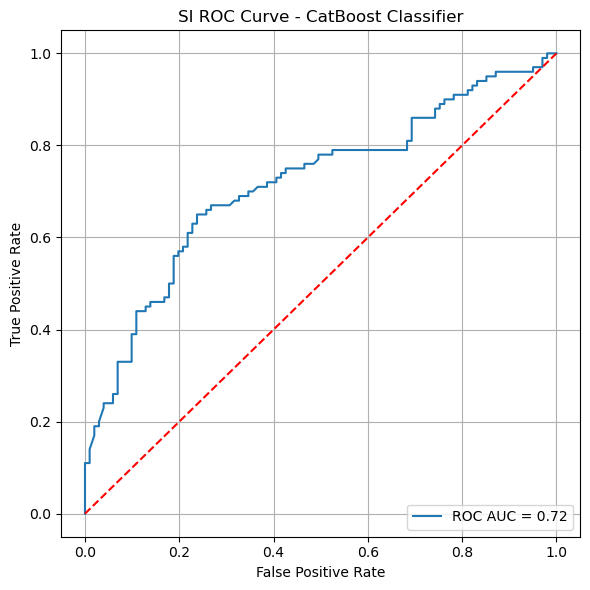

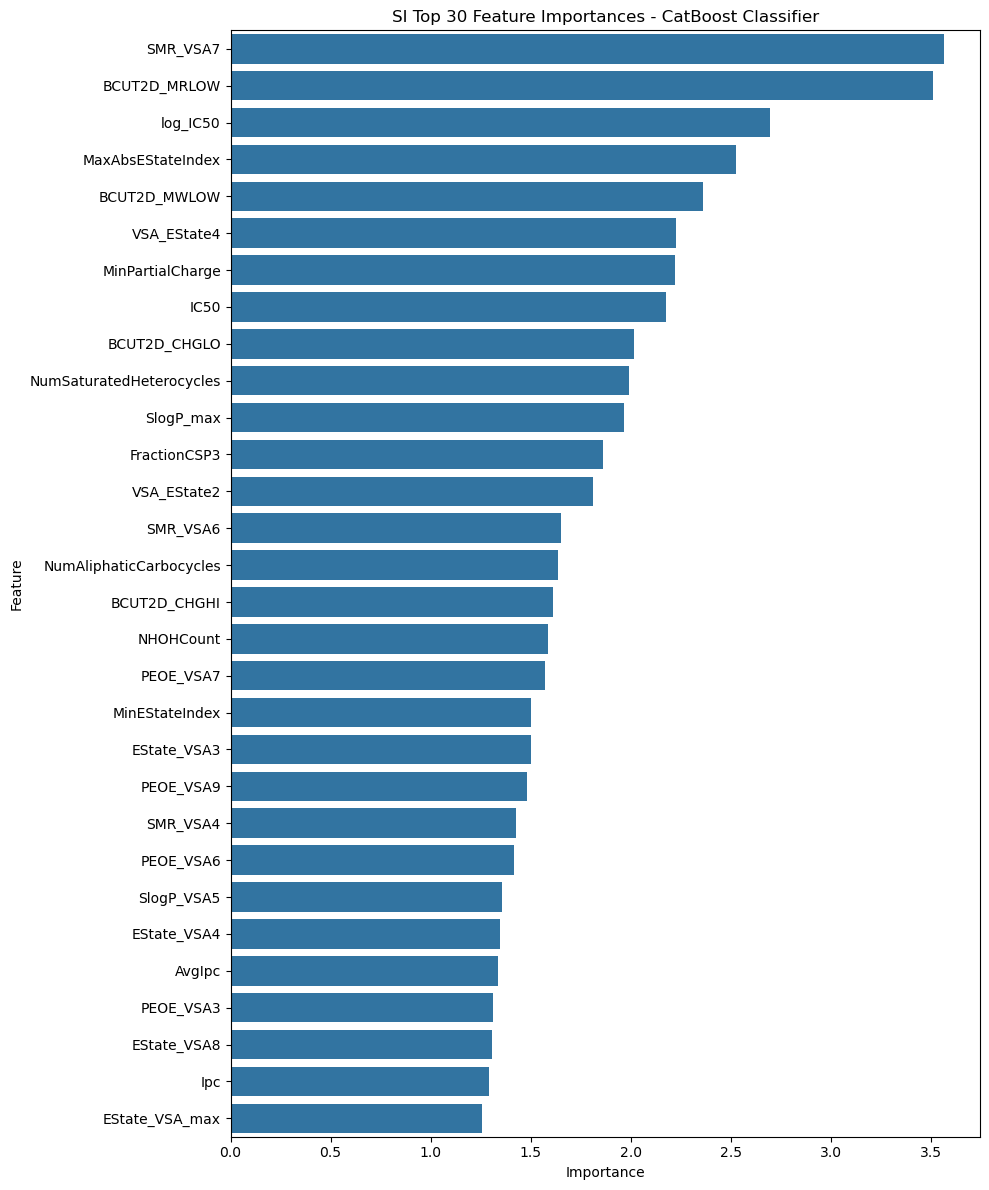


Модель сохранена как 'SI_classifier_catboost_final_model.pkl'


In [58]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
import joblib

# --- 1. Загрузка и подготовка ---
df = df_cut_bin.copy()
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df.columns:
    df.drop(columns=['Unnamed_0'], inplace=True)

# Удаляем RI_above_median (если есть)
if 'RI_above_median' in df.columns:
    df.drop(columns=['RI_above_median'], inplace=True)

# --- 1.1. Добавление log_IC50 ---
reg_model_path = 'regression_IC50_catboost_final_model_cut_bin_to SI_ckass.pkl'
reg_model = joblib.load(reg_model_path)

X_full = df.drop(columns=['SI'])
SI_full = df['SI']

# Импутация и масштабирование для регрессии
reg_imputer = SimpleImputer(strategy='most_frequent')
X_full_reg_imp = pd.DataFrame(reg_imputer.fit_transform(X_full), columns=X_full.columns)

reg_scaler = RobustScaler()
X_full_reg_scaled = pd.DataFrame(reg_scaler.fit_transform(X_full_reg_imp), columns=X_full.columns)

# Предсказание log_IC50
log_IC50_pred = reg_model.predict(X_full_reg_scaled)
X_full['log_IC50'] = log_IC50_pred
X_full['IC50'] = 10**X_full['log_IC50']

# --- 2. Разделение на train/test ---
X_train_raw, X_test_raw, SI_train, SI_test = train_test_split(
    X_full, SI_full, test_size=0.2, random_state=42, stratify=(SI_full > SI_full.median())
)

# --- 3. Создание целевых переменных ---
train_median_SI = SI_train.median()
test_median_SI = SI_full.median()

y_train = (SI_train > train_median_SI).astype(int)
y_test = (SI_test > test_median_SI).astype(int)

# --- 4. Импутация и масштабирование ---
imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_raw), columns=X_test_raw.columns)

scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train_imputed.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_test_imputed.columns)

# --- 5. Параметры модели ---
catboost_params = {
    'depth': 6,
    'iterations': 100,
    'l2_leaf_reg': 5,
    'learning_rate': 0.05,
    'verbose': 0,
    'random_state': 42
}

# --- 6. Кросс-валидация ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_list, roc_auc_list = [], []

print("Running 5-fold cross-validation...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_raw), 1):
    X_tr_raw, X_val_raw = X_train_raw.iloc[train_idx], X_train_raw.iloc[val_idx]
    SI_tr, SI_val = SI_train.iloc[train_idx], SI_train.iloc[val_idx]

    median_fold = SI_tr.median()
    y_tr = (SI_tr > median_fold).astype(int)
    y_val = (SI_val > median_fold).astype(int)

    imputer = SimpleImputer(strategy='most_frequent')
    X_tr_imp = pd.DataFrame(imputer.fit_transform(X_tr_raw), columns=X_tr_raw.columns)
    X_val_imp = pd.DataFrame(imputer.transform(X_val_raw), columns=X_val_raw.columns)

    scaler = RobustScaler()
    X_tr_scaled = pd.DataFrame(scaler.fit_transform(X_tr_imp), columns=X_tr_raw.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val_imp), columns=X_tr_raw.columns)

    model = CatBoostClassifier(**catboost_params)
    model.fit(X_tr_scaled, y_tr)

    y_pred = model.predict(X_val_scaled)
    y_proba = model.predict_proba(X_val_scaled)[:, 1]

    acc = accuracy_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_proba)

    accuracy_list.append(acc)
    roc_auc_list.append(roc_auc)

    print(f"Fold {fold} Accuracy: {acc:.4f}, ROC AUC: {roc_auc:.4f}")

print("\nCross-validation results:")
print(f"Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
print(f"ROC AUC:  {np.mean(roc_auc_list):.4f} ± {np.std(roc_auc_list):.4f}")

# --- 7. Обучение финальной модели и тест ---
cat_model_eval = CatBoostClassifier(**catboost_params)
cat_model_eval.fit(X_train_scaled, y_train)

y_pred = cat_model_eval.predict(X_test_scaled)
y_proba = cat_model_eval.predict_proba(X_test_scaled)[:, 1]

acc_test = accuracy_score(y_test, y_pred)
roc_auc_test = roc_auc_score(y_test, y_proba)

print("\nClassification report:")
print(classification_report(y_test, y_pred))
print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test ROC AUC:  {roc_auc_test:.4f}")

# --- 8. ROC-кривая ---
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_test:.2f}")
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SI ROC Curve - CatBoost Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("SI_classifier_roc_curve.png")
plt.show()

# --- 9. Важность признаков ---
y_full = (SI_full > SI_full.median()).astype(int)

imputer_full = SimpleImputer(strategy='most_frequent')
X_imp_full = pd.DataFrame(imputer_full.fit_transform(X_full), columns=X_full.columns)

scaler_full = RobustScaler()
X_scaled_full = pd.DataFrame(scaler_full.fit_transform(X_imp_full), columns=X_full.columns)

cat_model_final = CatBoostClassifier(**catboost_params)
cat_model_final.fit(X_scaled_full, y_full)

feat_imp = cat_model_final.get_feature_importance(Pool(X_scaled_full, label=y_full))
feat_imp_df = pd.DataFrame({
    'Feature': X_full.columns,
    'Importance': feat_imp
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("SI Top 30 Feature Importances - CatBoost Classifier")
plt.tight_layout()
plt.savefig("SI_feature_importance.png")
plt.show()

# --- 10. Сохранение модели ---
joblib.dump(cat_model_final, 'SI_classifier_catboost_final_model.pkl')
print("\nМодель сохранена как 'SI_classifier_catboost_final_model.pkl'")


- добавим еще предсказанный log_CC50

Признаки успешно добавлены: ['log_IC50', 'log_CC50']
Running 5-fold cross-validation...
Fold 1 Accuracy: 0.6937, ROC AUC: 0.7423
Fold 2 Accuracy: 0.7063, ROC AUC: 0.7436
Fold 3 Accuracy: 0.5813, ROC AUC: 0.6585
Fold 4 Accuracy: 0.6813, ROC AUC: 0.7243
Fold 5 Accuracy: 0.6875, ROC AUC: 0.7487

Cross-validation results:
Accuracy: 0.6700 ± 0.0451
ROC AUC:  0.7235 ± 0.0335

Classification report:
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       101
           1       0.72      0.58      0.64       100

    accuracy                           0.68       201
   macro avg       0.69      0.68      0.68       201
weighted avg       0.69      0.68      0.68       201

Test Accuracy: 0.6816
Test ROC AUC:  0.7156


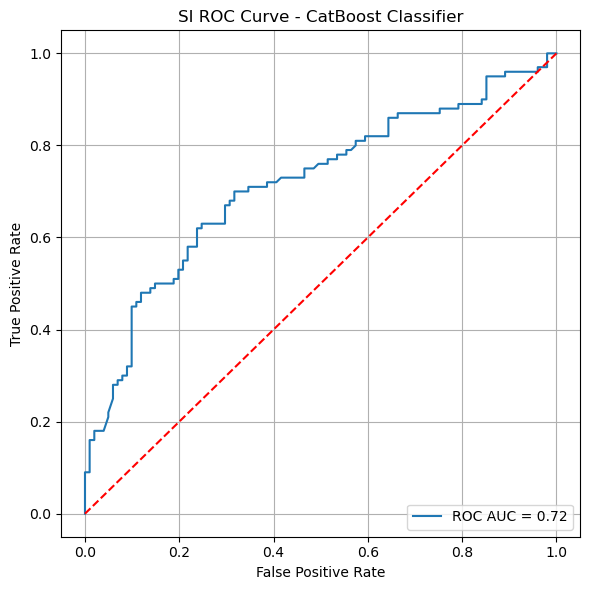

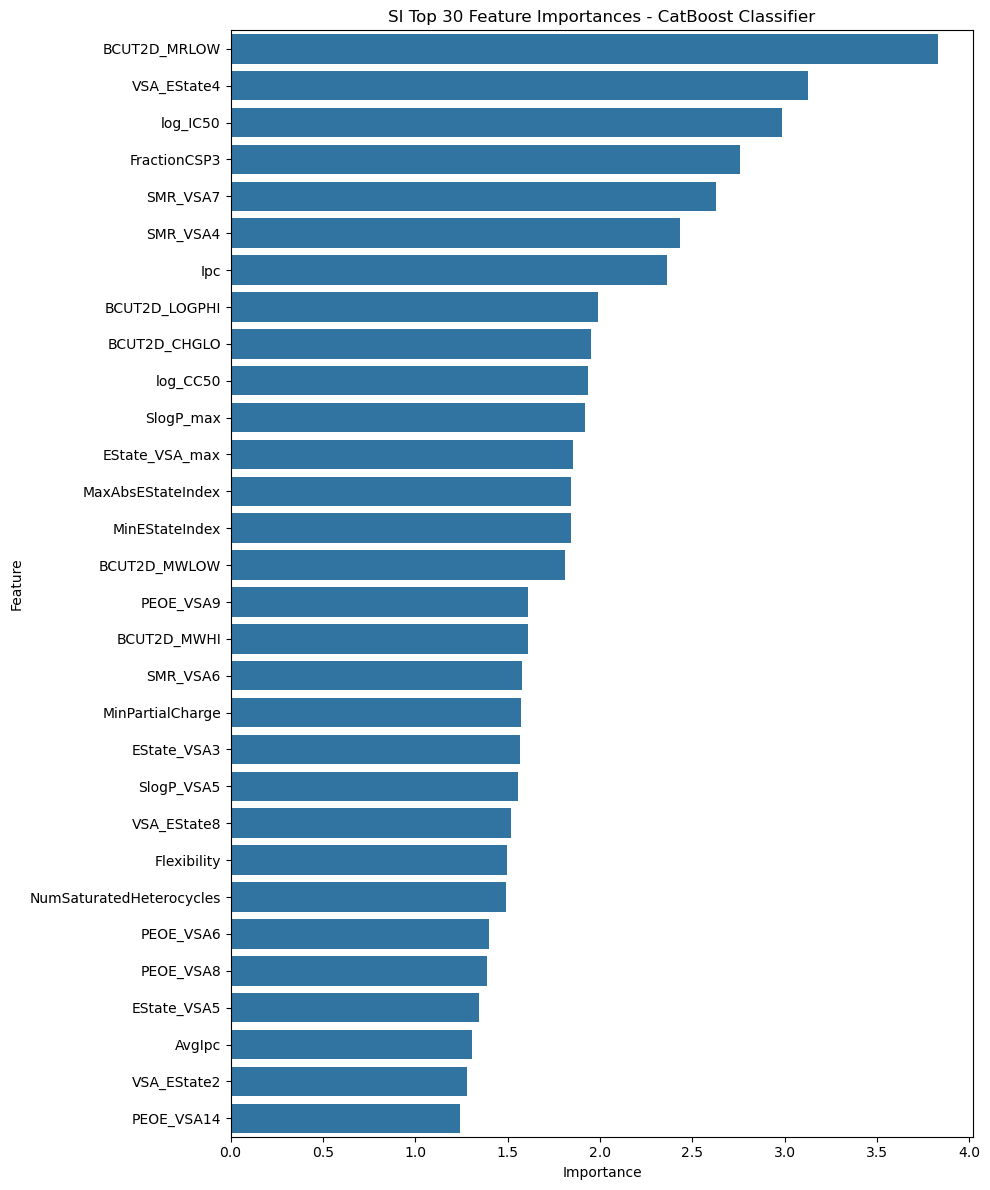


Модель сохранена как 'SI_classifier_catboost_final_model.pkl'


In [6]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
import joblib

# --- 1. Загрузка и подготовка ---
df = df_cut_bin.copy()
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df.columns:
    df.drop(columns=['Unnamed_0'], inplace=True)

# Удаляем RI_above_median (если есть)
if 'RI_above_median' in df.columns:
    df.drop(columns=['RI_above_median'], inplace=True)

# --- 1.1. Добавление log_IC50 ---
reg_ic50_model = joblib.load('regression_IC50_catboost_final_model_cut_bin_to SI_ckass.pkl')

X_full = df.drop(columns=['SI'])
SI_full = df['SI']

# Импутация и масштабирование для IC50
imputer_ic50 = SimpleImputer(strategy='most_frequent')
X_imp_ic50 = pd.DataFrame(imputer_ic50.fit_transform(X_full), columns=X_full.columns)

scaler_ic50 = RobustScaler()
X_scaled_ic50 = pd.DataFrame(scaler_ic50.fit_transform(X_imp_ic50), columns=X_full.columns)

X_full['log_IC50'] = reg_ic50_model.predict(X_scaled_ic50)

# --- 1.2. Добавление log_CC50 ---
reg_cc50_model = joblib.load('regression_CC50_lightgbm_final_model_cut_bin_to_SI_class.pkl')

# Повторно применяем импутирацию и масштабирование (можно переиспользовать предыдущие, если фичи те же)
imputer_cc50 = SimpleImputer(strategy='most_frequent')
X_imp_cc50 = pd.DataFrame(imputer_cc50.fit_transform(X_full.drop(columns=['log_IC50'])), 
                          columns=X_full.drop(columns=['log_IC50']).columns)

scaler_cc50 = RobustScaler()
X_scaled_cc50 = pd.DataFrame(scaler_cc50.fit_transform(X_imp_cc50), columns=X_imp_cc50.columns)

X_full['log_CC50'] = reg_cc50_model.predict(X_scaled_cc50)

# --- Проверка наличия новых признаков ---
required_features = ['log_IC50', 'log_CC50']
missing_features = [feat for feat in required_features if feat not in X_full.columns]

if missing_features:
    raise ValueError(f"Отсутствуют необходимые признаки: {missing_features}")
else:
    print(f"Признаки успешно добавлены: {required_features}")


# --- 2. Разделение на train/test ---
X_train_raw, X_test_raw, SI_train, SI_test = train_test_split(
    X_full, SI_full, test_size=0.2, random_state=42, stratify=(SI_full > SI_full.median())
)

# --- 3. Создание целевых переменных ---
train_median_SI = SI_train.median()
test_median_SI = SI_full.median()

y_train = (SI_train > train_median_SI).astype(int)
y_test = (SI_test > test_median_SI).astype(int)

# --- 4. Импутация и масштабирование ---
imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_raw), columns=X_test_raw.columns)

scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train_imputed.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_test_imputed.columns)

# --- 5. Параметры модели ---
catboost_params = {
    'depth': 6,
    'iterations': 100,
    'l2_leaf_reg': 5,
    'learning_rate': 0.05,
    'verbose': 0,
    'random_state': 42
}

# --- 6. Кросс-валидация ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_list, roc_auc_list = [], []

print("Running 5-fold cross-validation...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_raw), 1):
    X_tr_raw, X_val_raw = X_train_raw.iloc[train_idx], X_train_raw.iloc[val_idx]
    SI_tr, SI_val = SI_train.iloc[train_idx], SI_train.iloc[val_idx]

    median_fold = SI_tr.median()
    y_tr = (SI_tr > median_fold).astype(int)
    y_val = (SI_val > median_fold).astype(int)

    imputer = SimpleImputer(strategy='most_frequent')
    X_tr_imp = pd.DataFrame(imputer.fit_transform(X_tr_raw), columns=X_tr_raw.columns)
    X_val_imp = pd.DataFrame(imputer.transform(X_val_raw), columns=X_val_raw.columns)

    scaler = RobustScaler()
    X_tr_scaled = pd.DataFrame(scaler.fit_transform(X_tr_imp), columns=X_tr_raw.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val_imp), columns=X_tr_raw.columns)

    model = CatBoostClassifier(**catboost_params)
    model.fit(X_tr_scaled, y_tr)

    y_pred = model.predict(X_val_scaled)
    y_proba = model.predict_proba(X_val_scaled)[:, 1]

    acc = accuracy_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_proba)

    accuracy_list.append(acc)
    roc_auc_list.append(roc_auc)

    print(f"Fold {fold} Accuracy: {acc:.4f}, ROC AUC: {roc_auc:.4f}")

print("\nCross-validation results:")
print(f"Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
print(f"ROC AUC:  {np.mean(roc_auc_list):.4f} ± {np.std(roc_auc_list):.4f}")

# --- 7. Обучение финальной модели и тест ---
cat_model_eval = CatBoostClassifier(**catboost_params)
cat_model_eval.fit(X_train_scaled, y_train)

y_pred = cat_model_eval.predict(X_test_scaled)
y_proba = cat_model_eval.predict_proba(X_test_scaled)[:, 1]

acc_test = accuracy_score(y_test, y_pred)
roc_auc_test = roc_auc_score(y_test, y_proba)

print("\nClassification report:")
print(classification_report(y_test, y_pred))
print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test ROC AUC:  {roc_auc_test:.4f}")

# --- 8. ROC-кривая ---
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_test:.2f}")
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SI ROC Curve - CatBoost Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("SI_classifier_roc_curve.png")
plt.show()

# --- 9. Важность признаков ---
y_full = (SI_full > SI_full.median()).astype(int)

imputer_full = SimpleImputer(strategy='most_frequent')
X_imp_full = pd.DataFrame(imputer_full.fit_transform(X_full), columns=X_full.columns)

scaler_full = RobustScaler()
X_scaled_full = pd.DataFrame(scaler_full.fit_transform(X_imp_full), columns=X_full.columns)

cat_model_final = CatBoostClassifier(**catboost_params)
cat_model_final.fit(X_scaled_full, y_full)

feat_imp = cat_model_final.get_feature_importance(Pool(X_scaled_full, label=y_full))
feat_imp_df = pd.DataFrame({
    'Feature': X_full.columns,
    'Importance': feat_imp
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("SI Top 30 Feature Importances - CatBoost Classifier")
plt.tight_layout()
plt.savefig("SI_feature_importance.png")
plt.show()

# --- 10. Сохранение модели ---
joblib.dump(cat_model_final, 'SI_classifier_catboost_final_model.pkl')
print("\nМодель сохранена как 'SI_classifier_catboost_final_model.pkl'")


- по важным признакам

Признаки успешно добавлены: ['log_IC50', 'log_CC50']

[Top 25 Features] Classification report:
              precision    recall  f1-score   support

           0       0.65      0.79      0.71       101
           1       0.73      0.57      0.64       100

    accuracy                           0.68       201
   macro avg       0.69      0.68      0.68       201
weighted avg       0.69      0.68      0.68       201

[Top 25 Features] Test Accuracy: 0.6816
[Top 25 Features] Test ROC AUC:  0.7294


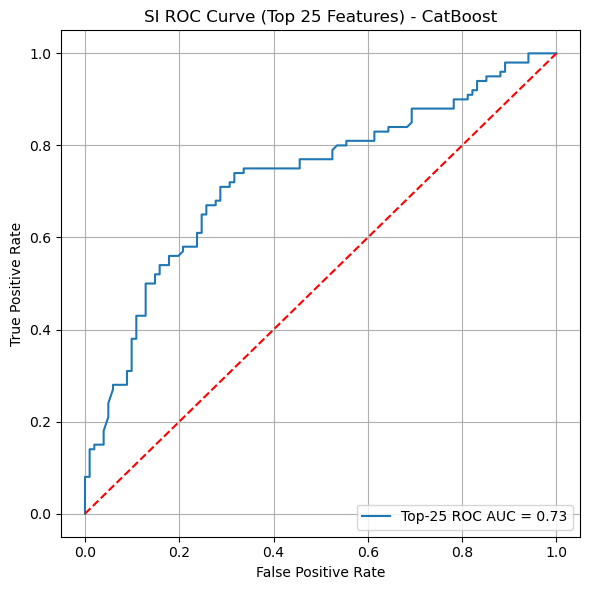


Модель на топ-25 признаках сохранена как 'SI_classifier_catboost_top25_model.pkl'


In [18]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
import joblib

# --- 1. Загрузка и очистка данных ---
df = df_cut_bin.copy()
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df.columns:
    df.drop(columns=['Unnamed_0'], inplace=True)

if 'RI_above_median' in df.columns:
    df.drop(columns=['RI_above_median'], inplace=True)

# --- 2. Добавление признаков log_IC50 и log_CC50 ---
reg_ic50_model = joblib.load('regression_IC50_catboost_final_model_cut_bin_to SI_ckass.pkl')
reg_cc50_model = joblib.load('regression_CC50_lightgbm_final_model_cut_bin_to_SI_class.pkl')

X_full = df.drop(columns=['SI'])
SI_full = df['SI']

# IC50
imputer_ic50 = SimpleImputer(strategy='most_frequent')
X_imp_ic50 = pd.DataFrame(imputer_ic50.fit_transform(X_full), columns=X_full.columns)
scaler_ic50 = RobustScaler()
X_scaled_ic50 = pd.DataFrame(scaler_ic50.fit_transform(X_imp_ic50), columns=X_full.columns)
X_full['log_IC50'] = reg_ic50_model.predict(X_scaled_ic50)

# CC50
imputer_cc50 = SimpleImputer(strategy='most_frequent')
X_imp_cc50 = pd.DataFrame(imputer_cc50.fit_transform(X_full.drop(columns=['log_IC50'])),
                          columns=X_full.drop(columns=['log_IC50']).columns)
scaler_cc50 = RobustScaler()
X_scaled_cc50 = pd.DataFrame(scaler_cc50.fit_transform(X_imp_cc50), columns=X_imp_cc50.columns)
X_full['log_CC50'] = reg_cc50_model.predict(X_scaled_cc50)

# Проверка
required_features = ['log_IC50', 'log_CC50']
missing_features = [feat for feat in required_features if feat not in X_full.columns]
if missing_features:
    raise ValueError(f"Отсутствуют необходимые признаки: {missing_features}")
else:
    print(f"Признаки успешно добавлены: {required_features}")

# --- 3. Создание бинарной целевой переменной ---
y_full = (SI_full > SI_full.median()).astype(int)

# --- 4. Импутация и масштабирование всех данных ---
imputer_full = SimpleImputer(strategy='most_frequent')
X_imp_full = pd.DataFrame(imputer_full.fit_transform(X_full), columns=X_full.columns)

scaler_full = RobustScaler()
X_scaled_full = pd.DataFrame(scaler_full.fit_transform(X_imp_full), columns=X_full.columns)

# --- 5. Обучение базовой модели для важности признаков ---
catboost_params = {
    'depth': 6,
    'iterations': 100,
    'l2_leaf_reg': 5,
    'learning_rate': 0.05,
    'verbose': 0,
    'random_state': 42
}

cat_model_full = CatBoostClassifier(**catboost_params)
cat_model_full.fit(X_scaled_full, y_full)

feat_imp = cat_model_full.get_feature_importance(Pool(X_scaled_full, label=y_full))
feat_imp_df = pd.DataFrame({
    'Feature': X_full.columns,
    'Importance': feat_imp
}).sort_values(by='Importance', ascending=False)

# --- 6. Выбор топ-25 признаков ---
top_25_features = feat_imp_df['Feature'].head(32).tolist()

# --- 7. Импутация и масштабирование для топ-25 признаков ---
X_top25_raw = X_full[top_25_features]
imputer_top25 = SimpleImputer(strategy='most_frequent')
X_top25_imputed = pd.DataFrame(imputer_top25.fit_transform(X_top25_raw), columns=top_25_features)

scaler_top25 = RobustScaler()
X_top25_scaled = pd.DataFrame(scaler_top25.fit_transform(X_top25_imputed), columns=top_25_features)

# --- 8. Train/Test split ---
X_train_top25, X_test_top25, y_train_top25, y_test_top25 = train_test_split(
    X_top25_scaled, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# --- 9. Обучение модели на топ-25 признаках ---
cat_model_top25 = CatBoostClassifier(**catboost_params)
cat_model_top25.fit(X_train_top25, y_train_top25)

# --- 10. Предсказания и метрики ---
y_pred_top25 = cat_model_top25.predict(X_test_top25)
y_proba_top25 = cat_model_top25.predict_proba(X_test_top25)[:, 1]

acc_top25 = accuracy_score(y_test_top25, y_pred_top25)
roc_auc_top25 = roc_auc_score(y_test_top25, y_proba_top25)

print("\n[Top 25 Features] Classification report:")
print(classification_report(y_test_top25, y_pred_top25))
print(f"[Top 25 Features] Test Accuracy: {acc_top25:.4f}")
print(f"[Top 25 Features] Test ROC AUC:  {roc_auc_top25:.4f}")

# --- 11. ROC-кривая ---
fpr_top25, tpr_top25, _ = roc_curve(y_test_top25, y_proba_top25)

plt.figure(figsize=(6, 6))
plt.plot(fpr_top25, tpr_top25, label=f"Top-25 ROC AUC = {roc_auc_top25:.2f}")
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SI ROC Curve (Top 25 Features) - CatBoost")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("SI_top25_roc_curve.png")
plt.show()

# --- 12. Сохранение модели ---
joblib.dump(cat_model_top25, 'SI_classifier_catboost_top25_model.pkl')
print("\nМодель на топ-25 признаках сохранена как 'SI_classifier_catboost_top25_model.pkl'")


Кривая лежит значительно выше красной линии, особенно в начале графика — это указывает на то, что модель обладает высокой чувствительностью при низком уровне ложных срабатываний, что ценно в биомедицинских задачах.

Признаки успешно добавлены: ['log_IC50', 'log_CC50']

--- Метрики по количеству топ-N признаков ---
N_Features |  Accuracy | ROC AUC
-----------------------------------
        10 |    0.6667 |  0.6843
        11 |    0.6517 |  0.6810
        12 |    0.6716 |  0.6896
        13 |    0.6766 |  0.7059
        14 |    0.6766 |  0.6974
        15 |    0.6866 |  0.6936
        16 |    0.6617 |  0.6977
        17 |    0.6866 |  0.7178
        18 |    0.6915 |  0.7124
        19 |    0.6866 |  0.7107
        20 |    0.6567 |  0.6927
        21 |    0.6617 |  0.7025
        22 |    0.6617 |  0.6980
        23 |    0.6269 |  0.6937
        24 |    0.6816 |  0.7174
        25 |    0.6667 |  0.7016
        26 |    0.6567 |  0.7054
        27 |    0.6617 |  0.7069
        28 |    0.6866 |  0.7136
        29 |    0.6716 |  0.6946
        30 |    0.6368 |  0.7080
        31 |    0.6816 |  0.7195
        32 |    0.6816 |  0.7294
        33 |    0.6617 |  0.6977
        34 |    0.6915 |  0.7076
      

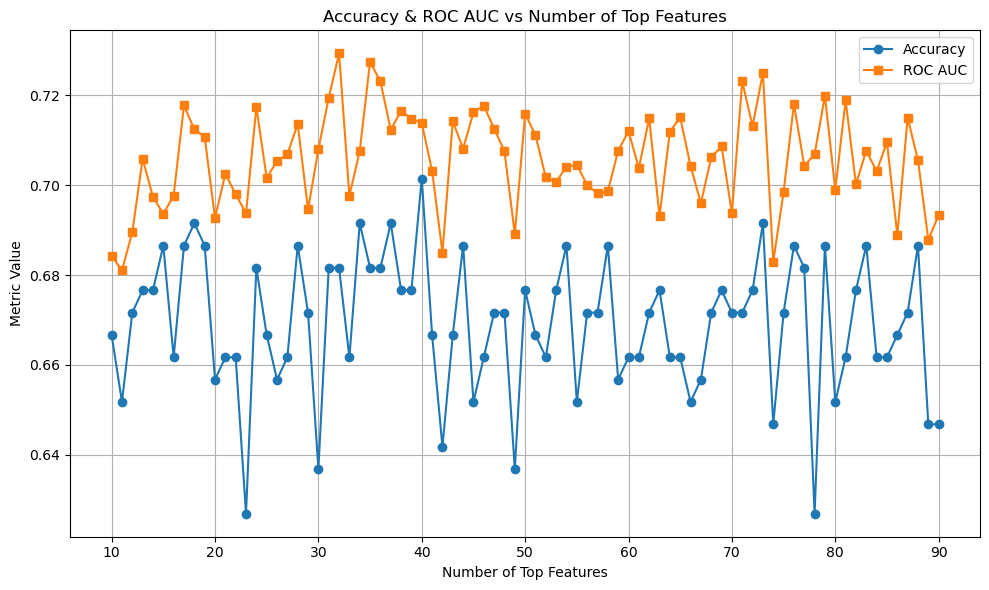

In [16]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
import joblib

# --- 1. Загрузка и очистка данных ---
df = df_cut_bin.copy()
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df.columns:
    df.drop(columns=['Unnamed_0'], inplace=True)

if 'RI_above_median' in df.columns:
    df.drop(columns=['RI_above_median'], inplace=True)

# --- 2. Добавление признаков log_IC50 и log_CC50 ---
reg_ic50_model = joblib.load('regression_IC50_catboost_final_model_cut_bin_to SI_ckass.pkl')
reg_cc50_model = joblib.load('regression_CC50_lightgbm_final_model_cut_bin_to_SI_class.pkl')

X_full = df.drop(columns=['SI'])
SI_full = df['SI']

# IC50
imputer_ic50 = SimpleImputer(strategy='most_frequent')
X_imp_ic50 = pd.DataFrame(imputer_ic50.fit_transform(X_full), columns=X_full.columns)
scaler_ic50 = RobustScaler()
X_scaled_ic50 = pd.DataFrame(scaler_ic50.fit_transform(X_imp_ic50), columns=X_full.columns)
X_full['log_IC50'] = reg_ic50_model.predict(X_scaled_ic50)

# CC50
imputer_cc50 = SimpleImputer(strategy='most_frequent')
X_imp_cc50 = pd.DataFrame(imputer_cc50.fit_transform(X_full.drop(columns=['log_IC50'])),
                          columns=X_full.drop(columns=['log_IC50']).columns)
scaler_cc50 = RobustScaler()
X_scaled_cc50 = pd.DataFrame(scaler_cc50.fit_transform(X_imp_cc50), columns=X_imp_cc50.columns)
X_full['log_CC50'] = reg_cc50_model.predict(X_scaled_cc50)

# Проверка
required_features = ['log_IC50', 'log_CC50']
missing_features = [feat for feat in required_features if feat not in X_full.columns]
if missing_features:
    raise ValueError(f"Отсутствуют необходимые признаки: {missing_features}")
else:
    print(f"Признаки успешно добавлены: {required_features}")

# --- 3. Целевая переменная ---
y_full = (SI_full > SI_full.median()).astype(int)

# --- 4. Импутация и масштабирование всех признаков ---
imputer_full = SimpleImputer(strategy='most_frequent')
X_imp_full = pd.DataFrame(imputer_full.fit_transform(X_full), columns=X_full.columns)

scaler_full = RobustScaler()
X_scaled_full = pd.DataFrame(scaler_full.fit_transform(X_imp_full), columns=X_full.columns)

# --- 5. Обучение модели для определения важности признаков ---
catboost_params = {
    'depth': 6,
    'iterations': 100,
    'l2_leaf_reg': 5,
    'learning_rate': 0.05,
    'verbose': 0,
    'random_state': 42
}

cat_model_full = CatBoostClassifier(**catboost_params)
cat_model_full.fit(X_scaled_full, y_full)

feat_imp = cat_model_full.get_feature_importance(Pool(X_scaled_full, label=y_full))
feat_imp_df = pd.DataFrame({
    'Feature': X_full.columns,
    'Importance': feat_imp
}).sort_values(by='Importance', ascending=False)

# --- 6. Цикл по количеству признаков от 10 до 90 ---
print("\n--- Метрики по количеству топ-N признаков ---")
print(f"{'N_Features':>10} | {'Accuracy':>9} | {'ROC AUC':>7}")
print("-" * 35)

results = []

for n_features in range(10, 91, 1):
    top_features = feat_imp_df['Feature'].head(n_features).tolist()
    
    # Импутация и масштабирование
    X_selected = X_full[top_features]
    imputer = SimpleImputer(strategy='most_frequent')
    X_imputed = pd.DataFrame(imputer.fit_transform(X_selected), columns=top_features)

    scaler = RobustScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=top_features)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_full, test_size=0.2, random_state=42, stratify=y_full
    )

    # Обучение модели
    model = CatBoostClassifier(**catboost_params)
    model.fit(X_train, y_train)

    # Предсказания и метрики
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"{n_features:>10} | {acc:9.4f} | {roc_auc:7.4f}")
    results.append((n_features, acc, roc_auc))

# --- 7. График зависимости метрик от числа признаков ---
results_df = pd.DataFrame(results, columns=['N_Features', 'Accuracy', 'ROC_AUC'])

plt.figure(figsize=(10, 6))
plt.plot(results_df['N_Features'], results_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(results_df['N_Features'], results_df['ROC_AUC'], label='ROC AUC', marker='s')
plt.xlabel('Number of Top Features')
plt.ylabel('Metric Value')
plt.title('Accuracy & ROC AUC vs Number of Top Features')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("SI_metrics_vs_features.png")
plt.show()


- калибровкой вероятностей методом Platt (sigmoid)

Это метод калибровки вероятностей для **бинарной классификации**:

- обучается **логистическая регрессия** (сигмоида) поверх **оценок (logits)** от основного классификатора,
- задача: откалибровать сырые оценки так, чтобы они стали **корректными вероятностями классов**.

---

 Формула:
$
P(y = 1 \mid x) = \frac{1}{1 + \exp(A \cdot f(x) + B)}
$

где:
-  f(x)  — выход базовой модели (например, CatBoost, SVM и т.д.),
-  A, B  — параметры, которые подбираются по отложенному (валидационному) набору.

Platt Scaling (или sigmoid-калибровка) — это метод, который:

не переобучает саму модель,

а преобразует вероятности так, чтобы они лучше соответствовали истинным вероятностям (калибровка).

Он обучает логистическую регрессию на предсказанных вероятностях модели и использует её для улучшения вероятностной оценки.

Признаки успешно добавлены: ['log_IC50', 'log_CC50']

=== Сравнение до и после Platt Scaling ===
Accuracy (base):      0.6816
ROC AUC (base):       0.7294
Accuracy (calibrated):0.6965
ROC AUC (calibrated): 0.7259


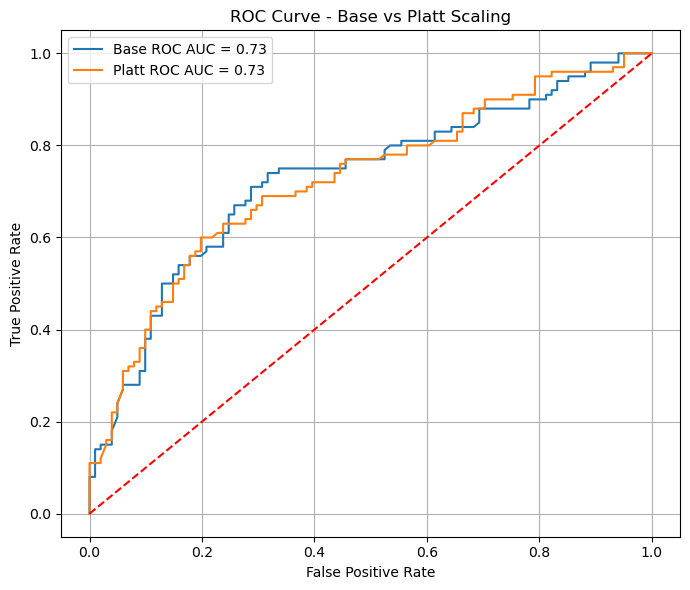

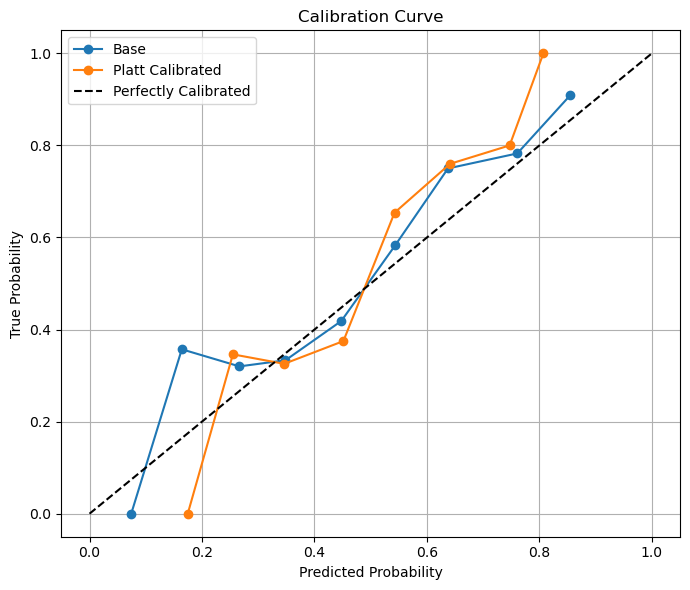


Откалиброванная модель сохранена как 'SI_classifier_top25_platt_scaled.pkl'


In [28]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    roc_curve, brier_score_loss
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
import joblib

# --- 1. Загрузка и очистка данных ---
df = df_cut_bin.copy()
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df.columns:
    df.drop(columns=['Unnamed_0'], inplace=True)

if 'RI_above_median' in df.columns:
    df.drop(columns=['RI_above_median'], inplace=True)

# --- 2. Добавление признаков log_IC50 и log_CC50 ---
reg_ic50_model = joblib.load('regression_IC50_catboost_final_model_cut_bin_to SI_ckass.pkl')
reg_cc50_model = joblib.load('regression_CC50_lightgbm_final_model_cut_bin_to_SI_class.pkl')

X_full = df.drop(columns=['SI'])
SI_full = df['SI']

# IC50
imputer_ic50 = SimpleImputer(strategy='most_frequent')
X_imp_ic50 = pd.DataFrame(imputer_ic50.fit_transform(X_full), columns=X_full.columns)
scaler_ic50 = RobustScaler()
X_scaled_ic50 = pd.DataFrame(scaler_ic50.fit_transform(X_imp_ic50), columns=X_full.columns)
X_full['log_IC50'] = reg_ic50_model.predict(X_scaled_ic50)

# CC50
imputer_cc50 = SimpleImputer(strategy='most_frequent')
X_imp_cc50 = pd.DataFrame(imputer_cc50.fit_transform(X_full.drop(columns=['log_IC50'])),
                          columns=X_full.drop(columns=['log_IC50']).columns)
scaler_cc50 = RobustScaler()
X_scaled_cc50 = pd.DataFrame(scaler_cc50.fit_transform(X_imp_cc50), columns=X_imp_cc50.columns)
X_full['log_CC50'] = reg_cc50_model.predict(X_scaled_cc50)

# Проверка
required_features = ['log_IC50', 'log_CC50']
missing_features = [feat for feat in required_features if feat not in X_full.columns]
if missing_features:
    raise ValueError(f"Отсутствуют необходимые признаки: {missing_features}")
else:
    print(f"Признаки успешно добавлены: {required_features}")

# --- 3. Целевая переменная ---
y_full = (SI_full > SI_full.median()).astype(int)

# --- 4. Импутация и масштабирование всех данных ---
imputer_full = SimpleImputer(strategy='most_frequent')
X_imp_full = pd.DataFrame(imputer_full.fit_transform(X_full), columns=X_full.columns)

scaler_full = RobustScaler()
X_scaled_full = pd.DataFrame(scaler_full.fit_transform(X_imp_full), columns=X_full.columns)

# --- 5. Обучение базовой модели ---
catboost_params = {
    'depth': 6,
    'iterations': 100,
    'l2_leaf_reg': 5,
    'learning_rate': 0.05,
    'verbose': 0,
    'random_state': 42
}

cat_model_full = CatBoostClassifier(**catboost_params)
cat_model_full.fit(X_scaled_full, y_full)

feat_imp = cat_model_full.get_feature_importance(Pool(X_scaled_full, label=y_full))
feat_imp_df = pd.DataFrame({
    'Feature': X_full.columns,
    'Importance': feat_imp
}).sort_values(by='Importance', ascending=False)

# --- 6. Top 25 признаков ---
top_features = feat_imp_df['Feature'].head(32).tolist()
X_top = X_full[top_features]

# --- 7. Предобработка ---
imputer_top = SimpleImputer(strategy='most_frequent')
X_top_imputed = pd.DataFrame(imputer_top.fit_transform(X_top), columns=top_features)

scaler_top = RobustScaler()
X_top_scaled = pd.DataFrame(scaler_top.fit_transform(X_top_imputed), columns=top_features)

X_train, X_test, y_train, y_test = train_test_split(
    X_top_scaled, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# --- 8. Базовая модель ---
base_model = CatBoostClassifier(**catboost_params)
base_model.fit(X_train, y_train)

y_pred_base = base_model.predict(X_test)
y_proba_base = base_model.predict_proba(X_test)[:, 1]

acc_base = accuracy_score(y_test, y_pred_base)
roc_auc_base = roc_auc_score(y_test, y_proba_base)

# --- 9. Platt Scaling ---
calibrated_clf = CalibratedClassifierCV(estimator=base_model, method='sigmoid', cv=5)
calibrated_clf.fit(X_train, y_train)

y_pred_cal = calibrated_clf.predict(X_test)
y_proba_cal = calibrated_clf.predict_proba(X_test)[:, 1]

acc_cal = accuracy_score(y_test, y_pred_cal)
roc_auc_cal = roc_auc_score(y_test, y_proba_cal)

# --- 10. Сравнение метрик ---
print("\n=== Сравнение до и после Platt Scaling ===")
print(f"Accuracy (base):      {acc_base:.4f}")
print(f"ROC AUC (base):       {roc_auc_base:.4f}")
print(f"Accuracy (calibrated):{acc_cal:.4f}")
print(f"ROC AUC (calibrated): {roc_auc_cal:.4f}")

# --- 11. ROC-кривые ---
fpr_base, tpr_base, _ = roc_curve(y_test, y_proba_base)
fpr_cal, tpr_cal, _ = roc_curve(y_test, y_proba_cal)

plt.figure(figsize=(7, 6))
plt.plot(fpr_base, tpr_base, label=f'Base ROC AUC = {roc_auc_base:.2f}')
plt.plot(fpr_cal, tpr_cal, label=f'Platt ROC AUC = {roc_auc_cal:.2f}')
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Base vs Platt Scaling")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_comparison_base_vs_platt.png")
plt.show()

# --- 12. Калибровочная кривая ---
prob_true_base, prob_pred_base = calibration_curve(y_test, y_proba_base, n_bins=10)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_proba_cal, n_bins=10)

plt.figure(figsize=(7, 6))
plt.plot(prob_pred_base, prob_true_base, marker='o', label='Base')
plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='Platt Calibrated')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("calibration_curve_base_vs_platt.png")
plt.show()

# --- 13. Сохранение модели ---
joblib.dump(calibrated_clf, 'SI_classifier_top25_platt_scaled.pkl')
print("\nОткалиброванная модель сохранена как 'SI_classifier_top25_platt_scaled.pkl'")
